# ===============================================================
# -
#  -   -   Updated: Read in and process reservoir elevation, temperature and upstream/downstream temperature
# -
# ===============================================================

# =============================================================================
#          Read in packages
# ==============================================================================

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from os import listdir
from os.path import isfile, join
from climata.hydromet import MultiStationDailyIO 
import datetime as dt
import ulmo
from ulmo import cdec
from ulmo import util
import re
import math

%matplotlib inline

# =============================================================================
#          Read in data info files
# ==============================================================================

In [2]:
# ================================================================================================
#    PNW: list with bureau of reclamation site IDs and burea of rec, USGS, and NorWest IDs
# ================================================================================================

flow_path = '/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/merged_data/'

# DATA ORDER: reservoir name, resrvoir code, upstream gauge 1, upstream gauge 2, upstream gauge 3, downstream gauge 1, downstream gauge 2, downstream gauge 3
# NOTE: gagues #1 are closest to reservoir, #2 is next closest, etc. (so #3 upstream is most upstream, #3 is furthest downstream)

# ------------------ read csv ----------
reservoirs_temp_bor = pd.read_csv(flow_path  + 'reservoirs_temp_bor.csv')  
reservoirs_temp_usgs = pd.read_csv(flow_path  + 'reservoirs_temp_usgs.csv')  
reservoirs_temp_norwest = pd.read_csv(flow_path  + 'reservoirs_temp_norwest.csv')  
trib_temp_norwest = pd.read_csv(flow_path  + 'trib_temp_norwest.csv')  

In [2]:
# ================================================================================================
#    CA: list with bureau of reclamation site IDs and burea of rec, USGS, and NorWest IDs
# ================================================================================================

flow_path = '/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/merged_data/'

# DATA ORDER: reservoir name, resrvoir code, upstream gauge 1, upstream gauge 2, upstream gauge 3, downstream gauge 1, downstream gauge 2, downstream gauge 3
#              First series of data is USGS, second is NorWest
# NOTE: gagues #1 are closest to reservoir, #2 is next closest, etc. (so #3 upstream is most upstream, #3 is furthest downstream)

# ------------------ read in two csv, then merge them (second has site info) ----------
CA_reservoir_info = pd.read_csv(flow_path  + 'CA_USGS_NorWest.csv')
CA_reservoir_info = CA_reservoir_info.sort_values(by='site_code', ascending=1)
CA_reservoir_info = CA_reservoir_info.set_index(CA_reservoir_info['site_code'])
CA_reservoir_info2 = pd.read_csv(flow_path  + 'CA_reservoir_stations_with_data.csv')
CA_reservoir_info2 = CA_reservoir_info2.set_index(CA_reservoir_info2['site_no'])
CA_reservoir_info = pd.merge(CA_reservoir_info,CA_reservoir_info2, how='inner', left_index=True, right_index=True)
CA_reservoir_info = CA_reservoir_info.set_index(np.arange(0,len(CA_reservoir_info))) # set index as number

In [3]:
# =========== match up excel files with names on shapefile csv =====================

ID_match_ups = [
    [ 'WACoast' ,13  ],
    [ 'CentralCA' , 0 ],
    ['Clearwater'  , 1  ],
    [ 'CoastalCA' , 2 ],
    [ 'KlamathNorthernCA' , 3 ],
    [ 'Lahontan' , 'NaN' ],
    [ 'MidColumbia' ,4  ],
    [ 'MidSnake' , 5 ],
    [ 'MissouriHW'  , 6  ],
    [ 'ORCoast' , 12 ],
    [ 'ORSouthCentral' , 7 ],
    [ 'Salmon' , 8 ],
    [ 'SnakeBear' , 9  ],
    [ 'Spokoot' , 10 ],
    [ 'UppColumbiaYakima' , 11 ]
    
]

site_name = [item[0] for item in ID_match_ups]

In [4]:
# ================================================================================================
#    list with NorWest site IDs and the unique IDs for each year
# ================================================================================================

pathx = '/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/merged_data/NorWest_IDs_df.csv'

# ------------------ read csv ----------
NorWest_ID_list = pd.read_csv(pathx)
NorWest_ID_list = NorWest_ID_list.drop('Unnamed: 0',1)
NorWest_ID_list.columns = ['code', 'region', 'year1','year2', 'year3','year4','year5','year6','year7','year8','year9','year10',
                                             'year11','year12','year13','year14','year15','year16','year17','year18','year19','year20', 'year21']

In [5]:
# -----------------------list all the NorWest files --------------------
stream_temp_NorWest_path = '/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/NorWest/stream_temps'
all_NorWest_files = [f for f in listdir(stream_temp_NorWest_path) if isfile(join(stream_temp_NorWest_path, f))]


# =============================================================================
#         Define Functions
# ==============================================================================

In [6]:
# =============================================================================
#          Function to read in Burea of Reclamation data
# ==============================================================================

def read_bureau_of_rec_data(start_datetime, end_datetime, station_id, parameterx):
    ''' This function reads in Bureau of Reclamation reservoir elevation data

    Input:
        station_id: [string] Bureau of Reclamation abbreviation of reservoir ID
        start_datetime: [dt.datetime] start time
        end_datetime: [dt.datetime] end time

           to find station ID: 
            find the reservoir on Bureau of Reclamation data 
            (PNW and Montana, WYoming: http://www.usbr.gov/pn/hydromet/arcread.html)
            OR search for the reservoir and "Bureau of Reclamation" since reservoir might not be on the dropdown tab
            the teacup diagrams have abreviations (http://www.usbr.gov/pn/hydromet/select.html)
            
           same code is used to read in other Bureau of Rec data. IDs are: fb = surface elevatoin (ft), 
              qd - daily average stream discharge (cfs), pc = precip (inches), 
              mm = average air temp (deg F), wy = average water temperature (celsius)

    Return:
        Selected data (pandas Series)
    '''

    data = MultiStationDailyIO(
    start_date=start_datetime,
    end_date=end_datetime,
    station=station_id,
    parameter=parameterx,
    )
    
    data2 = []
    for series in data:
        for row in series.data:
            data2.append(row[1])
    
            
    data3 = pd.DataFrame(data2,index=pd.date_range(start_datetime,end_datetime))
    data4 = data3.convert_objects(convert_numeric=True)
    data4.columns = ['res_level']
    
    return data4

In [177]:
# =============================================================================
#          Function to read in USGS data
# ==============================================================================

def importusgssite_meantemperature(siteno):
    sitename = {}

    # ------ temperature with Celsius ------
    sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00003',period="all", methods='all')
    # ------ temperature with Celsius - minimum temperature ------
    sitename_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00002',period="all", methods='all')
    # ------ temperature with Celsius - maximum temperature ------
    sitename_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00001',period="all", methods='all')

    # ------ temperature with Fahrenheit ------
    sitename2 = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00003',period="all", methods='all')
    # ------ temperature with Fahrenheit ------
    sitename2_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00002',period="all", methods='all')
    # ------ temperature with Fahrenheit ------
    sitename2_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00001',period="all", methods='all')
    
    #  ----------- loop to see if it is a F or C data, and if there are multipe measurements at one site ------------
    if len(sitename) > 0 or len(sitename2) > 0 :

        if len(sitename) == 1:
            sitenameb = pd.DataFrame(sitename['00010:00003']['values'])  # temperature in celsius
            unitsx = 'C'
        if len(sitename) > 1:
            unitsx = 'C'
            for k in sitename:
                sitenameb = pd.DataFrame(sitename[str(k)]['values'])  # temperature in celsius

        if len(sitename2) == 1:
            sitenameb = pd.DataFrame(sitename2['00011:00003']['values'])  # temperature in fahrenheit
            unitsx = 'F'
        if len(sitename2) > 1:
            unitsx = 'F'
            for k in sitename2:
                sitenameb = pd.DataFrame(sitename2[str(k)]['values'])  # temperature in fahrenheit


        # -------- index, clean the data -------
        sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
        sitenameb.set_index(['dates'], inplace=True)
        sitenameb[siteno] = sitenameb['value'].astype(float)
        sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
        sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
        sitenameb = sitenameb.replace('-999999', np.NAN)
        sitenameb = sitenameb.dropna()
        sitenameb.columns = ['temperature', 'data_quality']

        # IF units in Fahrenheit - convert to Celsius
        if unitsx == 'F':
            sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)
            
        sitenameb = pd.DataFrame(sitenameb)
        return sitenameb

    #  -------------- loop to see if it there is just min/max data (celsius) ----------------

    
    elif len(sitename_min) > 0 and len(sitename_max) > 0 and (len(sitename) < 1 and len(sitename2) < 1) :

        if len(sitename_max) == 1:
            sitenameb_max = pd.DataFrame(sitename_max['00010:00001']['values'])  # max temperature in celsius
            unitsx_max = 'C'
        if len(sitename_max) > 1:
            unitsx_max = 'C'
            for k in sitename_max:
                sitenameb_max = pd.DataFrame(sitename_max[str(k)]['values'])  # max temperature in celsius

        if len(sitename_min) == 1:
            sitenameb_min = pd.DataFrame(sitename_min['00010:00002']['values'])  # min temperature in celsius
            unitsx_min = 'C'
        if len(sitename_min) > 1:
            unitsx_min = 'C'
            for k in sitename_min:
                sitenameb_min = pd.DataFrame(sitename_min[str(k)]['values'])  # min temperature in celsius
        
        # --------------- get mean value between min and max temperature --------
        print(sitenameb_min.head())
        print(sitenameb_max.head())
        site_data_x = sitenameb_min['datetime']
        sitenameb_min = sitenameb_min.set_index(pd.to_datetime(sitenameb_min['datetime']) )
        sitenameb_max = sitenameb_max.set_index(pd.to_datetime(sitenameb_max['datetime']) )
        sitenameb = sitenameb_max.merge(sitenameb_min, how='inner', left_index=True, right_index=True)
        sitenameb = sitenameb[['value_x','value_y']]
        sitenameb = sitenameb.convert_objects(convert_numeric=True)
        sitenameb = sitenameb.mean(axis=1)
        
        sitenameb = pd.DataFrame(sitenameb)

        return sitenameb

    #  -------------- loop to see if it there is just min/max data (fahrenheit) ----------------
    elif len(sitename2_min) > 0 and len(sitename2_max) > 0 and (len(sitename) < 1 and len(sitename2) < 1) :

        if len(sitename_max) == 1:
            sitenameb_max = pd.DataFrame(sitename2_max['00011:00001']['values'])  # max temperature in fahrenheit

        if len(sitename2_max) > 1:

            for k in sitename2_max:
                sitenameb_max = pd.DataFrame(sitename2_max[str(k)]['values'])  # max temperature in fahrenheit

        if len(sitename2_min) == 1:
            sitenameb_min = pd.DataFrame(sitename2_min['00011:00002']['values'])  # min temperature in fahrenheit

        if len(sitename2_min) > 1:
            unitsx_min = 'C'
            for k in sitename2_min:
                sitenameb_min = pd.DataFrame(sitename2_min[str(k)]['values'])  # min temperature in fahrenheit

        # IF units in Fahrenheit - convert to Celsius
        sitenameb_max.temperature = (sitenameb_max.temperature - 32) * (5/9)
        sitenameb_min.temperature = (sitenameb_min.temperature - 32) * (5/9)

        # --------------- get mean value between min and max temperature --------
        
        sitenameb_min = sitenameb_min.set_index(pd.to_datetime(sitenameb_min['datetime']) )
        sitenameb_max = sitenameb_max.set_index(pd.to_datetime(sitenameb_max['datetime']) )
        sitenameb = sitenameb_max.merge(sitenameb_min, how='inner', left_index=True, right_index=True)
        sitenameb = sitenameb[['value_x','value_y']]
        sitenameb = sitenameb.convert_objects(convert_numeric=True)
        sitenameb = sitenameb.mean(axis=1)
        
        sitenameb = pd.DataFrame(sitenameb)
        return sitenameb
    
    # ------------ if no data present or not able to read ---------
    if len(sitename) == 0:
        sitenameb = pd.DataFrame(np.nan, index=[0], columns=['A'])
        
        return sitenameb


In [9]:
# =============================================================================
#          Function to read in NorWest data
# ==============================================================================

def read_NorWest_data(station_id):
    ''' This function reads in NorWest stream temperature data

    Input:
        station_id: [float] USGS site ID

    Return:
        Selected data (pandas Series)
    '''

    #station_id = reservoirs_temp_norwest['downstream1'][4]


    # -------------- get the Norwest ID row and site code --------------
    site_row = NorWest_ID_list[NorWest_ID_list.code==station_id]
    stringx = str(site_row.region.values)
    stringx = ''.join(e for e in stringx if e.isalnum())

    # ------------------ read in NorWest data files -----------------

    filex = all_NorWest_files[ID_match_ups[site_name.index(str(stringx))][1]]
    pathx = stream_temp_NorWest_path + '/' + filex

    site_id_x = ID_match_ups[site_name.index(str(stringx))][1]
    #  ------- Oregon is .txt (12 position) -----------
    if site_id_x == 12:
        data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])  

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])
            if 'DailyMean' in data_x.columns:
                data_x['DAILYMEAN'] = data_x['DailyMean']

        if 'Date' in data_x.columns:
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']

    #  ------- all other files (excel) -----------       
    else:
        data_x = pd.read_excel(pathx)

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'DATE' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        #if 'Date' in data_x.columns:
        #    data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        #    data_x = data_x.set_index(data_x['Date'])
        #    data_x['DATE'] = data_x['Date']
        #    data_x['DAILYMEAN'] = data_x['DailyMean']
            
        if 'DailyMean' in data_x.columns:
            if 'DATE' in data_x.columns:
                data_x['Date'] = data_x['DATE']
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']

    listx = site_row[0:1].values
    listx = listx[0,2:len(listx[0,:])] #get just the site/year values (w/ NaN)
    list_len = sum(i > 0 for i in listx) #get just the site/year values - remove NaN
    site_list_x = listx[0:list_len] #get just the site/year values
    data_x3 = pd.DataFrame()
    for i in range(len(site_list_x)):
        site_i = int(float(str(site_list_x[i])))
        data_x2 = data_x[data_x['OBSPRED_ID']==site_i]
        data_x2 = pd.DataFrame(data_x2['DAILYMEAN'])
        data_x3 = data_x3.append(data_x2)
    
    return data_x3

In [54]:
# =============================================================================
#          Functions to read in California data
# ==============================================================================

# =============================
#   get CA station data 
# =============================

def get_data(station_ids=None, sensor_ids=None, resolutions=None, start=None, end=None):
    """
    Downloads data for a set of CDEC station and sensor ids. If either is not
    provided, all available data will be downloaded. Be really careful with
    choosing hourly resolution as the data sets are big, and CDEC's servers
    are slow as molasses in winter.
    Usage example::
        from ulmo import cdec
        dat = cdec.historical.get_data(['PRA'],resolutions=['daily'])
    Parameters
    ----------
    station_ids : iterable of strings or ``None``
    sensor_ids : iterable of integers or ``None``
        check out  or use the ``get_sensors()`` function to see a list of
        available sensor numbers
    resolutions : iterable of strings or ``None``
        Possible values are 'event', 'hourly', 'daily', and 'monthly' but not
        all of these time resolutions are available at every station.
    Returns
    -------
    dict : a python dict
        a python dict with site codes as keys. Values will be nested dicts
        containing all of the sensor/resolution combinations.
    """

    if start is None:
        start_date = util.convert_date(DEFAULT_START_DATE)
    else:
        start_date = util.convert_date(start)
    if end is None:
        end_date = util.convert_date(DEFAULT_END_DATE)
    else:
        end_date = util.convert_date(end)

    start_date_str = _format_date(start_date)
    end_date_str = _format_date(end_date)

    if station_ids is None:
        station_ids = get_stations().index

    sensors = get_station_sensors(station_ids, sensor_ids, resolutions)
    print(sensors)
    
    d = {}

    for station_id, sensor_list in sensors.items():
        station_data = {}

        for index, row in sensor_list.iterrows():
            res = row.ix['resolution']
            var = row.ix['variable']
            sensor_id = row.ix['sensor_id']
            station_data[var] = _download_raw(station_id, sensor_id, _res_to_dur_code(res), start_date_str, end_date_str)

        d[station_id] = station_data

    return d

# =============================
#   list sensor list at site
# =============================

def _limit_sensor_list(sensor_list, sensor_ids, resolution):

    if sensor_ids is not None:
        sensor_list = sensor_list[[x in sensor_ids for x in sensor_list.sensor_id]]

    if resolution is not None:
        sensor_list = sensor_list[[x in resolution for x in sensor_list.resolution]]

    return sensor_list


# =============================
#   download raw data
# =============================

def _download_raw(station_id, sensor_num, dur_code, start_date, end_date):

    url = 'http://cdec.water.ca.gov/cgi-progs/queryCSV' + \
        '?station_id=' + station_id + \
        '&dur_code=' + dur_code + \
        '&sensor_num=' + str(sensor_num) + \
        '&start_date=' + start_date + \
        '&end_date=' + end_date

    df = pd.read_csv(url, skiprows=2, header=None, parse_dates=[[0,1]], index_col=None, na_values='m')
    df.columns = ['datetime', 'value']
    df.set_index('datetime', inplace=True)

    return df

# =============================
#   time code
# =============================

def _res_to_dur_code(res):
    map = {
        'hourly':'H',
        'daily':'D',
        'monthly':'M',
        'event':'E'}

    return map[res]


# =============================
#   date format
# =============================

def _format_date(date):
    return '%s/%s/%s' % (date.month, date.day, date.year)


# =============================
#   get station sensors 
# =============================

def get_station_sensors(station_ids=None, sensor_ids=None, resolutions=None):
    """
    Gets available sensors for the given stations, sensor ids and time
    resolutions. If no station ids are provided, all available stations will
    be used (this is not recommended, and will probably take a really long
    time).
    The list can be limited by a list of sensor numbers, or time resolutions
    if you already know what you want. If none of the provided sensors or
    resolutions are available, an empty DataFrame will be returned for that
    station.
    Usage example::
        from ulmo import cdec
        # to get all available sensors
        available_sensors = cdec.historical.get_station_sensors(['NEW'])
    Parameters
    ----------
    station_ids : iterable of strings or ``None``
    sensor_ids : iterable of integers or ``None``
        check out  or use the ``get_sensors()`` function to see a list of
        available sensor numbers
    resolutions : iterable of strings or ``None``
        Possible values are 'event', 'hourly', 'daily', and 'monthly' but not
        all of these time resolutions are available at every station.
    Returns
    -------
    dict : a python dict
        a python dict with site codes as keys with values containing pandas
        DataFrames of available sensor numbers and metadata.
        
    example use: 
        get_station_sensors(station_ids=['SHA'])
    """

    station_sensors = {}
        
    if station_ids is None:
        station_ids = get_stations().index


    for station_id in station_ids:
        url = 'http://cdec.water.ca.gov/cgi-progs/queryCSV?station_id=%s' % (station_id)
        
        sensor_list = pd.read_html(url)[0]
        
        sensor_list.columns = ['sensor_id','variable','resolution','timerange']
        v = sensor_list.variable.to_dict().values()

        split = [re.split(r'[\(\)]+',x) for x in v]
        var_names = [x[0] for x in split]
        units = [x[1] for x in split]
        var_resolution = [re.split(r'[\(\)]+',x)[1] for x in sensor_list.resolution]

        sensor_list['resolution'] = var_resolution
        sensor_list['variable'] = [x + y for x, y in zip(var_names, var_resolution)]
        sensor_list['units'] = pd.Series(units,index=sensor_list.index)

        station_sensors[station_id] = _limit_sensor_list(sensor_list, sensor_ids, resolutions)

    return station_sensors

# ===================================
#   bring all fxns together 
# ==================================

def read_CA_reservoir_data(idx, sensor_idx, time_res):
    
    # example use:  
    #    dat = read_CA_reservoir_data('SHA',74,'daily')
    
    datax = get_station_sensors(station_ids=[idx], sensor_ids=[sensor_idx], resolutions=[time_res])
    
    if len(datax[idx]) > 0:
        datax2 = cdec.historical.get_data([idx], sensor_ids=[sensor_idx], resolutions = time_res)
        datax2 = datax2[idx][re.findall(r"'(.*?)'", str(datax2[idx].keys()), re.DOTALL)[0]]
        return datax2, True
    else:
        return np.nan, False
    

# ============================================================================================
#       Loops through each, and concatenate all the data, and save it 
###       the purpose is so you don't have to waste time read in data from online server
# ============================================================================================

downloading  TULLOCH  data....
RESERVOIR DATA:               value
datetime          
1985-01-02  503.14
1985-01-03     NaN
1985-01-04     NaN
1985-01-05     NaN
1985-01-06     NaN
res logic:  True release logic True
FIRST DATA MERGE:              res_level  releases
datetime                       
1985-01-02     503.14       NaN
1985-01-03        NaN       NaN
1985-01-04        NaN       NaN
1985-01-05        NaN       NaN
1985-01-06        NaN       NaN
data INFLOWS A:               value
datetime          
1990-01-01     4.0
1990-01-02  1071.0
1990-01-03     5.0
1990-01-04    -2.0
1990-01-05    23.0
SECOND DATA MERGE_A1:              res_level  releases  value
datetime                              
1985-01-02     503.14       NaN    NaN
1985-01-03        NaN       NaN    NaN
1985-01-04        NaN       NaN    NaN
1985-01-05        NaN       NaN    NaN
1985-01-06        NaN       NaN    NaN
SECOND DATA MERGE_A2:              res_level  releases  inflows
datetime                      

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11299997
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11299997
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11299997
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11299997
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11299997
processing data from request: https://waterservi

usgs 1 down col names:   Index(['usgs_id_1down', 'A'], dtype='object')
usgs 1down head:              usgs_id_1down  A
dates                       
1972-06-27           15.6  A
1972-06-28           15.6  A
1972-06-29           15.8  A
1972-06-30           15.9  A
1972-07-01           16.0  A
data_merge:              res_level  releases  inflows
datetime                                
1985-01-02     503.14       NaN      NaN
1985-01-03        NaN       NaN      NaN
1985-01-04        NaN       NaN      NaN
1985-01-05        NaN       NaN      NaN
1985-01-06        NaN       NaN      NaN
data merge names:   Index(['res_level', 'releases', 'inflows', 'usgs_id_1down'], dtype='object')


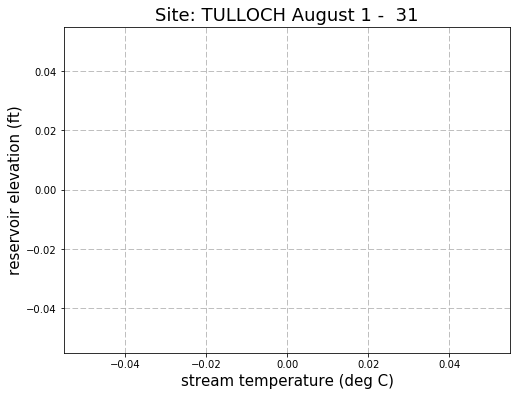

downloading  WHISKEYTOWN DAM (USBR)  data....
RESERVOIR DATA:                value
datetime           
1985-01-01  1198.33
1985-01-02      NaN
1985-01-03      NaN
1985-01-04      NaN
1985-01-05      NaN
res logic:  True release logic True
FIRST DATA MERGE:              res_level  releases
datetime                       
1985-01-01    1198.33       NaN
1985-01-02        NaN       NaN
1985-01-03        NaN       NaN
1985-01-04        NaN       NaN
1985-01-05        NaN       NaN
data INFLOWS A:              value
datetime         
1990-01-01   70.0
1990-01-02   16.0
1990-01-03   35.0
1990-01-04   26.0
1990-01-05   35.0
SECOND DATA MERGE_A1:              res_level  releases  value
datetime                              
1985-01-01    1198.33       NaN    NaN
1985-01-02        NaN       NaN    NaN
1985-01-03        NaN       NaN    NaN
1985-01-04        NaN       NaN    NaN
1985-01-05        NaN       NaN    NaN
SECOND DATA MERGE_A2:              res_level  releases  inflows
datetime       

processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11372000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11372000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11372000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11372000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11372000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11372000
/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:88: FutureWarning: c

              datetime qualifiers value
0  1965-03-26T00:00:00          A   9.4
1  1965-03-27T00:00:00          A   8.9
2  1965-03-28T00:00:00          A   8.9
3  1965-03-29T00:00:00          A   9.4
4  1965-03-30T00:00:00          A   9.4
              datetime qualifiers value
0  1965-03-26T00:00:00          A  11.1
1  1965-03-27T00:00:00          A  11.1
2  1965-03-28T00:00:00          A  11.7
3  1965-03-29T00:00:00          A  11.7
4  1965-03-30T00:00:00          A  10.0
usgs 1 down col names:   Index(['usgs_id_1down'], dtype='object')
usgs 1down head:              usgs_id_1down
datetime                 
1965-03-26          10.25
1965-03-27          10.00
1965-03-28          10.30
1965-03-29          10.55
1965-03-30           9.70
data_merge:              res_level  releases  inflows
datetime                                
1985-01-01    1198.33       NaN      NaN
1985-01-02        NaN       NaN      NaN
1985-01-03        NaN       NaN      NaN
1985-01-04        NaN       NaN     

processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11371000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11371000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11371000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11371000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11371000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11371000


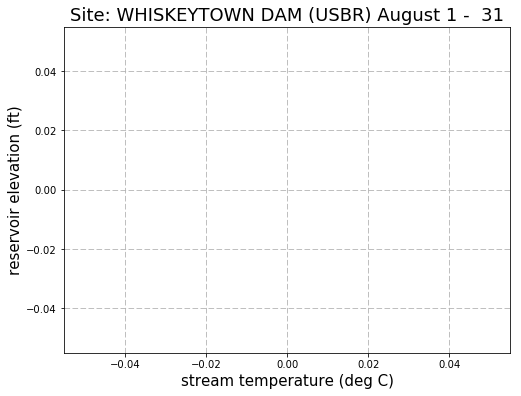

downloading  WARM SPRINGS (USACE)  data....
RESERVOIR DATA:               value
datetime          
1988-08-09  415.34
1988-08-10  415.30
1988-08-11  415.08
1988-08-12  414.91
1988-08-13  414.87
res logic:  True release logic True
FIRST DATA MERGE:              res_level  releases
datetime                       
1988-08-09     415.34       NaN
1988-08-10     415.30       NaN
1988-08-11     415.08       NaN
1988-08-12     414.91       NaN
1988-08-13     414.87       NaN
data INFLOWS A:              value
datetime         
1994-01-01    NaN
1994-01-02   28.0
1994-01-03   43.0
1994-01-04   65.0
1994-01-05   33.0
SECOND DATA MERGE_A1:              res_level  releases  value
datetime                              
1988-08-09     415.34       NaN    NaN
1988-08-10     415.30       NaN    NaN
1988-08-11     415.08       NaN    NaN
1988-08-12     414.91       NaN    NaN
1988-08-13     414.87       NaN    NaN
SECOND DATA MERGE_A2:              res_level  releases  inflows
datetime                

processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465000


              datetime qualifiers value
0  1981-11-04T00:00:00          A  13.5
1  1981-11-05T00:00:00          A  13.8
2  1981-11-06T00:00:00          A  13.9
3  1981-11-07T00:00:00          A  13.8
4  1981-11-08T00:00:00          A  13.6
              datetime qualifiers value
0  1981-11-04T00:00:00          A  14.8
1  1981-11-05T00:00:00          A  14.9
2  1981-11-06T00:00:00          A  15.5
3  1981-11-07T00:00:00          A  15.6
4  1981-11-08T00:00:00          A  15.2
usgs 1 down col names:   Index(['usgs_id_1down'], dtype='object')
usgs 1down head:              usgs_id_1down
datetime                 
1981-11-04          14.15
1981-11-05          14.35
1981-11-06          14.70
1981-11-07          14.70
1981-11-08          14.40
data_merge:              res_level  releases  inflows
datetime                                
1988-08-09     415.34       NaN      NaN
1988-08-10     415.30       NaN      NaN
1988-08-11     415.08       NaN      NaN
1988-08-12     414.91       NaN     

processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465200
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465200
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465200
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465200
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465200
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465200


              datetime qualifiers value
0  1964-11-17T00:00:00          A   8.9
1  1964-11-18T00:00:00          A   8.3
2  1964-11-19T00:00:00          A   8.9
3  1964-11-20T00:00:00          A   8.3
4  1964-11-21T00:00:00          A   8.3
              datetime qualifiers value
0  1964-11-17T00:00:00          A  10.6
1  1964-11-18T00:00:00          A  11.1
2  1964-11-19T00:00:00          A  11.1
3  1964-11-20T00:00:00          A  10.6
4  1964-11-21T00:00:00          A  10.6
usgs id down2 names:  Index(['usgs_id_2down'], dtype='object')
data merge names:  Index(['res_level', 'releases', 'inflows', 'usgs_id_1down', 'usgs_id_2down'], dtype='object')


processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465240
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465240
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11465240
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465240
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465240
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11465240


              datetime qualifiers value
0  2012-05-22T00:00:00          A  12.3
1  2012-05-23T00:00:00          A  12.1
2  2012-05-24T00:00:00          A  11.8
3  2012-05-25T00:00:00          A  11.4
4  2012-05-26T00:00:00          A  11.7
              datetime qualifiers value
0  2012-05-22T00:00:00          A  14.9
1  2012-05-23T00:00:00          A  14.6
2  2012-05-24T00:00:00          A  14.4
3  2012-05-25T00:00:00          A  13.8
4  2012-05-26T00:00:00          A  14.5


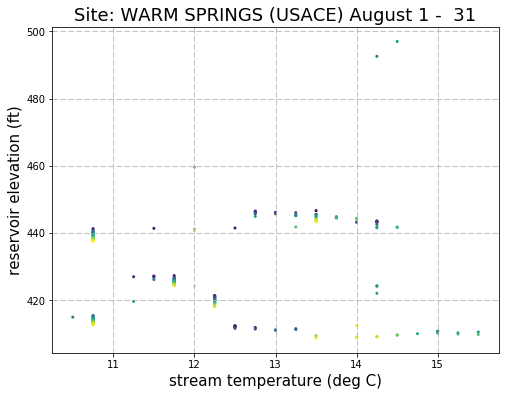

downloading  WISHON  data....
RESERVOIR DATA:              value
datetime         
2014-10-01    NaN
2014-10-02    NaN
2014-10-03    NaN
2014-10-04    NaN
2014-10-05    NaN
res logic:  True release logic False


In [224]:
# ============================================================================================
#       Upload, put together, and write CA data
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)


# for pratice - i = 6 # 6 = "Black Butte" - NEED to just remove indent and run without outside loop
#for i in range(len(CA_reservoir_info)):
for i in range(len(CA_reservoir_info)):
    
    print('downloading ',CA_reservoir_info['name'].ix[i], ' data....')

    #  -------  read in CA Water resources water surface elevation  --------: 
    station_id = CA_reservoir_info['site_code'].ix[i]
    data_res, res_logic =  read_CA_reservoir_data(station_id,6,'daily') # reservoir elevation
    data_release, release_logic =  read_CA_reservoir_data(station_id,23,'daily') #releases (flow)
    data_inflow, inflow_logic =  read_CA_reservoir_data(station_id,76,'daily')  # inflow into reservoir
    print('RESERVOIR DATA: ',data_res.head())
    print('res logic: ',res_logic, 'release logic', release_logic)

    #  ---------------------  combine the data ------------------:
    if res_logic == True:
        if release_logic == True :    
            data_merge = data_res.merge(data_release, how='outer', left_index=True, right_index=True)
            data_merge.columns = ['res_level','releases']
            print('FIRST DATA MERGE: ', data_merge.head())

        if release_logic == True  and inflow_logic == True:
            data_merge = data_merge.merge(data_inflow, how='outer', left_index=True, right_index=True)
            print('data INFLOWS A: ',data_inflow.head())
            print('SECOND DATA MERGE_A1: ', data_merge.head())
            data_merge['inflows'] = data_merge['value']
            data_merge = data_merge.drop('value', axis=1)
            print('SECOND DATA MERGE_A2: ', data_merge.head())
            
        elif inflow_logic == True:
            data_merge = data_merge.merge(data_inflow, how='outer', left_index=True, right_index=True)
            data_merge['inflows'] = data_merge['value']
            data_merge = data_merge.drop('value', axis=1)
            print('SECOND DATA MERGE_B: ', data_merge.head())
            
        # ----------- if no release or inflow data --------------
        if release_logic == False and  inflow_logic == False:
            data_merge = data_res
            data_res.columns = ['res_level']

    #  ----------------  read in USGS data  --------------------
    if CA_reservoir_info['downstream1_USGS'].ix[i] > 0:
        usgs_id_1down = importusgssite_meantemperature(int(CA_reservoir_info['downstream1_USGS'].ix[i]))
        if len(usgs_id_1down) > 1:
            if len(usgs_id_1down.columns) ==1:
                usgs_id_1down.columns = ['usgs_id_1down']
            if len(usgs_id_1down.columns) ==2:
                usgs_id_1down.columns = ['usgs_id_1down', 'A']
            print('usgs 1 down col names:  ', usgs_id_1down.columns)
            print('usgs 1down head: ', usgs_id_1down.head())
            print('data_merge: ', data_merge.head())

            data_merge = data_merge.merge(pd.DataFrame(usgs_id_1down), how='outer', left_index=True, right_index=True)
            if any(data_merge.columns == 'A'):
                data_merge = data_merge.drop('A', axis=1)
            print('data merge names:  ', data_merge.columns)

    if CA_reservoir_info['downstream2_USGS'].ix[i] > 0:
        usgs_id_2down = importusgssite_meantemperature(int(CA_reservoir_info['downstream2_USGS'].ix[i]))
        if len(usgs_id_2down) > 1:
            usgs_id_2down.columns = ['usgs_id_2down']
            print('usgs id down2 names: ', usgs_id_2down.columns)
            data_merge = data_merge.merge(pd.DataFrame(usgs_id_2down['usgs_id_2down']), how='outer', left_index=True, right_index=True)
            if any(data_merge.columns == 'A'):
                data_merge = data_merge.drop('A', axis=1)
            print('data merge names: ', data_merge.columns)

    if CA_reservoir_info['downstream3_USGS'].ix[i] > 0:
        usgs_id_3down = importusgssite_meantemperature(int(CA_reservoir_info['downstream3_USGS'].ix[i]))
        if len(usgs_id_3down) > 1:
            usgs_id_3down.columns = ['usgs_id_3down']
            data_merge = data_merge.merge(usgs_id_3down, how='outer', left_index=True, right_index=True)
            if any(data_merge.columns == 'A'):
                data_merge = data_merge.drop('A', axis=1)

    if CA_reservoir_info['upstream1_USGS'].ix[i] > 0:
        usgs_id_1up = importusgssite_meantemperature(int(CA_reservoir_info['upstream1_USGS'].ix[i]))
        if len(usgs_id_1up) > 1:
            usgs_id_1up.columns = ['usgs_id_1up']
            data_merge = data_merge.merge(usgs_id_1up, how='outer', left_index=True, right_index=True)
            if any(data_merge.columns == 'A'):
                data_merge = data_merge.drop('A', axis=1)

    if CA_reservoir_info['upstream2_USGS'].ix[i] > 0:
        usgs_id_2up = importusgssite_meantemperature(int(CA_reservoir_info['upstream2_USGS'].ix[i]))
        if len(usgs_id_2up) > 1:
            usgs_id_2up.columns = ['usgs_id_2up']
            data_merge = data_merge.merge(usgs_id_2up, how='outer', left_index=True, right_index=True)
            if any(data_merge.columns == 'A'):
                data_merge = data_merge.drop('A', axis=1)

    if CA_reservoir_info['upstream3_USGS'].ix[i] > 0:
        usgs_id_3up = importusgssite_meantemperature(int(CA_reservoir_info['upstream3_USGS'].ix[i]))
        if len(usgs_id_3up) > 1:
            usgs_id_3up.columns = ['usgs_id_3up']
            data_merge = data_merge.merge(usgs_id_3up, how='outer', left_index=True, right_index=True)
            if any(data_merge.columns == 'A'):
                data_merge = data_merge.drop('A', axis=1)

    try:
        data_merge
    except NameError:
        print("only reservoir data!")
        #print(data_res.head())
        #print(data_res.tail())
    else:
        #print(data_merge.head())
        #print(data_merge.tail())

        if CA_reservoir_info['downstream1_USGS'].ix[i] > 0:
            if len(usgs_id_1down) > 1:
                # ------------------- plot ------------------
                day1 = 212 # September 30
                day2 = 243 # August 31
                plt.figure(figsize=[8,6])
                plt.grid(linestyle='--')
                plt.scatter( data_merge.usgs_id_1down[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
                #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
                plt.xlabel('stream temperature (deg C)', fontsize=15)
                plt.ylabel('reservoir elevation (ft)', fontsize=15)
                plt.title('Site: ' + CA_reservoir_info['name'].ix[i]  +' August 1 -  31', fontsize=18)
                #plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])


                plt.show()

In [216]:
usgs_id_1down.tail()

temperature data_quality
dates                               
2017-04-20          8.6            P
2017-04-21          8.7            P
2017-04-22          8.8            P
2017-04-23          8.8            P
2017-04-24          8.9            P

In [214]:
i

49

In [199]:
data_merge.head()

value_x  value_y
datetime                    
1985-01-01    443.3      NaN
1985-01-02      NaN      NaN
1985-01-03      NaN      NaN
1985-01-04      NaN      NaN
1985-01-05      NaN      NaN

In [184]:
i

7

downloading  BOCA RESERVOIR  data....


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=10344500
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=10344500
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=10344500
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=10344500
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=10344500
processing data from request: https://waterservi

              datetime qualifiers value
0  1980-04-19T00:00:00          A   6.6
1  1980-04-20T00:00:00          A   7.0
2  1980-04-21T00:00:00          A   7.3
3  1980-04-22T00:00:00          A   7.3
4  1980-04-23T00:00:00          A   7.3
              datetime qualifiers value
0  1980-04-19T00:00:00          A   8.1
1  1980-04-20T00:00:00          A   8.4
2  1980-04-21T00:00:00          A   8.0
3  1980-04-22T00:00:00          A   7.8
4  1980-04-23T00:00:00          A  10.8
            res_level  inflow  releases  usgs_id_1down_x  usgs_id_2up  \
datetime                                                                
1969-06-03        NaN     NaN       NaN             18.5          NaN   
1969-06-04        NaN     NaN       NaN             19.0          NaN   
1969-06-05        NaN     NaN       NaN             19.5          NaN   
1969-06-06        NaN     NaN       NaN             19.0          NaN   
1969-06-07        NaN     NaN       NaN             19.5          NaN   

        

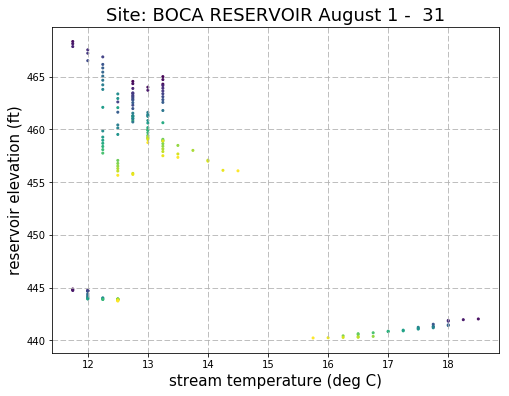

In [185]:
# ============================================================================================
#       Upload, put together, and write CA data
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)


# for pratice - 
i = 6 # 6 = "Black Butte"
i = 7

print('downloading ',CA_reservoir_info['name'].ix[i], ' data....')

#  -------  read in CA Water resources water surface elevation  --------: 
station_id = CA_reservoir_info['site_code'].ix[i]
data_res, res_logic =  read_CA_reservoir_data(station_id,6,'daily') # reservoir elevation
data_release, release_logic =  read_CA_reservoir_data(station_id,23,'daily') #releases (flow)
data_inflow, inflow_logic =  read_CA_reservoir_data(station_id,76,'daily')  # inflow into reservoir

#  ---------------------  combine the data ------------------:
if res_logic == True:
    if release_logic == True :    
        data_merge = data_res.merge(data_inflow, how='outer', left_index=True, right_index=True)
        data_merge.columns = ['res_level','inflow']

    if release_logic == True  and inflow_logic == True:
        data_merge = data_merge.merge(data_release, how='outer', left_index=True, right_index=True)
        data_merge['releases'] = data_merge['value']
        data_merge = data_merge.drop('value', axis=1)

    elif inflow_logic == True:
        data_merge = data_res.merge(data_release, how='outer', left_index=True, right_index=True)
        data_merge['releases'] = data_merge['value']
        data_merge = data_merge.drop('value', axis=1)

#  ----------------  read in USGS data  --------------------
if CA_reservoir_info['downstream1_USGS'].ix[i] > 0:
    usgs_id_1down = importusgssite_meantemperature(int(CA_reservoir_info['downstream1_USGS'].ix[i]))
    if len(usgs_id_1down) > 1:
        usgs_id_1down.columns = ['usgs_id_1down']
        data_merge = data_merge.merge(usgs_id_1down, how='outer', left_index=True, right_index=True)
        if any(data_merge.columns == 'A'):
            data_merge = data_merge.drop('A', axis=1)

if CA_reservoir_info['downstream2_USGS'].ix[i] > 0:
    usgs_id_2down = importusgssite_meantemperature(int(CA_reservoir_info['downstream2_USGS'].ix[i]))
    if len(usgs_id_2down) > 1:
        usgs_id_2down.columns = ['usgs_id_2down']
        data_merge = data_merge.merge(usgs_id_2down['usgs_id_2down'], how='outer', left_index=True, right_index=True)
        if any(data_merge.columns == 'A'):
            data_merge = data_merge.drop('A', axis=1)

if CA_reservoir_info['downstream3_USGS'].ix[i] > 0:
    usgs_id_3down = importusgssite_meantemperature(int(CA_reservoir_info['downstream3_USGS'].ix[i]))
    if len(usgs_id_3down) > 1:
        usgs_id_3down.columns = ['usgs_id_3down']
        data_merge = data_merge.merge(usgs_id_3down, how='outer', left_index=True, right_index=True)
        if any(data_merge.columns == 'A'):
            data_merge = data_merge.drop('A', axis=1)

if CA_reservoir_info['upstream1_USGS'].ix[i] > 0:
    usgs_id_1up = importusgssite_meantemperature(int(CA_reservoir_info['upstream1_USGS'].ix[i]))
    if len(usgs_id_1up) > 1:
        usgs_id_1up.columns = ['usgs_id_1up']
        data_merge = data_merge.merge(usgs_id_1up, how='outer', left_index=True, right_index=True)
        if any(data_merge.columns == 'A'):
            data_merge = data_merge.drop('A', axis=1)

if CA_reservoir_info['upstream2_USGS'].ix[i] > 0:
    usgs_id_2up = importusgssite_meantemperature(int(CA_reservoir_info['upstream2_USGS'].ix[i]))
    if len(usgs_id_2up) > 1:
        usgs_id_2up.columns = ['usgs_id_2up']
        data_merge = data_merge.merge(usgs_id_2up, how='outer', left_index=True, right_index=True)
        if any(data_merge.columns == 'A'):
            data_merge = data_merge.drop('A', axis=1)

if CA_reservoir_info['upstream3_USGS'].ix[i] > 0:
    usgs_id_3up = importusgssite_meantemperature(int(CA_reservoir_info['upstream3_USGS'].ix[i]))
    if len(usgs_id_3up) > 1:
        usgs_id_3up.columns = ['usgs_id_3up']
        data_merge = data_merge.merge(usgs_id_3up, how='outer', left_index=True, right_index=True)
        if any(data_merge.columns == 'A'):
            data_merge = data_merge.drop('A', axis=1)

try:
    data_merge
except NameError:
    print("only reservoir data!")
    print(data_res.head())
    print(data_res.tail())
else:
    print(data_merge.head())
    print(data_merge.tail())

    if CA_reservoir_info['downstream1_USGS'].ix[i] > 0:
        if len(usgs_id_1down) > 1:
            # ------------------- plot ------------------
            day1 = 212 # September 30
            day2 = 243 # August 31
            plt.figure(figsize=[8,6])
            plt.grid(linestyle='--')
            plt.scatter( data_merge.usgs_id_1down[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Site: ' + CA_reservoir_info['name'].ix[i]  +' August 1 -  31', fontsize=18)
            #plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])


            plt.show()

In [174]:
usgs_id_2up = importusgssite_meantemperature(int(CA_reservoir_info['upstream2_USGS'].ix[i]))

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11387000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11387000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11387000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11387000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11387000
processing data from request: https://waterservi

min max with Celsius
              datetime qualifiers value
0  1970-12-01T00:00:00          A   6.5
1  1970-12-02T00:00:00          A   6.0
2  1970-12-03T00:00:00          A   6.0
3  1970-12-04T00:00:00          A   6.0
4  1970-12-05T00:00:00          A   7.0
              datetime qualifiers value
0  1970-12-01T00:00:00          A   8.0
1  1970-12-02T00:00:00          A   8.0
2  1970-12-03T00:00:00          A   7.0
3  1970-12-04T00:00:00          A   8.0
4  1970-12-05T00:00:00          A   8.0


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:88: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [176]:
usgs_id_2up.head()

0
datetime        
1970-12-01  7.25
1970-12-02  7.00
1970-12-03  6.50
1970-12-04  7.00
1970-12-05  7.50

In [169]:
int(CA_reservoir_info['upstream2_USGS'].ix[i])

11387000

In [149]:
data_merge = data_merge.merge(usgs_id_2up, how='outer', left_index=True, right_index=True)

ValueError: can not merge DataFrame with instance of type <class 'tuple'>

In [140]:
pd.to_datetime(datex[0])

Timestamp('1969-06-03 00:00:00')

In [131]:
usgs_id_1down.index[0]

'1969-06-03T00:00:00'

In [118]:
#usgs_id_1down
sitex = int(CA_reservoir_info['downstream1_USGS'].ix[i])

usgs_id_1down = importusgssite_meantemperature(sitex)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&parameterCd=00010&startDT=1851-01-01&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&parameterCd=00011&startDT=1851-01-01&format=waterml&site=11388000
processing data from request: https://waterservi

True True True
there is min and max data
                         0
datetime                  
1969-06-03T00:00:00  18.50
1969-06-04T00:00:00  19.00
1969-06-05T00:00:00  19.50
1969-06-06T00:00:00  19.00
1969-06-07T00:00:00  19.50
1969-06-08T00:00:00  20.00
1969-06-09T00:00:00  19.50
1969-06-10T00:00:00  20.00
1969-06-11T00:00:00  20.00
1969-06-12T00:00:00  20.00
1969-06-13T00:00:00  21.00
1969-06-14T00:00:00  21.00
1969-06-15T00:00:00  21.00
1969-06-16T00:00:00  20.50
1969-06-17T00:00:00  20.50
1969-06-18T00:00:00  21.00
1969-06-19T00:00:00  21.50
1969-06-20T00:00:00  21.50
1969-06-21T00:00:00  21.50
1969-06-22T00:00:00  22.00
1969-06-23T00:00:00  21.50
1969-06-24T00:00:00  21.50
1969-06-25T00:00:00  21.50
1969-06-26T00:00:00  21.50
1969-06-27T00:00:00  22.00
1969-06-28T00:00:00  21.50
1969-06-29T00:00:00  22.50
1969-06-30T00:00:00  22.00
1969-07-01T00:00:00  22.50
1969-07-02T00:00:00  22.50
...                    ...
1994-09-01T00:00:00  24.50
1994-09-02T00:00:00  24.50
1994-09-03T00:

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:85: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [105]:
usgs_id_1down.head()

A
0 NaN

In [70]:
try:
    data_merge
except NameError:
    print("only reservoir data!")
    print(data_res.head())
    print(data_res.tail())
else:
    print(data_merge.head())
    print(data_merge.tail())

only reservoir data!
             value
datetime          
1985-01-01  4993.8
1985-01-02     NaN
1985-01-03     NaN
1985-01-04     NaN
1985-01-05     NaN
              value
datetime           
2017-04-21  5003.56
2017-04-22  5003.52
2017-04-23  5003.52
2017-04-24  5003.54
2017-04-25      NaN


In [59]:
data_release, release_logic =  read_CA_reservoir_data(station_id,23,'daily')

In [63]:
inflow_logic

True

In [53]:
math.isnan(data_inflow.values[0])

True

In [51]:
data_inflow.head()

value
datetime         
1994-01-01    NaN
1994-01-02   13.0
1994-01-03    NaN
1994-01-04   13.0
1994-01-05   13.0

In [33]:
data_inflow =  read_CA_reservoir_data(station_id,76,'daily')
print(data_inflow)

nan


In [17]:
data_inflow =  read_CA_reservoir_data(station_id,76,'daily')

In [ ]:
    

    
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = read_NorWest_data(int(usgs_id_1down))
        data_T_up = read_NorWest_data(int(usgs_id_1up))

        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,pd.DataFrame((data_T*(9/5)+32)), how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
            data_merge['res_level'] = data_merge['value']
            #if len(data_merge) > 1:



In [29]:
i = 6
station_id = CA_reservoir_info['site_code'].ix[i]
data_res =  read_CA_reservoir_data(station_id,6,'daily')
data_release =  read_CA_reservoir_data(station_id,23,'daily')
data_inflow =  read_CA_reservoir_data(station_id,76,'daily')

In [30]:
#  -------  read in temperature from USGS/NorWest --------:

data_merge = data_res.merge(data_inflow, how='outer', left_index=True, right_index=True)
data_merge.columns = ['res_level','inflow']
data_merge = data_merge.merge(data_release, how='outer', left_index=True, right_index=True)
data_merge['releases'] = data_merge['value']
data_merge = data_merge.drop('value', axis=1)
data_merge.tail()

if CA_reservoir_info['downstream1_USGS'].ix[i] > 0:
    usgs_id_1down = importusgssite_meantemperature(int(CA_reservoir_info['downstream1_USGS'].ix[i]))
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_1down, how='outer', left_index=True, right_index=True)
        usgs_id_1down['downstream1_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)
    
if CA_reservoir_info['downstream2_USGS'].ix[i] > 0:
    usgs_id_2down = importusgssite_meantemperature(int(CA_reservoir_info['downstream2_USGS'].ix[i]))
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_2down, how='outer', left_index=True, right_index=True)
        usgs_id_1down['downstream2_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)
        
if CA_reservoir_info['downstream3_USGS'].ix[i] > 0:
    usgs_id_3down = importusgssite_meantemperature(int(CA_reservoir_info['downstream3_USGS'].ix[i]))
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_3down, how='outer', left_index=True, right_index=True)
        usgs_id_1down['downstream3_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)
        
if CA_reservoir_info['upstream1_USGS'].ix[i] > 0:
    usgs_id_1up = importusgssite_meantemperature(int(CA_reservoir_info['upstream1_USGS'].ix[i]))
    print(usgs_id_1up.head())
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_1up, how='outer', left_index=True, right_index=True)
        usgs_id_1down['upstream1_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)
    
if CA_reservoir_info['upstream2_USGS'].ix[i] > 0:
    usgs_id_2up = importusgssite_meantemperature(int(CA_reservoir_info['upstream2_USGS'].ix[i]))
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_2up, how='outer', left_index=True, right_index=True)
        usgs_id_1down['upstream2_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)
    
if CA_reservoir_info['upstream3_USGS'].ix[i] > 0:
    usgs_id_3up = importusgssite_meantemperature(int(CA_reservoir_info['upstream3_USGS'].ix[i]))
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_3up, how='outer', left_index=True, right_index=True)
        usgs_id_1down['upstream3_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)
    

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00001&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservi

    A
0 NaN


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00003&site=11387000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00002&site=11387000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00001&site=11387000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00003&site=11387000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00002&site=11387000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00001&site=11387000&format=waterml


In [38]:
if CA_reservoir_info['downstream1_USGS'].ix[i] > 0:
    usgs_id_1down = importusgssite_meantemperature(int(CA_reservoir_info['downstream1_USGS'].ix[i]))
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_1down, how='outer', left_index=True, right_index=True)
        usgs_id_1down['downstream1_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00001&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservi

In [22]:
CA_reservoir_info['downstream1_USGS'].ix[i]

11388000.0

In [21]:
usgs_id_1down = importusgssite_meantemperature(int(CA_reservoir_info['downstream1_USGS'].ix[i]))

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00001&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservi

KeyError: '00010:00002'

In [23]:
# =============================================================================
#          Function to read in USGS data
# ==============================================================================
siteno = int(CA_reservoir_info['downstream1_USGS'].ix[i])
sitename = {}
# ------ temperature with Celsius ------
sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00003',period="all", methods='all')
# ------ temperature with Fahrenheit ------
sitename2 = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00003',period="all", methods='all')

# loop to see if it is a F or C data, and if there are multipe measurements at one site
if len(sitename) > 0 or len(sitename2) > 0 :
    if len(sitename) == 1:
        sitenameb = pd.DataFrame(sitename['00010:00003']['values'])  # temperature in celsius
        unitsx = 'C'
    if len(sitename) > 1:
        unitsx = 'C'
        for k in sitename:
            sitenameb = pd.DataFrame(sitename[str(k)]['values'])  # temperature in celsius

    if len(sitename2) == 1:
        sitenameb = pd.DataFrame(sitename2['00011:00003']['values'])  # temperature in fahrenheit
        unitsx = 'F'
    if len(sitename2) > 1:
        unitsx = 'F'
        for k in sitename2:
            sitenameb = pd.DataFrame(sitename2[str(k)]['values'])  # temperature in fahrenheit


    # -------- index, clean the data -------
    sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
    sitenameb.set_index(['dates'], inplace=True)
    sitenameb[siteno] = sitenameb['value'].astype(float)
    sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
    sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
    sitenameb = sitenameb.replace('-999999', np.NAN)
    sitenameb = sitenameb.dropna()
    sitenameb.columns = ['temperature', 'data_quality']

    # IF units in Fahrenheit - convert to Celsius
    if unitsx == 'F':
        sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)



# ------------ if no data present or not able to read ---------
if len(sitename) == 0:
    sitenameb = pd.DataFrame(np.nan, index=[0], columns=['A'])


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00003&site=11388000&format=waterml


In [102]:
int(CA_reservoir_info['downstream1_USGS'].ix[i])

11388000

In [13]:
i = 6
CA_reservoir_info.ix[6]
print(int(CA_reservoir_info['downstream1_USGS'].ix[6]))

11388000


In [28]:
usgs_id_1up = importusgssite_meantemperature(int(CA_reservoir_info['downstream1_USGS'].ix[i]))

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00001&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservi

In [104]:
siteno = int(CA_reservoir_info['downstream1_USGS'].ix[i])
print(siteno)

11388000


In [213]:
int(CA_reservoir_info['downstream1_USGS'].ix[i])

11388000

In [217]:
# =============================================================================
#          Function to read in USGS data
# ==============================================================================
siteno = int(CA_reservoir_info['downstream1_USGS'].ix[i])
sitename = {}
# ------ temperature with Celsius ------
sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00001',period="all", methods='all')
# ------ temperature with Fahrenheit ------
#sitename2 = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00003',period="all", methods='all')


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&parameterCd=00010&site=11388000&startDT=1851-01-01&statCd=00001


In [22]:
CA_reservoir_info['downstream1_USGS'].ix[i]

11388000.0

In [26]:
# =============================================================================
#          Function to read in USGS data
# ==============================================================================

siteno = int(CA_reservoir_info['downstream1_USGS'].ix[i])
sitename = {}
# ------ temperature with Celsius ------
sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00003',period="all", methods='all')
# ------ temperature with Celsius - minimum temperature ------
sitename_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00002',period="all", methods='all')
# ------ temperature with Celsius - maximum temperature ------
sitename_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00001',period="all", methods='all')

# ------ temperature with Fahrenheit ------
sitename2 = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00003',period="all", methods='all')
# ------ temperature with Fahrenheit ------
sitename2_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00002',period="all", methods='all')
# ------ temperature with Fahrenheit ------
sitename2_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00001',period="all", methods='all')

#  ----------- loop to see if it is a F or C data, and if there are multipe measurements at one site ------------
if len(sitename) > 0 or len(sitename2) > 0 :
    if len(sitename) == 1:
        sitenameb = pd.DataFrame(sitename['00010:00003']['values'])  # temperature in celsius
        unitsx = 'C'
    if len(sitename) > 1:
        unitsx = 'C'
        for k in sitename:
            sitenameb = pd.DataFrame(sitename[str(k)]['values'])  # temperature in celsius

    if len(sitename2) == 1:
        sitenameb = pd.DataFrame(sitename2['00011:00003']['values'])  # temperature in fahrenheit
        unitsx = 'F'
    if len(sitename2) > 1:
        unitsx = 'F'
        for k in sitename2:
            sitenameb = pd.DataFrame(sitename2[str(k)]['values'])  # temperature in fahrenheit


    # -------- index, clean the data -------
    sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
    sitenameb.set_index(['dates'], inplace=True)
    sitenameb[siteno] = sitenameb['value'].astype(float)
    sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
    sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
    sitenameb = sitenameb.replace('-999999', np.NAN)
    sitenameb = sitenameb.dropna()
    sitenameb.columns = ['temperature', 'data_quality']

    # IF units in Fahrenheit - convert to Celsius
    if unitsx == 'F':
        sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)



#  -------------- loop to see if it there is just min/max data (celsius) ----------------
elif len(sitename_min) > 0 and len(sitename_max) > 0 and (len(sitename) > 0 or len(sitename2) > 0) :
    if len(sitename_max) == 1:
        sitenameb_max = pd.DataFrame(sitename_max['00010:00001']['values'])  # max temperature in celsius
        unitsx_max = 'C'
    if len(sitename_max) > 1:
        unitsx_max = 'C'
        for k in sitename_max:
            sitenameb_max = pd.DataFrame(sitename_max[str(k)]['values'])  # max temperature in celsius

    if len(sitename_min) == 1:
        sitenameb_min = pd.DataFrame(sitename_min['00010:00002']['values'])  # min temperature in celsius
        unitsx_min = 'C'
    if len(sitename_min) > 1:
        unitsx_min = 'C'
        for k in sitename_min:
            sitenameb_min = pd.DataFrame(sitename_min[str(k)]['values'])  # min temperature in celsius

#  -------------- loop to see if it there is just min/max data (fahrenheit) ----------------
elif len(sitename2_min) > 0 and len(sitename2_max) > 0 and (len(sitename) > 0 or len(sitename2) > 0) :
    if len(sitename_max) == 1:
        sitenameb_max = pd.DataFrame(sitename2_max['00011:00001']['values'])  # max temperature in fahrenheit

    if len(sitename2_max) > 1:

        for k in sitename2_max:
            sitenameb_max = pd.DataFrame(sitename2_max[str(k)]['values'])  # max temperature in fahrenheit

    if len(sitename2_min) == 1:
        sitenameb_min = pd.DataFrame(sitename2_min['00011:00002']['values'])  # min temperature in fahrenheit

    if len(sitename2_min) > 1:
        unitsx_min = 'C'
        for k in sitename2_min:
            sitenameb_min = pd.DataFrame(sitename2_min[str(k)]['values'])  # min temperature in fahrenheit

    # IF units in Fahrenheit - convert to Celsius
    sitenameb_max.temperature = (sitenameb_max.temperature - 32) * (5/9)
    sitenameb_min.temperature = (sitenameb_min.temperature - 32) * (5/9)
        
        
    if len(sitenameb_max) > 1 and len(sitenameb_min) > 1:
        sitenameb_min = sitenameb_min.set_index(sitenameb_min['datetime'])
        sitenameb_max = sitenameb_max.set_index(sitenameb_max['datetime'])
        sitenameb = sitenameb_max.merge(sitenameb_min, how='inner', left_index=True, right_index=True)
        sitenameb = sitenameb[['value_x','value_y']]
        sitenameb = sitenameb.convert_objects(convert_numeric=True)
        sitenameb = sitenameb.mean(axis=1)


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&statCd=00001&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00003&site=11388000&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&statCd=00002&site=11388000&format=waterml
processing data from request: https://waterservi

In [25]:
sitenameb_max

NameError: name 'sitenameb_max' is not defined

In [112]:
# =============================================================================
#          Function to read in USGS data
# ==============================================================================

sitename = {}

# ------ temperature with Celsius ------
sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00003',period="all", methods='all')
# ------ temperature with Celsius - minimum temperature ------
sitename_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00002',period="all", methods='all')
# ------ temperature with Celsius - maximum temperature ------
sitename_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00001',period="all", methods='all')

# ------ temperature with Fahrenheit ------
sitename2 = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00003',period="all", methods='all')
# ------ temperature with Fahrenheit ------
sitename2_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00002',period="all", methods='all')
# ------ temperature with Fahrenheit ------
sitename2_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00001',period="all", methods='all')

#  ----------- loop to see if it is a F or C data, and if there are multipe measurements at one site ------------
if len(sitename) > 0 or len(sitename2) > 0 :
    if len(sitename) == 1:
        sitenameb = pd.DataFrame(sitename['00010:00003']['values'])  # temperature in celsius
        unitsx = 'C'
    if len(sitename) > 1:
        unitsx = 'C'
        for k in sitename:
            sitenameb = pd.DataFrame(sitename[str(k)]['values'])  # temperature in celsius

    if len(sitename2) == 1:
        sitenameb = pd.DataFrame(sitename2['00011:00003']['values'])  # temperature in fahrenheit
        unitsx = 'F'
    if len(sitename2) > 1:
        unitsx = 'F'
        for k in sitename2:
            sitenameb = pd.DataFrame(sitename2[str(k)]['values'])  # temperature in fahrenheit


    # -------- index, clean the data -------
    sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
    sitenameb.set_index(['dates'], inplace=True)
    sitenameb[siteno] = sitenameb['value'].astype(float)
    sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
    sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
    sitenameb = sitenameb.replace('-999999', np.NAN)
    sitenameb = sitenameb.dropna()
    sitenameb.columns = ['temperature', 'data_quality']

    # IF units in Fahrenheit - convert to Celsius
    if unitsx == 'F':
        sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)

    sitenameb = pd.DataFrame(sitenameb)


#  -------------- loop to see if it there is just min/max data (celsius) ----------------
elif len(sitename_min) > 0 and len(sitename_max) > 0 and (len(sitename) > 0 or len(sitename2) > 0) :
    if len(sitename_max) == 1:
        sitenameb_max = pd.DataFrame(sitename_max['00010:00001']['values'])  # max temperature in celsius
        unitsx_max = 'C'
    if len(sitename_max) > 1:
        unitsx_max = 'C'
        for k in sitename_max:
            sitenameb_max = pd.DataFrame(sitename_max[str(k)]['values'])  # max temperature in celsius

    if len(sitename_min) == 1:
        sitenameb_min = pd.DataFrame(sitename_min['00010:00002']['values'])  # min temperature in celsius
        unitsx_min = 'C'
    if len(sitename_min) > 1:
        unitsx_min = 'C'
        for k in sitename_min:
            sitenameb_min = pd.DataFrame(sitename_min[str(k)]['values'])  # min temperature in celsius

    # --------------- get mean value between min and max temperature --------
    sitenameb_min = sitenameb_min.set_index(sitenameb_min['datetime'])
    sitenameb_max = sitenameb_max.set_index(sitenameb_max['datetime'])
    sitenameb = sitenameb_max.merge(sitenameb_min, how='inner', left_index=True, right_index=True)
    sitenameb = sitenameb[['value_x','value_y']]
    sitenameb = sitenameb.convert_objects(convert_numeric=True)
    sitenameb = sitenameb.mean(axis=1)

    sitenameb = pd.DataFrame(sitenameb)


#  -------------- loop to see if it there is just min/max data (fahrenheit) ----------------
elif len(sitename2_min) > 0 and len(sitename2_max) > 0 and (len(sitename) > 0 or len(sitename2) > 0) :
    if len(sitename_max) == 1:
        sitenameb_max = pd.DataFrame(sitename2_max['00011:00001']['values'])  # max temperature in fahrenheit

    if len(sitename2_max) > 1:

        for k in sitename2_max:
            sitenameb_max = pd.DataFrame(sitename2_max[str(k)]['values'])  # max temperature in fahrenheit

    if len(sitename2_min) == 1:
        sitenameb_min = pd.DataFrame(sitename2_min['00011:00002']['values'])  # min temperature in fahrenheit

    if len(sitename2_min) > 1:
        unitsx_min = 'C'
        for k in sitename2_min:
            sitenameb_min = pd.DataFrame(sitename2_min[str(k)]['values'])  # min temperature in fahrenheit

    # IF units in Fahrenheit - convert to Celsius
    sitenameb_max.temperature = (sitenameb_max.temperature - 32) * (5/9)
    sitenameb_min.temperature = (sitenameb_min.temperature - 32) * (5/9)

    # --------------- get mean value between min and max temperature --------
    sitenameb_min = sitenameb_min.set_index(sitenameb_min['datetime'])
    sitenameb_max = sitenameb_max.set_index(sitenameb_max['datetime'])
    sitenameb = sitenameb_max.merge(sitenameb_min, how='inner', left_index=True, right_index=True)
    sitenameb = sitenameb[['value_x','value_y']]
    sitenameb = sitenameb.convert_objects(convert_numeric=True)
    sitenameb = sitenameb.mean(axis=1)

    sitenameb = pd.DataFrame(sitenameb)





/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&startDT=1851-01-01&parameterCd=00010&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&startDT=1851-01-01&parameterCd=00010&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00001&startDT=1851-01-01&parameterCd=00010&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00003&startDT=1851-01-01&parameterCd=00011&format=waterml&site=11388000
processing data from request: https://waterservices.usgs.gov/nwis/dv/?statCd=00002&startDT=1851-01-01&parameterCd=00011&format=waterml&site=11388000
processing data from request: https://waterservi

In [118]:
pd.DataFrame(sitenameb).head()

0
datetime                 
1969-06-03T00:00:00  18.5
1969-06-04T00:00:00  19.0
1969-06-05T00:00:00  19.5
1969-06-06T00:00:00  19.0
1969-06-07T00:00:00  19.5

In [119]:
data_merge.head()

res_level  inflow  releases
datetime                               
1985-01-01      443.3     NaN       NaN
1985-01-02        NaN     NaN       NaN
1985-01-03        NaN     NaN       NaN
1985-01-04        NaN     NaN       NaN
1985-01-05        NaN     NaN       NaN

In [116]:
data_merge.merge(pd.DataFrame(sitenameb))

MergeError: No common columns to perform merge on

In [27]:
#  ----------- loop to see if it is a F or C data, and if there are multipe measurements at one site ------------
if len(sitename) > 0 or len(sitename2) > 0 :
    if len(sitename) == 1:
        sitenameb = pd.DataFrame(sitename['00010:00003']['values'])  # temperature in celsius
        unitsx = 'C'
    if len(sitename) > 1:
        unitsx = 'C'
        for k in sitename:
            sitenameb = pd.DataFrame(sitename[str(k)]['values'])  # temperature in celsius

    if len(sitename2) == 1:
        sitenameb = pd.DataFrame(sitename2['00011:00003']['values'])  # temperature in fahrenheit
        unitsx = 'F'
    if len(sitename2) > 1:
        unitsx = 'F'
        for k in sitename2:
            sitenameb = pd.DataFrame(sitename2[str(k)]['values'])  # temperature in fahrenheit


    # -------- index, clean the data -------
    sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
    sitenameb.set_index(['dates'], inplace=True)
    sitenameb[siteno] = sitenameb['value'].astype(float)
    sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
    sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
    sitenameb = sitenameb.replace('-999999', np.NAN)
    sitenameb = sitenameb.dropna()
    sitenameb.columns = ['temperature', 'data_quality']

    # IF units in Fahrenheit - convert to Celsius
    if unitsx == 'F':
        sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)



#  -------------- loop to see if it is a F or C data, and if there are multipe measurements at one site
elif len(sitename_min) > 0 and len(sitename_max) > 0 :
    if len(sitename_max) == 1:
        sitenameb_max = pd.DataFrame(sitename_max['00010:00001']['values'])  # max temperature in celsius
        unitsx = 'C'
    if len(sitename_max) > 1:
        unitsx = 'C'
        for k in sitename_max:
            sitenameb_max = pd.DataFrame(sitename_max[str(k)]['values'])  # max temperature in celsius

    if len(sitename_min) == 1:
        sitenameb_min = pd.DataFrame(sitename_min['00010:00002']['values'])  # min temperature in celsius
        unitsx = 'F'
    if len(sitename_min) > 1:
        unitsx = 'F'
        for k in sitename_min:
            sitenameb_min = pd.DataFrame(sitename_min[str(k)]['values'])  # min temperature in celsius

if len(sitenameb_max) > 1 and len(sitenameb_min) > 1:
    sitenameb_min = sitenameb_min.set_index(sitenameb_min['datetime'])
    sitenameb_max = sitenameb_max.set_index(sitenameb_max['datetime'])
    sitenameb = sitenameb_max.merge(sitenameb_min, how='inner', left_index=True, right_index=True)
    sitenameb = sitenameb[['value_x','value_y']]
    sitenameb = sitenameb.convert_objects(convert_numeric=True)
    sitenameb = sitenameb.mean(axis=1)
    #sitenameb = sitenameb.mean(axis=1)


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:6: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


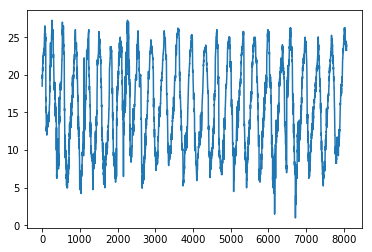

In [72]:
plt.plot(sitenameb.values)

In [ ]:
    if len(sitenameb_max) > 1 and len(sitenameb_min) > 1:



    # -------- index, clean the data -------
    sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
    sitenameb.set_index(['dates'], inplace=True)
    sitenameb[siteno] = sitenameb['value'].astype(float)
    sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
    sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
    sitenameb = sitenameb.replace('-999999', np.NAN)
    sitenameb = sitenameb.dropna()
    sitenameb.columns = ['temperature', 'data_quality']

    # IF units in Fahrenheit - convert to Celsius
    if unitsx == 'F':
        sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)





In [ ]:
# =============================================================================
#          Function to read in USGS data
# ==============================================================================

def importusgssite_meantemperature(siteno):
    sitename = {}
    # ------ temperature with Celsius ------
    sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00003',period="all", methods='all')
    # ------ temperature with Fahrenheit ------
    sitename2 = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00003',period="all", methods='all')

    # loop to see if it is a F or C data, and if there are multipe measurements at one site
    if len(sitename) > 0 or len(sitename2) > 0 :
        if len(sitename) == 1:
            sitenameb = pd.DataFrame(sitename['00010:00003']['values'])  # temperature in celsius
            unitsx = 'C'
        if len(sitename) > 1:
            unitsx = 'C'
            for k in sitename:
                sitenameb = pd.DataFrame(sitename[str(k)]['values'])  # temperature in celsius

        if len(sitename2) == 1:
            sitenameb = pd.DataFrame(sitename2['00011:00003']['values'])  # temperature in fahrenheit
            unitsx = 'F'
        if len(sitename2) > 1:
            unitsx = 'F'
            for k in sitename2:
                sitenameb = pd.DataFrame(sitename2[str(k)]['values'])  # temperature in fahrenheit


        # -------- index, clean the data -------
        sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
        sitenameb.set_index(['dates'], inplace=True)
        sitenameb[siteno] = sitenameb['value'].astype(float)
        sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
        sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
        sitenameb = sitenameb.replace('-999999', np.NAN)
        sitenameb = sitenameb.dropna()
        sitenameb.columns = ['temperature', 'data_quality']
        
        # IF units in Fahrenheit - convert to Celsius
        if unitsx == 'F':
            sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)
            
        return sitenameb
    
    # ------------ if no data present or not able to read ---------
    if len(sitename) == 0:
        sitenameb = pd.DataFrame(np.nan, index=[0], columns=['A'])
        return sitenameb

In [ ]:
if CA_reservoir_info['upstream1_USGS'].ix[i] > 0:
    usgs_id_1up = importusgssite_meantemperature(int(CA_reservoir_info['upstream1_USGS'].ix[i]))
    print(usgs_id_1up.head())
    if len(usgs_id_1down) > 1:
        data_merge = data_merge.merge(usgs_id_1up, how='outer', left_index=True, right_index=True)
        usgs_id_1down['upstream1_USGS'] = usgs_id_1down['A']
        data_merge = data_merge.drop('A', axis=1)


In [184]:
len(usgs_id_1down)

1

In [188]:
data_merge.head()

res_level  inflow  releases
datetime                               
1985-01-01     996.01     NaN       NaN
1985-01-02        NaN     NaN       NaN
1985-01-03        NaN     NaN       NaN
1985-01-04        NaN     NaN       NaN
1985-01-05        NaN     NaN       NaN

In [182]:
CA_reservoir_info.ix[i]

site_code                   BER
upstream1_USGS      1.14536e+07
upstream2_USGS      1.14535e+07
upstream3_USGS              NaN
downstream1_USGS     1.1454e+07
downstream2_USGS            NaN
downstream3_USGS            NaN
upstream1_NW                NaN
upstream2_NW                NaN
upstream3_NW                NaN
downstream1_NW              NaN
downstream2_NW              NaN
downstream3_NW              NaN
upstream_dam                NaN
reservoir_temp              NaN
dam_completed              1958
Notes                       NaN
lat                      38.513
lon                    -122.104
name                  BERRYESSA
site_no                     BER
Name: 3, dtype: object

In [49]:
station_id = 'SHA'
data_res =  read_CA_reservoir_data(station_id,6,'daily')
data_release =  read_CA_reservoir_data(station_id,23,'daily')
data_inflow =  read_CA_reservoir_data(station_id,76,'daily')

In [79]:
station_id = 'ORO'
data_res_o =  read_CA_reservoir_data(station_id,6,'daily')
data_release_o =  read_CA_reservoir_data(station_id,23,'daily')
data_inflow_o =  read_CA_reservoir_data(station_id,76,'daily')


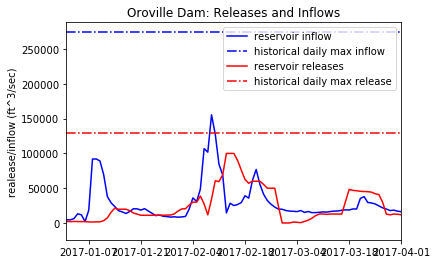

In [80]:
plt.plot(data_inflow_o, 'blue', label='reservoir inflow')
plt.axhline(np.max(data_inflow_o)[0], color='blue', linestyle='dashdot', label='historical daily max inflow')
plt.plot(data_release_o, 'red', label='reservoir releases')
plt.axhline(np.max(data_release_o)[0], color='red', linestyle='dashdot', label='historical daily max release')
plt.title('Oroville Dam: Releases and Inflows')
plt.xlim(['2017','2017-04'])
plt.ylabel('realease/inflow (ft^3/sec)')
plt.legend()

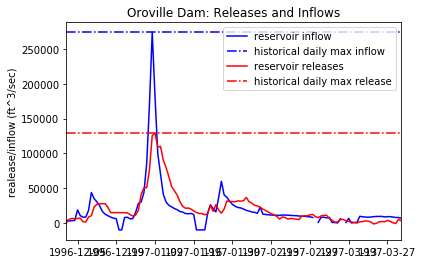

In [86]:
plt.plot(data_inflow_o, 'blue', label='reservoir inflow')
plt.axhline(np.max(data_inflow_o)[0], color='blue', linestyle='dashdot', label='historical daily max inflow')
plt.plot(data_release_o, 'red', label='reservoir releases')
plt.axhline(np.max(data_release_o)[0], color='red', linestyle='dashdot', label='historical daily max release')
plt.title('Oroville Dam: Releases and Inflows')
plt.xlim(['1996-12','1997-04'])
plt.ylabel('realease/inflow (ft^3/sec)')
plt.legend()

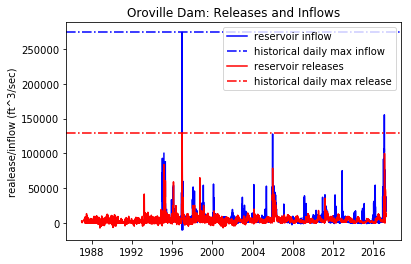

In [81]:
plt.plot(data_inflow_o, 'blue', label='reservoir inflow')
plt.axhline(np.max(data_inflow_o)[0], color='blue', linestyle='dashdot', label='historical daily max inflow')
plt.plot(data_release_o, 'red', label='reservoir releases')
plt.axhline(np.max(data_release_o)[0], color='red', linestyle='dashdot', label='historical daily max release')
plt.title('Oroville Dam: Releases and Inflows')
#plt.xlim(['2017','2017-04'])
plt.ylabel('realease/inflow (ft^3/sec)')
plt.legend()

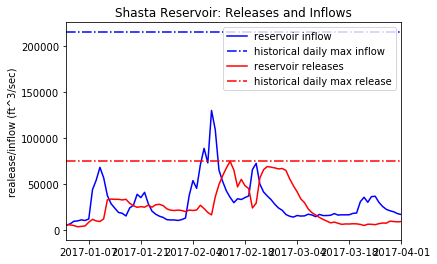

In [78]:
plt.plot(data_inflow, 'blue', label='reservoir inflow')
plt.axhline(np.max(data_inflow)[0], color='blue', linestyle='dashdot', label='historical daily max inflow')
plt.plot(data_release, 'red', label='reservoir releases')
plt.axhline(np.max(data_release)[0], color='red', linestyle='dashdot', label='historical daily max release')
plt.title('Shasta Reservoir: Releases and Inflows')
plt.xlim(['2017','2017-04'])
plt.ylabel('realease/inflow (ft^3/sec)')
plt.legend()

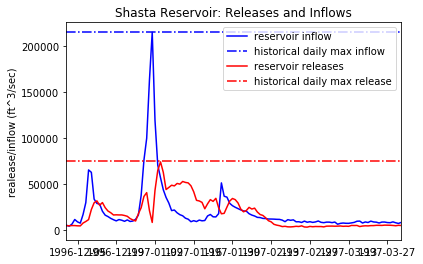

In [85]:
plt.plot(data_inflow, 'blue', label='reservoir inflow')
plt.axhline(np.max(data_inflow)[0], color='blue', linestyle='dashdot', label='historical daily max inflow')
plt.plot(data_release, 'red', label='reservoir releases')
plt.axhline(np.max(data_release)[0], color='red', linestyle='dashdot', label='historical daily max release')
plt.title('Shasta Reservoir: Releases and Inflows')
plt.xlim(['1996-12','1997-04'])
plt.ylabel('realease/inflow (ft^3/sec)')
plt.legend()

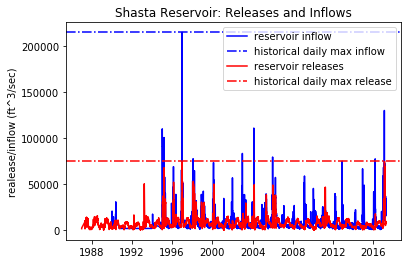

In [82]:
plt.plot(data_inflow, 'blue', label='reservoir inflow')
plt.axhline(np.max(data_inflow)[0], color='blue', linestyle='dashdot', label='historical daily max inflow')
plt.plot(data_release, 'red', label='reservoir releases')
plt.axhline(np.max(data_release)[0], color='red', linestyle='dashdot', label='historical daily max release')
plt.title('Shasta Reservoir: Releases and Inflows')
plt.ylabel('realease/inflow (ft^3/sec)')
plt.legend()

(735964.0, 736695.0)

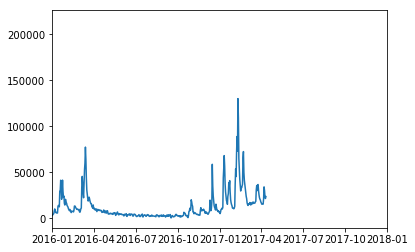

In [61]:
plt.plot(data_inflow)
plt.xlim(['2016','2018'])

# ============================================================================================
#       Loops to plot all the reservoirs with info
# ============================================================================================


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


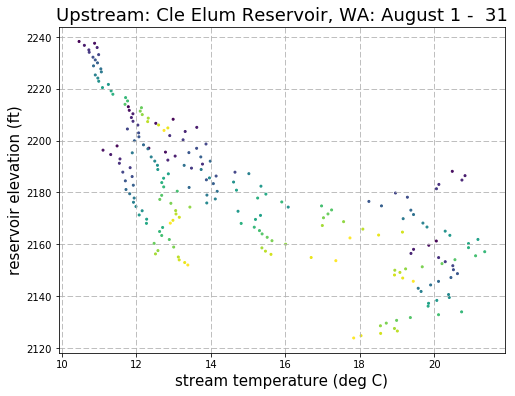

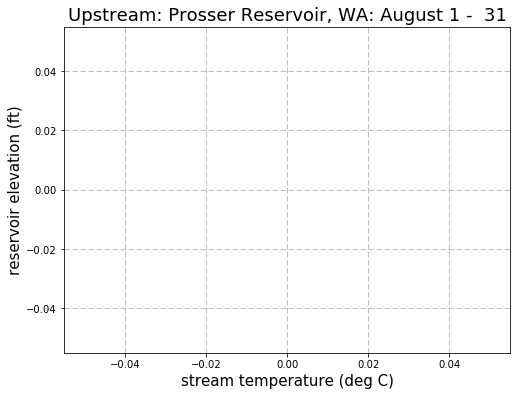

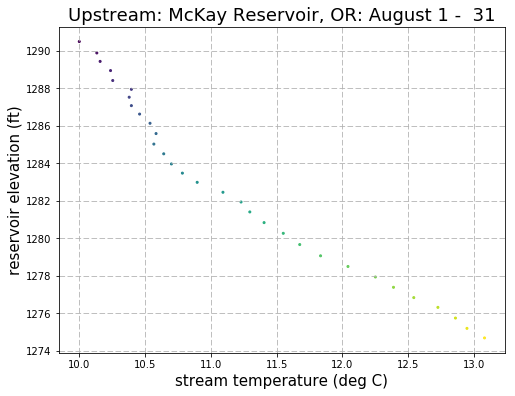

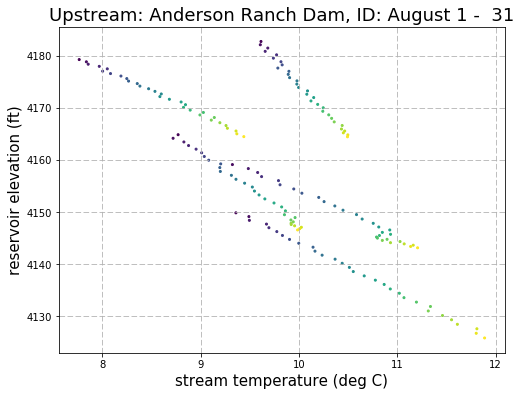

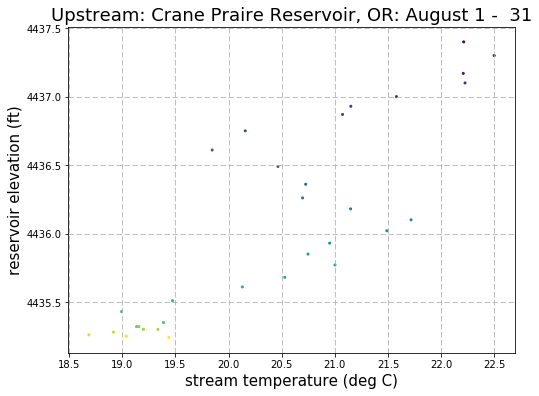

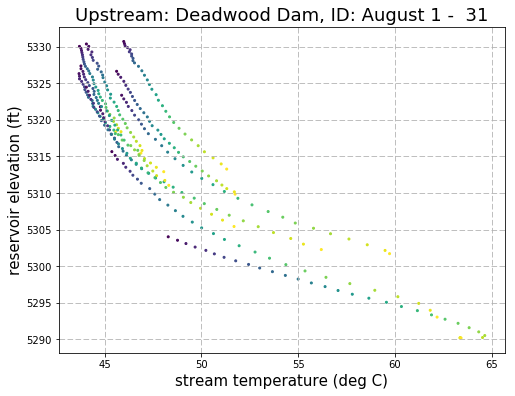

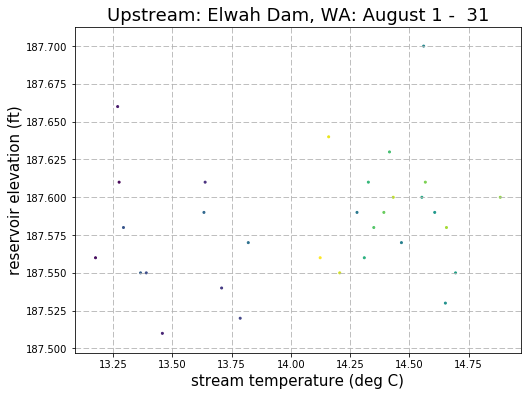

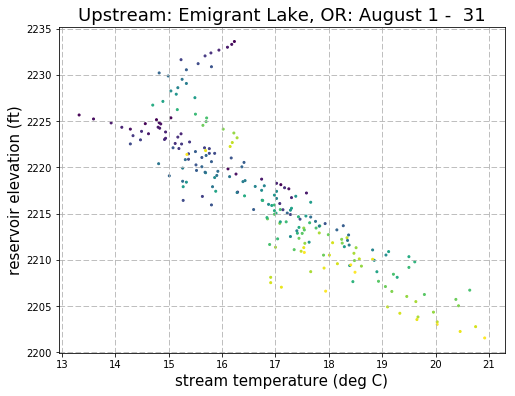

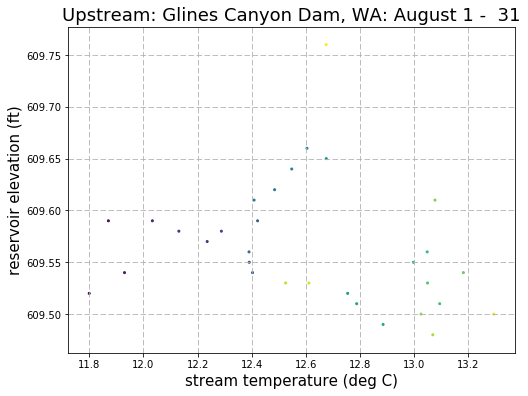

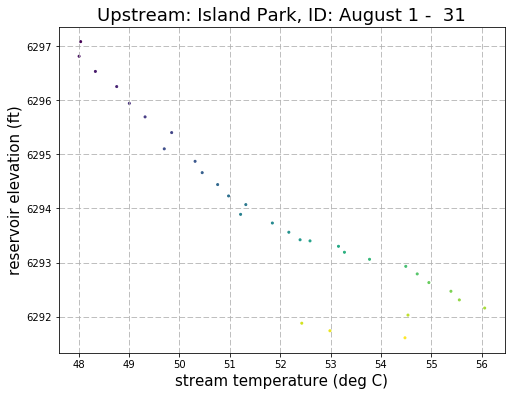

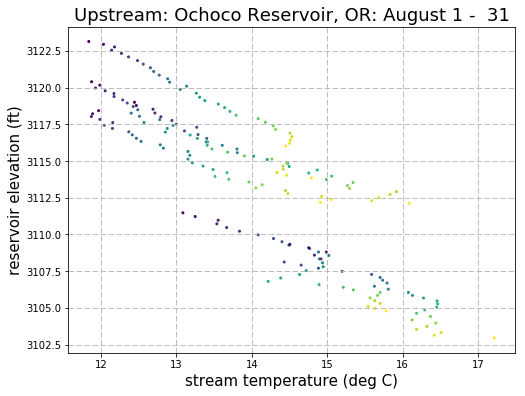

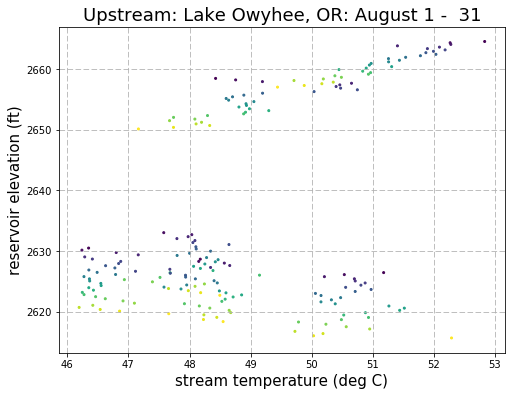

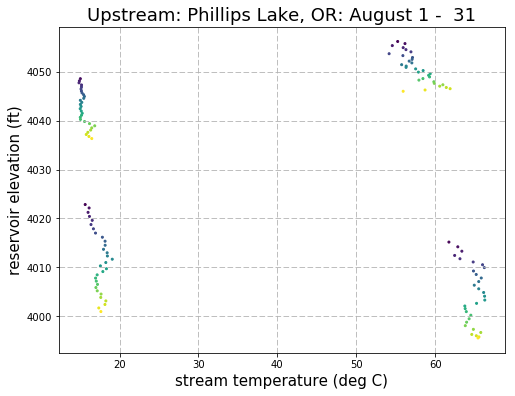

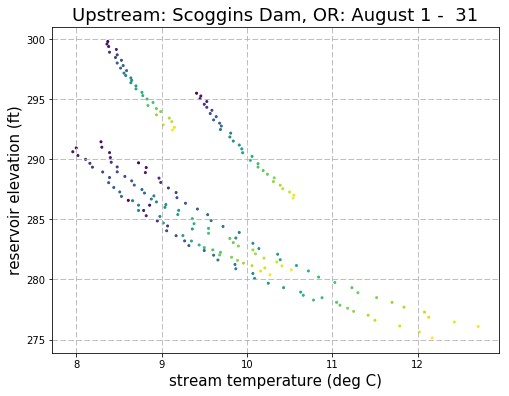

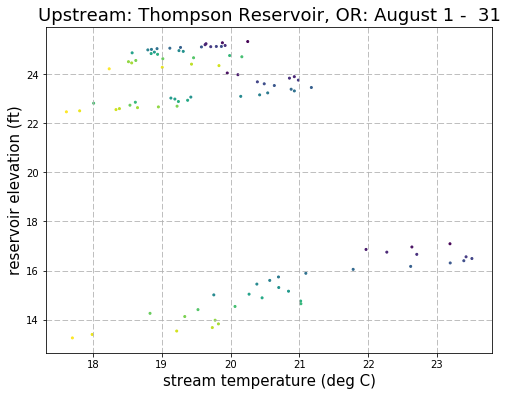

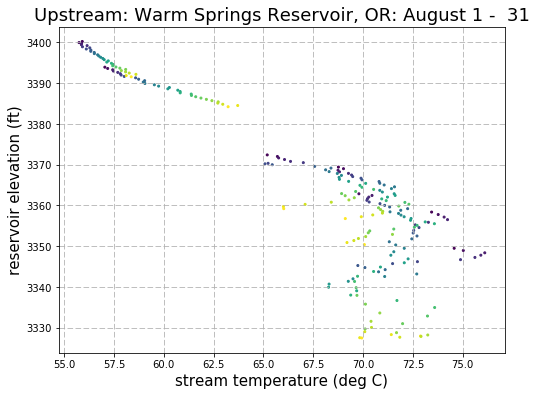

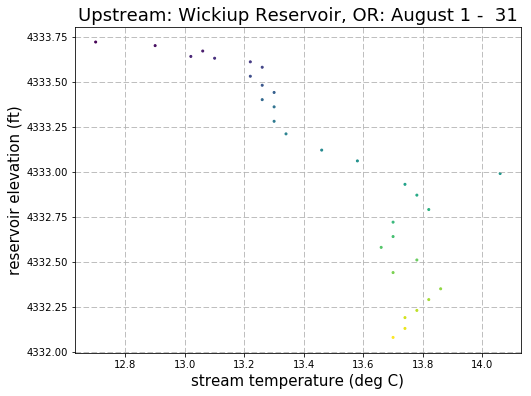

In [130]:
# ============================================================================================
#       Plot NorWest Data
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_norwest)):
#for i in reservoirs_temp_norwest.ix[32]:
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_norwest['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_norwest['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_norwest['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = read_NorWest_data(int(usgs_id_1down))
        data_T_up = read_NorWest_data(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
            
            # ------------------- plot ------------------
            day1 = 212 # September 30
            day2 = 243 # August 31
            plt.figure(figsize=[8,6])
            plt.grid(linestyle='--')
            plt.scatter( data_merge.DAILYMEAN[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Upstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)
            #plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

            
            plt.show()
    
    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


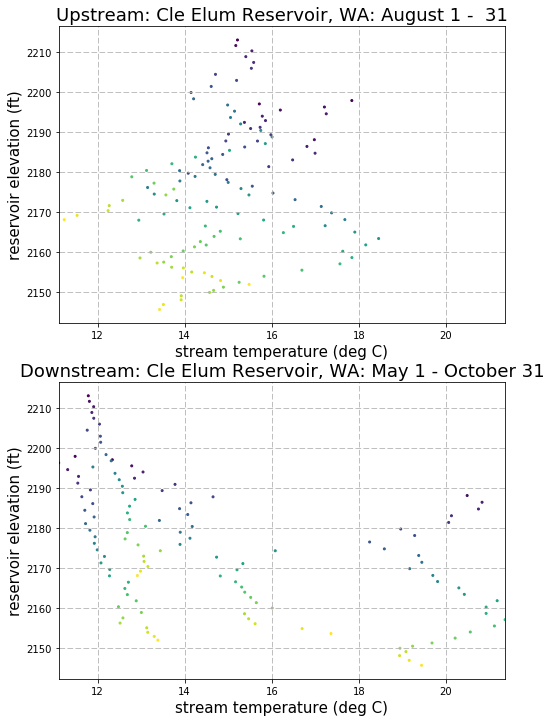

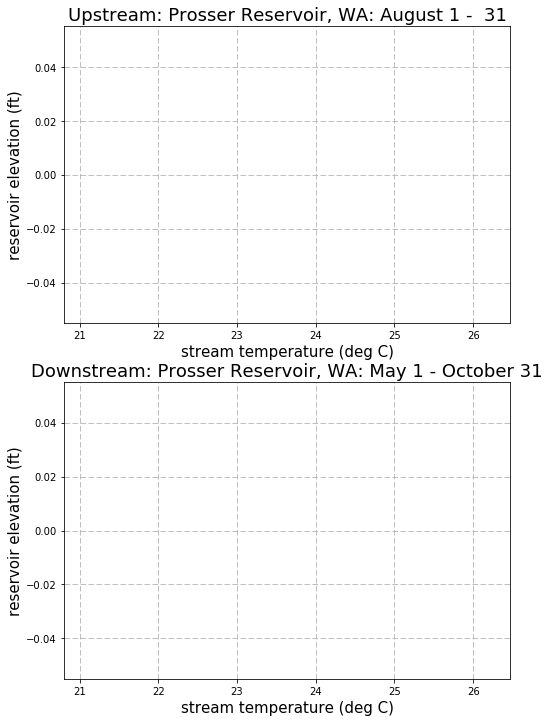

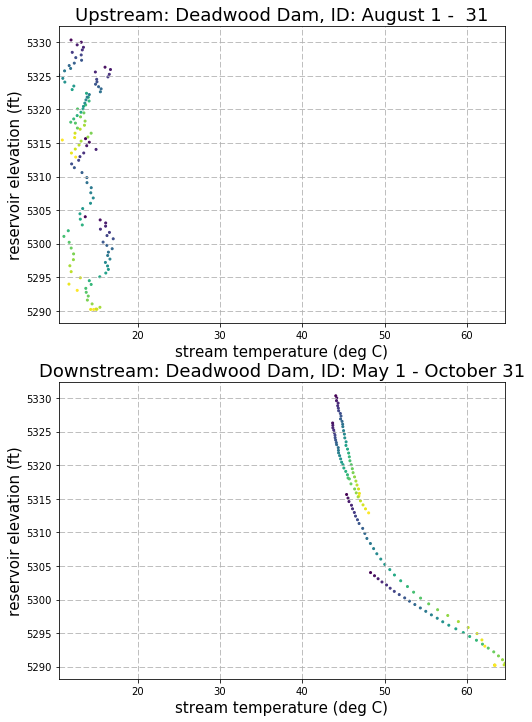

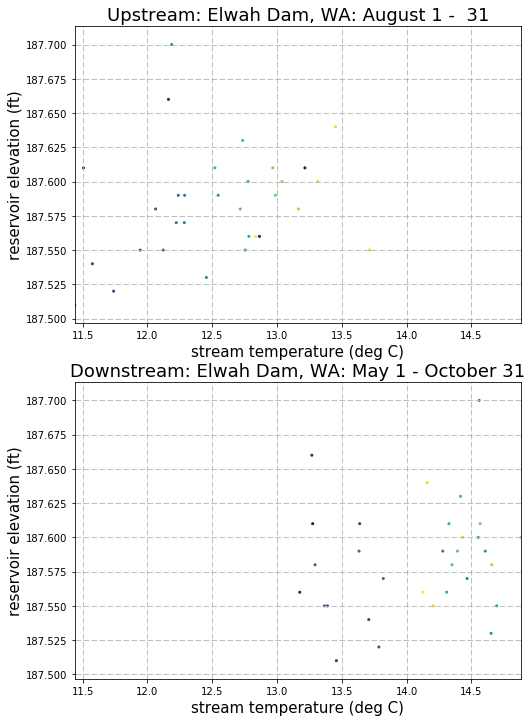

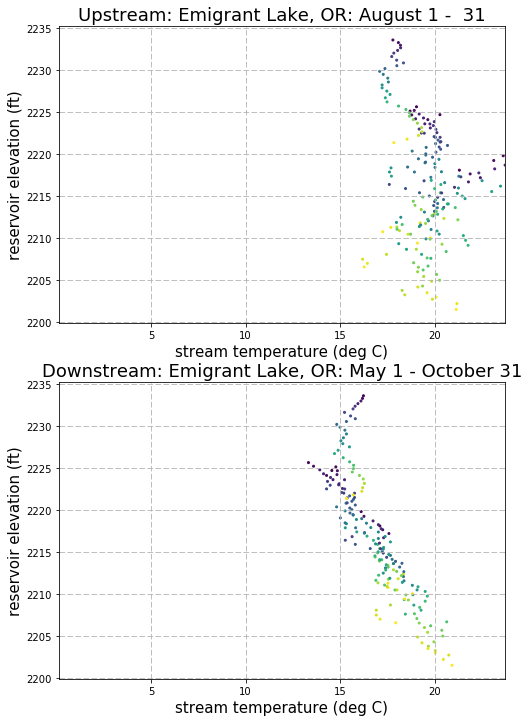

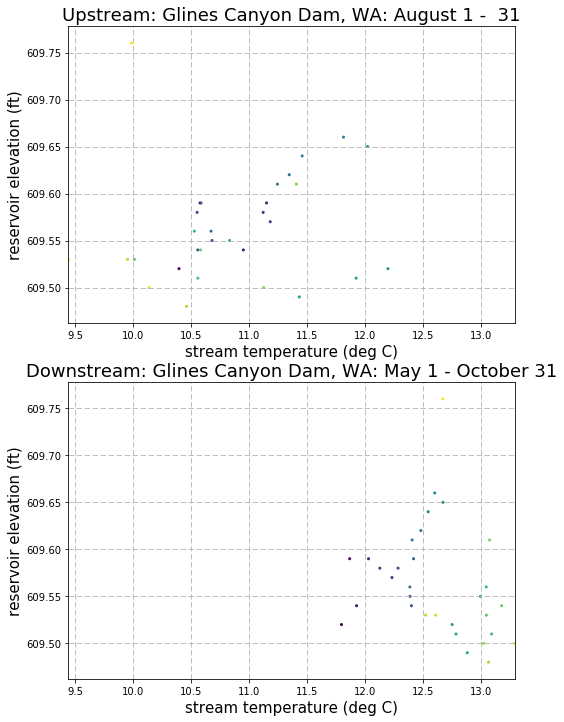

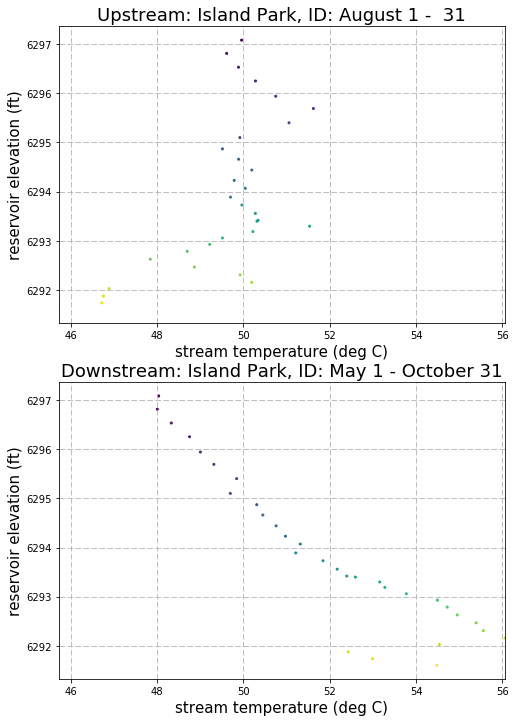

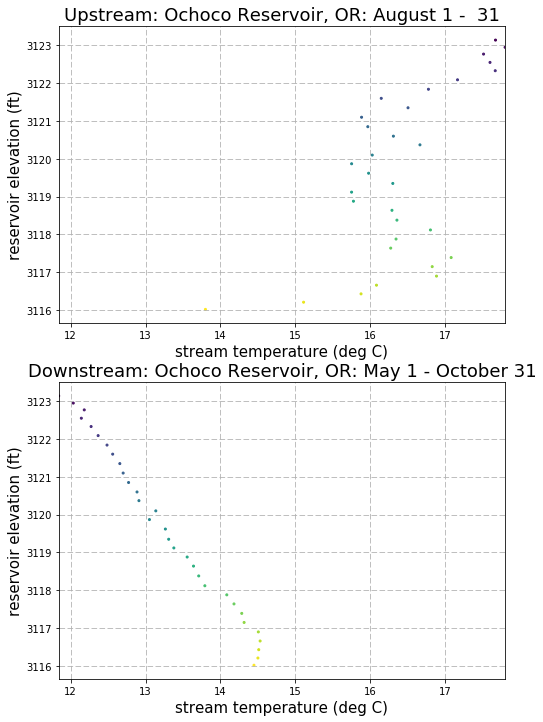

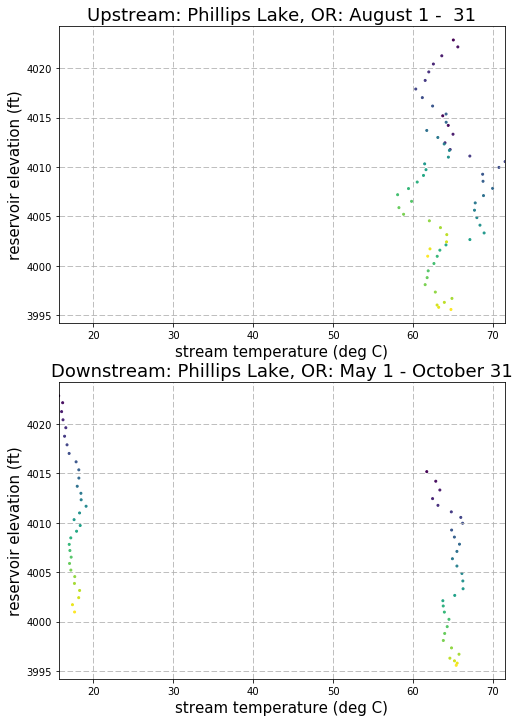

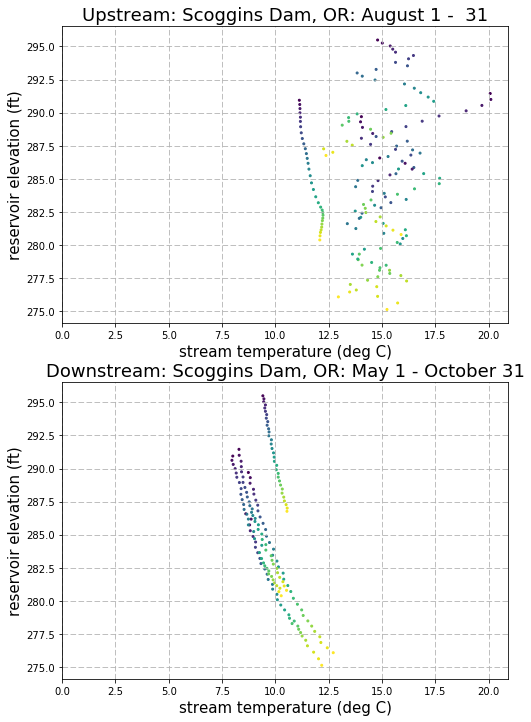

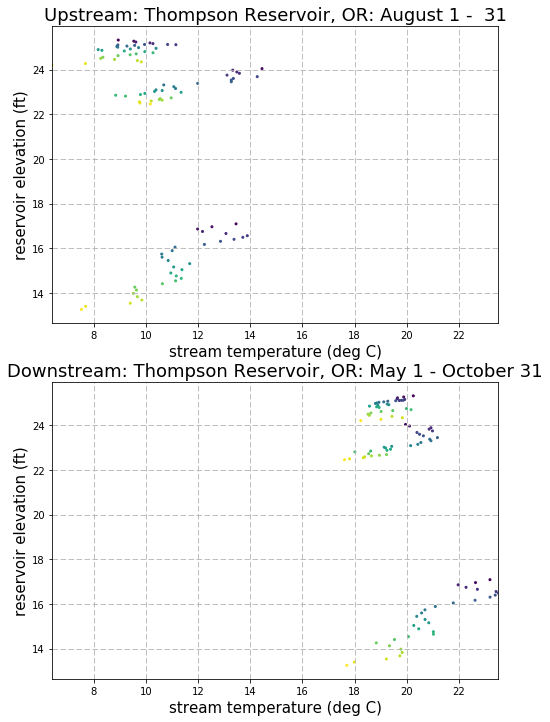

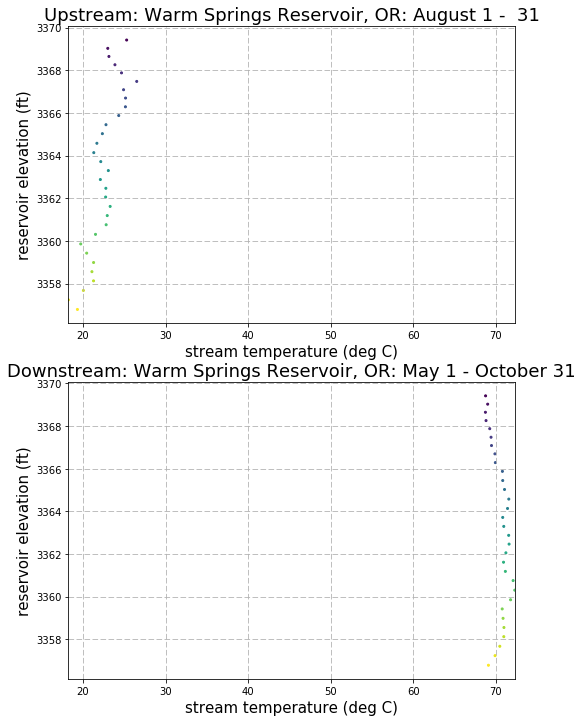

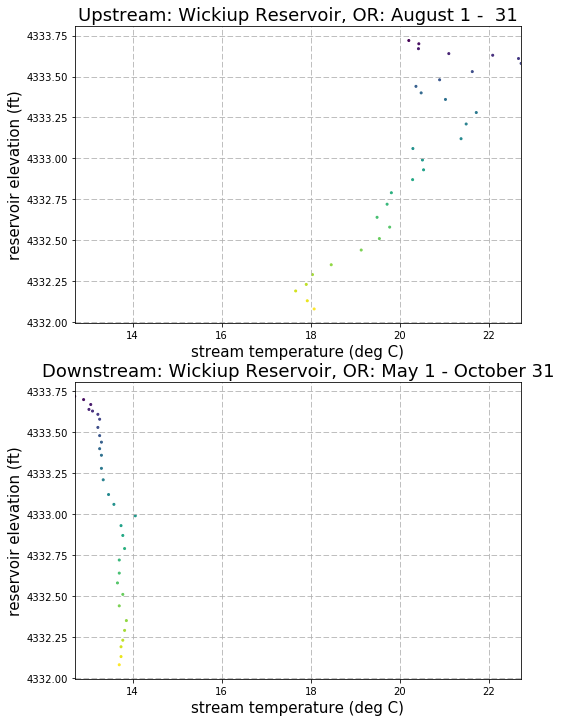

In [19]:
# ============================================================================================
#       Plot NorWest Data
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_norwest)):
#for i in reservoirs_temp_norwest.ix[32]:
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_norwest['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_norwest['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_norwest['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = read_NorWest_data(int(usgs_id_1down))
        data_T_up = read_NorWest_data(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
            if len(data_merge) > 1:
            
                # ------------------- plot ------------------
                day1 = 212 # September 30
                day2 = 243 # August 31
                plt.figure(figsize=[8,12])
                plt.subplot(211)
                plt.grid(linestyle='--')
                plt.scatter( data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

                #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
                plt.xlabel('stream temperature (deg C)', fontsize=15)
                plt.ylabel('reservoir elevation (ft)', fontsize=15)
                plt.title('Upstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)
                plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y]), np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])])


                plt.subplot(212)            
                plt.grid(linestyle='--')
                plt.scatter( data_merge.DAILYMEAN_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

                #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
                plt.xlabel('stream temperature (deg C)', fontsize=15)
                plt.ylabel('reservoir elevation (ft)', fontsize=15)
                plt.title('Downstream: ' +   reservoirs_temp_usgs['name'].ix[i] + ", " + reservoirs_temp_usgs['state'].ix[i] + ': May 1 - October 31', fontsize=18)
                plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y]), np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])])


                plt.show()
    
    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


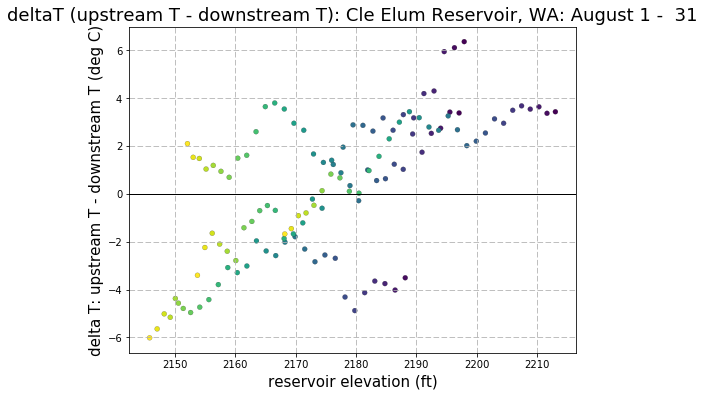

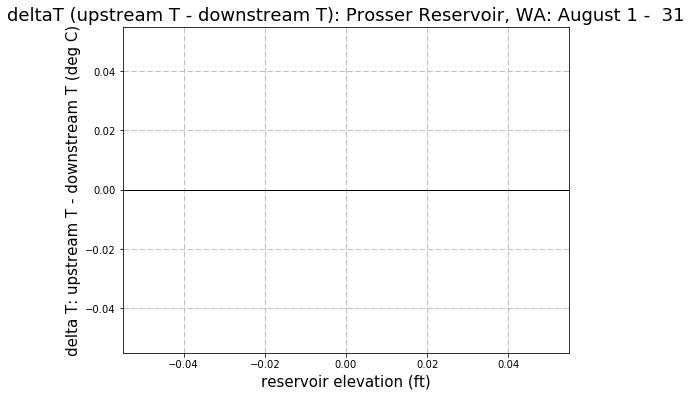

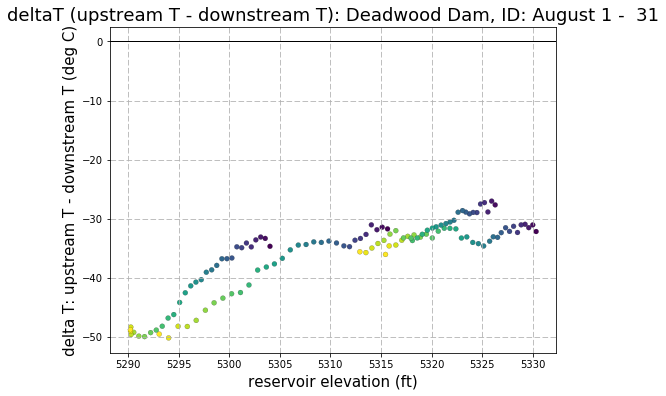

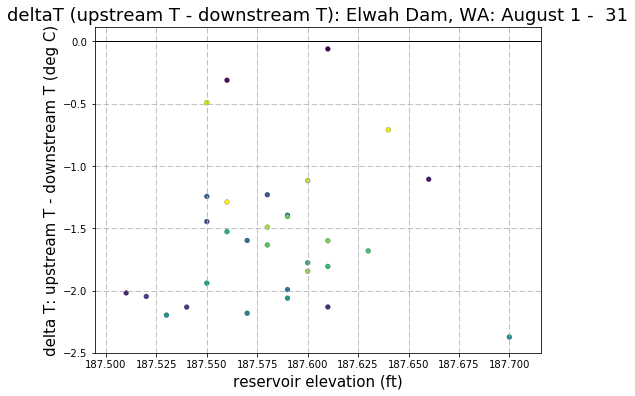

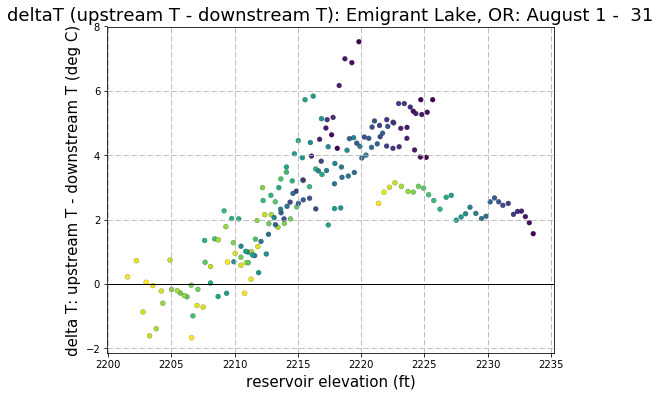

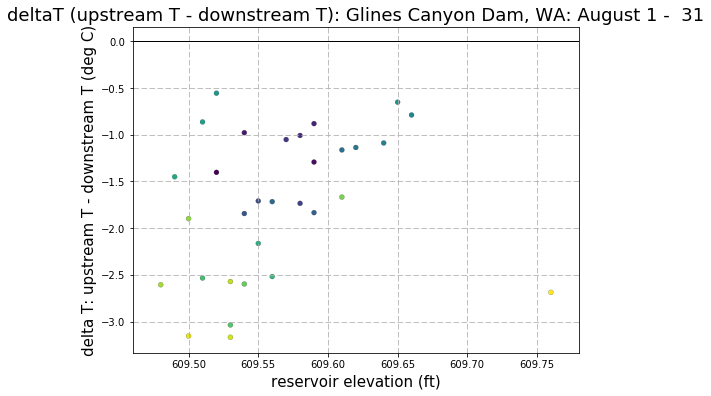

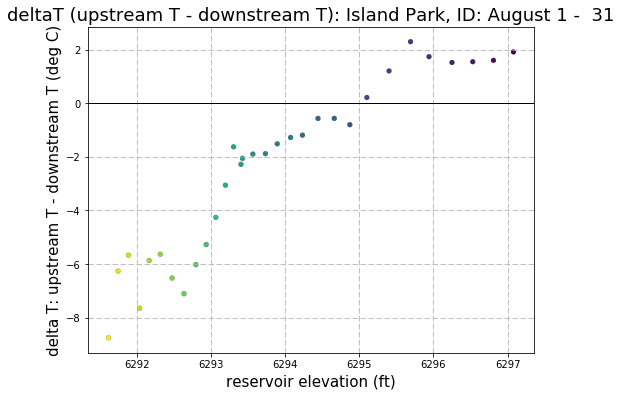

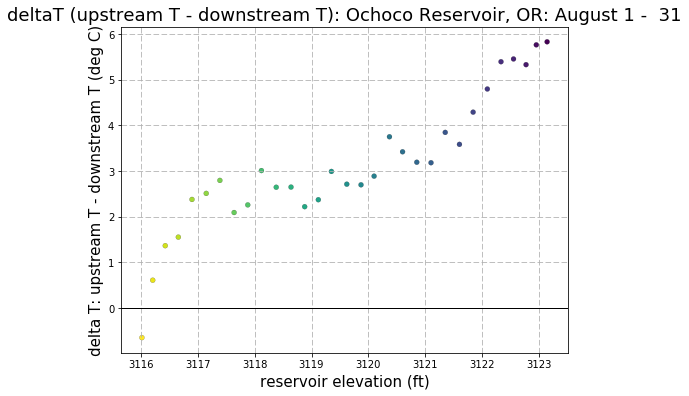

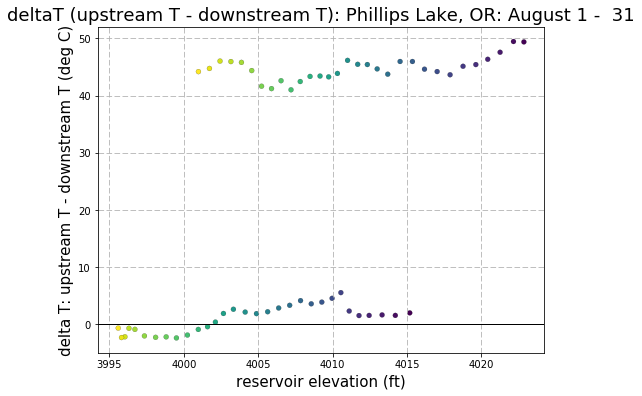

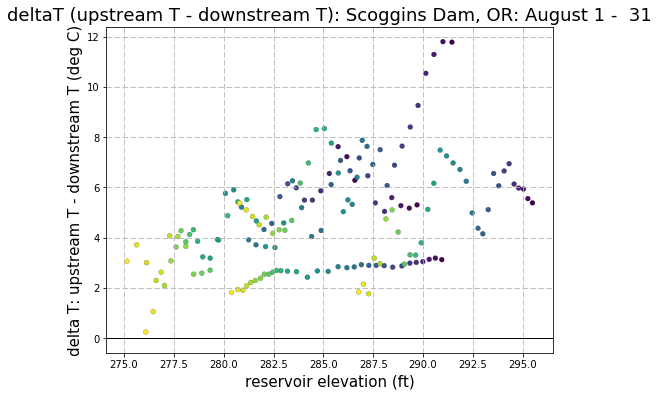

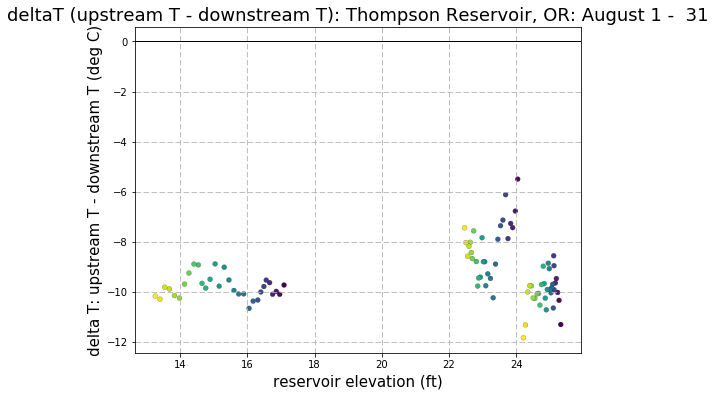

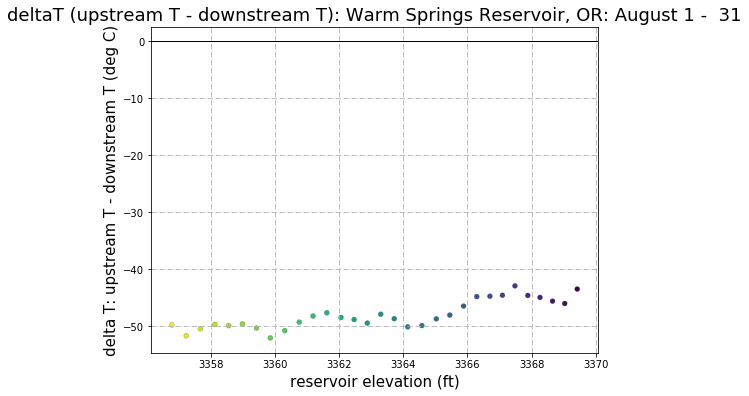

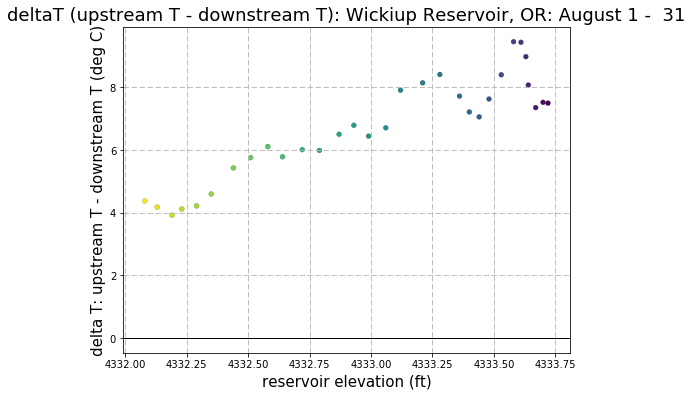

In [27]:
# ============================================================================================
#       Plot NorWest Data
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_norwest)):
#for i in reservoirs_temp_norwest.ix[32]:
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_norwest['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_norwest['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_norwest['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = read_NorWest_data(int(usgs_id_1down))
        data_T_up = read_NorWest_data(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
            if len(data_merge) > 1:
                data_merge['delta_T'] = data_merge.DAILYMEAN_y - data_merge.DAILYMEAN_x
            
                # ------------------- plot ------------------
                day1 = 212 # September 30
                day2 = 243 # August 31
                plt.figure(figsize=[8,6])
                plt.grid(linestyle='--')
                plt.axhline(y=0, xmin=0, xmax = 10000, linewidth=1, color='k')
                plt.scatter( data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            data_merge.delta_T[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=25, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )],
                           edgecolor='black', lw=0.15)


                #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
                plt.ylabel('delta T: upstream T - downstream T (deg C)', fontsize=15)
                plt.xlabel('reservoir elevation (ft)', fontsize=15)
                plt.title('deltaT (upstream T - downstream T): ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)

                plt.show()
    
    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)




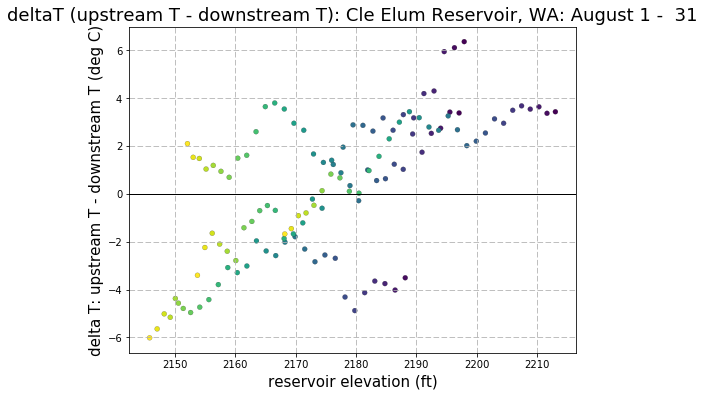

In [26]:

day1 = 212 # September 30
day2 = 243 # August 31
plt.figure(figsize=[8,6])
plt.grid(linestyle='--')
plt.axhline(y=0, xmin=0, xmax = 10000, linewidth=1, color='k')
plt.scatter( data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
            data_merge.delta_T[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
        s=25, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )],
           edgecolor='black', lw=0.15)


#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.ylabel('delta T: upstream T - downstream T (deg C)', fontsize=15)
plt.xlabel('reservoir elevation (ft)', fontsize=15)
plt.title('deltaT (upstream T - downstream T): ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)

plt.show()

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


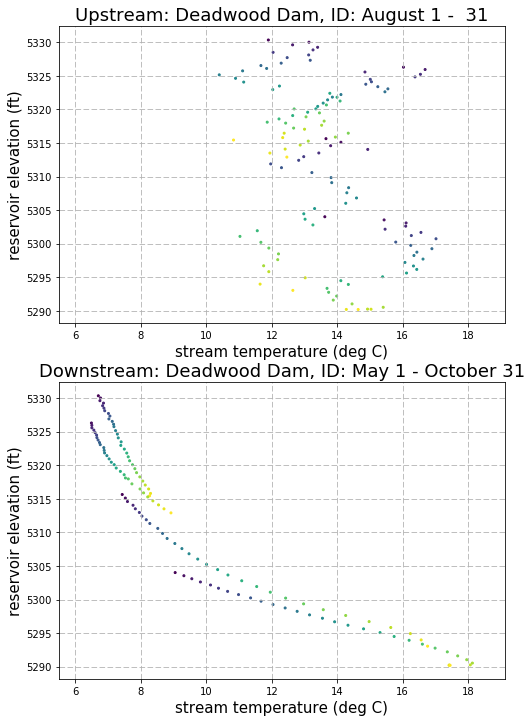

In [32]:
# ============================================================================================
#       Plot NorWest Data - JUST ONE SITE
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)


i = 16 # 16 = Deadwood
#  -------  read in Bureau of Rec water surface elevation  --------: 
station_id = reservoirs_temp_norwest['code'].ix[i]
data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')

#  -------  read in Bureau of Rec water surface elevation --------: 
usgs_id_1down = reservoirs_temp_norwest['downstream1'].ix[i]
usgs_id_1up = reservoirs_temp_norwest['upstream1'].ix[i]
if usgs_id_1down > 0 and usgs_id_1up > 0:
    data_T = read_NorWest_data(int(usgs_id_1down))
    data_T_up = read_NorWest_data(int(usgs_id_1up))

    if len(data_T) > 1 and len(data_T_up) > 1:
        data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
        data_merge=pd.merge(data_res,pd.DataFrame((data_T-32)*(5/9)), how='inner', left_index=True, right_index=True)
        data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
        if len(data_merge) > 1:

            # ------------------- plot ------------------
            day1 = 212 # September 30
            day2 = 243 # August 31
            plt.figure(figsize=[8,12])
            plt.subplot(211)
            plt.grid(linestyle='--')
            #plt.scatter( (data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )]-32)*(5/9), 
            plt.scatter( data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                    data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                    s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Upstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)
            plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])



            plt.subplot(212)            
            plt.grid(linestyle='--')
            plt.scatter( data_merge.DAILYMEAN_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Downstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': May 1 - October 31', fontsize=18)
            plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])


            plt.show()

#print(station_id, data_T.head())
#data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


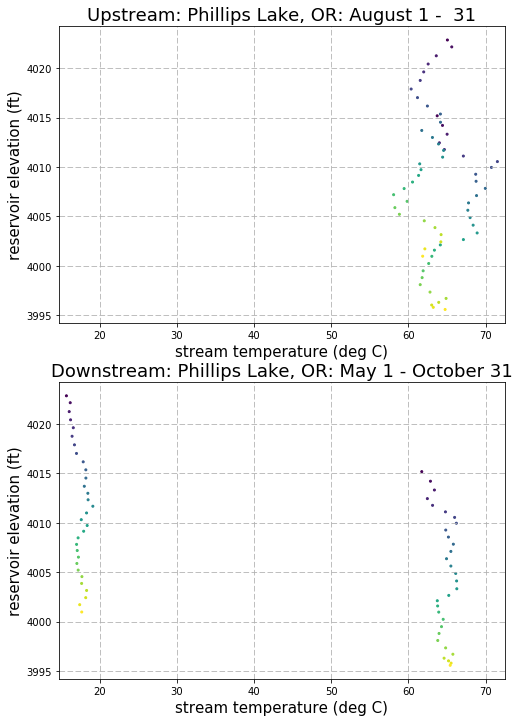

In [13]:
# ============================================================================================
#       Plot NorWest Data - JUST ONE SITE
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)


i = 29 # 16 = Phillips
#  -------  read in Bureau of Rec water surface elevation  --------: 
station_id = reservoirs_temp_norwest['code'].ix[i]
data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')

#  -------  read in Bureau of Rec water surface elevation --------: 
usgs_id_1down = reservoirs_temp_norwest['downstream1'].ix[i]
usgs_id_1up = reservoirs_temp_norwest['upstream1'].ix[i]
if usgs_id_1down > 0 and usgs_id_1up > 0:
    data_T = read_NorWest_data(int(usgs_id_1down))
    data_T_up = read_NorWest_data(int(usgs_id_1up))

    if len(data_T) > 1 and len(data_T_up) > 1:
        data_merge=pd.merge(data_res,pd.DataFrame((data_T*(9/5)+32)), how='inner', left_index=True, right_index=True)
        data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
        data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
        if len(data_merge) > 1:

            # ------------------- plot ------------------
            day1 = 212 # September 30
            day2 = 243 # August 31
            plt.figure(figsize=[8,12])
            plt.subplot(211)
            plt.grid(linestyle='--')
            #plt.scatter( (data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )]-32)*(5/9), 
            plt.scatter( data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                    data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                    s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Upstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)
            plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])



            plt.subplot(212)            
            plt.grid(linestyle='--')
            plt.scatter( data_merge.DAILYMEAN_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Downstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': May 1 - October 31', fontsize=18)
            plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])


            plt.show()

#print(station_id, data_T.head())
#data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


In [124]:
reservoirs_temp_norwest.ix[32]

Unnamed: 0               32
name           Scoggins Dam
state                    OR
code                    SCO
upstream1              1497
upstream2              5616
upstream3               NaN
downstream1            1498
downstream2             NaN
downstream3             NaN
Name: 32, dtype: object

reservoir:  0


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


reservoir:  1
reservoir:  2
reservoir:  3
reservoir:  4
reservoir:  5


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=12510500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=12510500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=12509060&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=12509060&statCd=00003&format=waterml


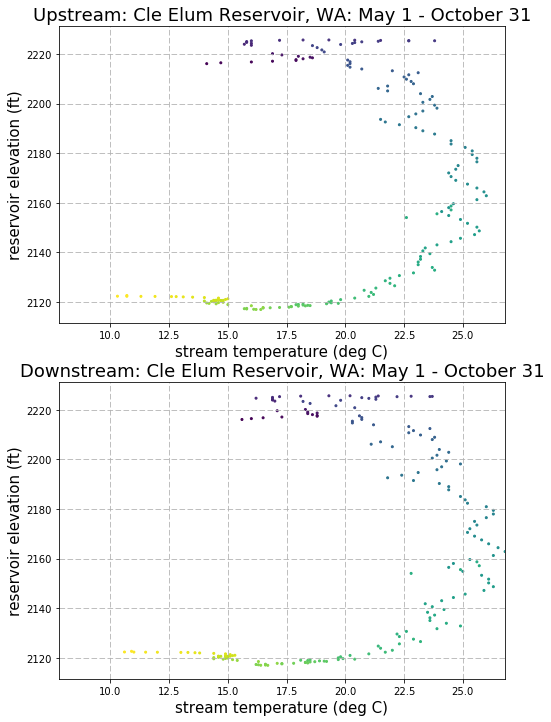

reservoir:  6
reservoir:  7
reservoir:  8
reservoir:  9


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13069500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13069500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13077000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13077000&statCd=00003&format=waterml


reservoir:  10


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13190500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13190500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13186000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13186000&statCd=00003&format=waterml


reservoir:  11
reservoir:  12


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13203510&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13203510&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13200000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13200000&statCd=00003&format=waterml


reservoir:  13
reservoir:  14
reservoir:  15


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13245000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13245000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13239000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13239000&statCd=00003&format=waterml


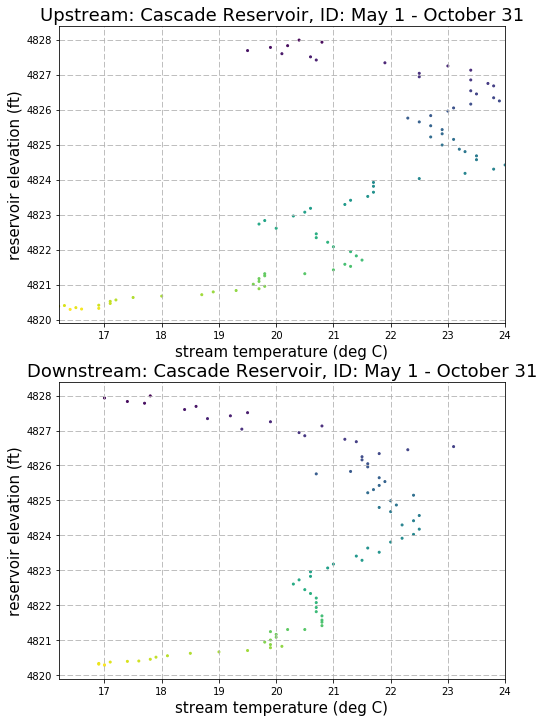

reservoir:  16
reservoir:  17
reservoir:  18
reservoir:  19


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13249500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13249500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13238000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13238000&statCd=00003&format=waterml


reservoir:  20
reservoir:  21
reservoir:  22


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13013650&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13013650&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13010065&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13010065&statCd=00003&format=waterml


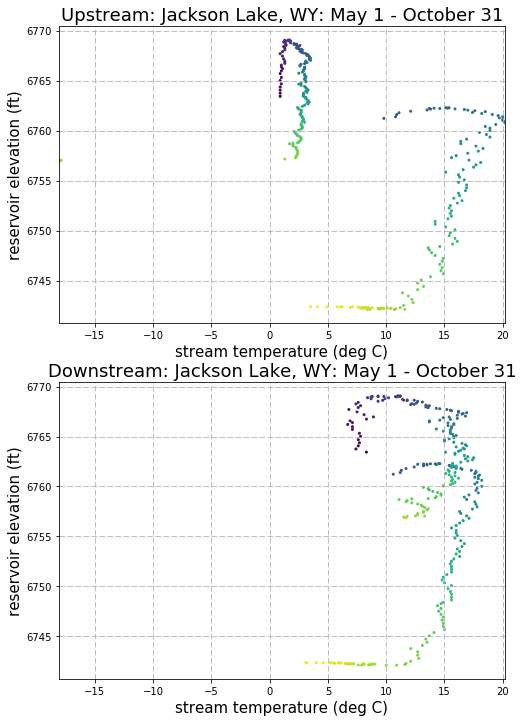

reservoir:  23


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13087995&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13087995&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13081500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13081500&statCd=00003&format=waterml


reservoir:  24


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13081500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13081500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13077000&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13077000&statCd=00003&format=waterml


reservoir:  25
reservoir:  26
reservoir:  27


processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13022500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13022500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00010&startDT=1851-01-01&site=13027500&statCd=00003&format=waterml
processing data from request: https://waterservices.usgs.gov/nwis/dv/?parameterCd=00011&startDT=1851-01-01&site=13027500&statCd=00003&format=waterml


reservoir:  28
reservoir:  29
reservoir:  30
reservoir:  31
reservoir:  32
reservoir:  33
reservoir:  34
reservoir:  35
reservoir:  36
reservoir:  37
reservoir:  38


In [17]:
# ============================================================================================
#       Plot USGS Data
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_usgs)):
    print('reservoir: ',i)
    
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_usgs['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_usgs['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_usgs['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = importusgssite_meantemperature(int(usgs_id_1down))
        data_T_up = importusgssite_meantemperature(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
        
            if len(data_merge) > 0:
            # ------------------- plot ------------------
                day1 = 120
                day2 = 304
                plt.figure(figsize=[8,12])
                plt.subplot(211)
                plt.grid(linestyle='--')
                plt.scatter( data_merge.temperature_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
                #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
                plt.xlabel('stream temperature (deg C)', fontsize=15)
                plt.ylabel('reservoir elevation (ft)', fontsize=15)
                plt.title('Upstream: ' +  reservoirs_temp_usgs['name'].ix[i] + ", " + reservoirs_temp_usgs['state'].ix[i] + ': May 1 - October 31', fontsize=18)
                plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

                plt.subplot(212)            
                plt.grid(linestyle='--')
                plt.scatter( data_merge.temperature_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
                #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
                plt.xlabel('stream temperature (deg C)', fontsize=15)
                plt.ylabel('reservoir elevation (ft)', fontsize=15)
                plt.title('Downstream: ' +   reservoirs_temp_usgs['name'].ix[i] + ", " + reservoirs_temp_usgs['state'].ix[i] + ': May 1 - October 31', fontsize=18)
                plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

                plt.show()

    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


reservoir:  0


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


reservoir:  1
reservoir:  2
reservoir:  3
reservoir:  4
reservoir:  5


/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=12510500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=12510500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=12509060&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=12509060&format=waterml&statCd=00003


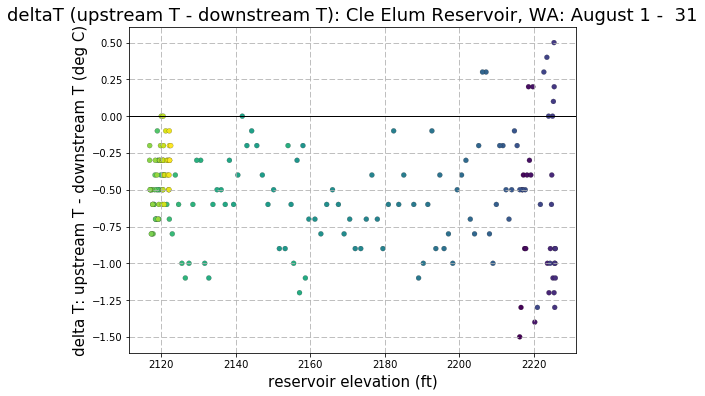

reservoir:  6
reservoir:  7
reservoir:  8
reservoir:  9


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13069500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13069500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13077000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13077000&format=waterml&statCd=00003


reservoir:  10


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13190500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13190500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13186000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13186000&format=waterml&statCd=00003


reservoir:  11
reservoir:  12


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13203510&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13203510&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13200000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13200000&format=waterml&statCd=00003


reservoir:  13
reservoir:  14
reservoir:  15


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13245000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13245000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13239000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13239000&format=waterml&statCd=00003


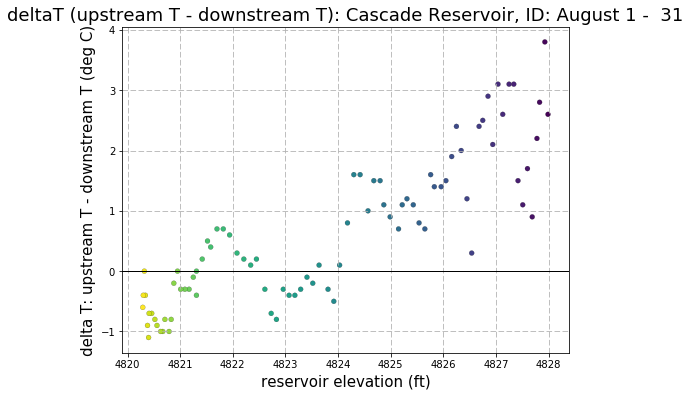

reservoir:  16
reservoir:  17
reservoir:  18
reservoir:  19


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13249500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13249500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13238000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13238000&format=waterml&statCd=00003


reservoir:  20
reservoir:  21
reservoir:  22


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13013650&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13013650&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13010065&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13010065&format=waterml&statCd=00003


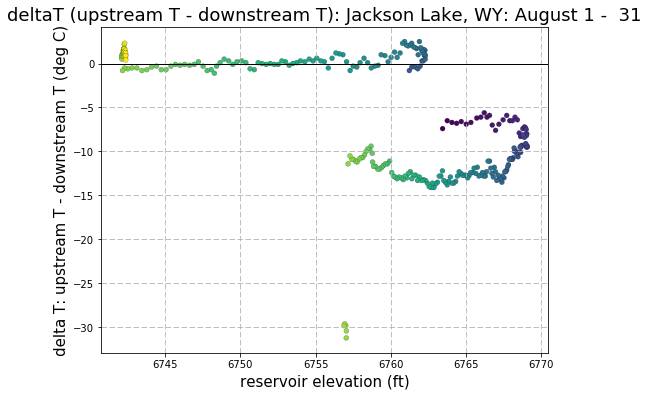

reservoir:  23


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13087995&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13087995&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13081500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13081500&format=waterml&statCd=00003


reservoir:  24


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13081500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13081500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13077000&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13077000&format=waterml&statCd=00003


reservoir:  25
reservoir:  26
reservoir:  27


processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13022500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13022500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00010&site=13027500&format=waterml&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?startDT=1851-01-01&parameterCd=00011&site=13027500&format=waterml&statCd=00003


reservoir:  28
reservoir:  29
reservoir:  30
reservoir:  31
reservoir:  32
reservoir:  33
reservoir:  34
reservoir:  35
reservoir:  36
reservoir:  37
reservoir:  38


In [28]:
# ============================================================================================
#       Plot USGS delta T data (upstream T - downstream T)
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_usgs)):
    print('reservoir: ',i)
    
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_usgs['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_usgs['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_usgs['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = importusgssite_meantemperature(int(usgs_id_1down))
        data_T_up = importusgssite_meantemperature(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
        
            if len(data_merge) > 0:
                data_merge['delta_T'] = data_merge.temperature_y - data_merge.temperature_x
            # ------------------- plot ------------------
                day1 = 120
                day2 = 304
                plt.figure(figsize=[8,6])
                plt.grid(linestyle='--')
                plt.axhline(y=0, xmin=0, xmax = 10000, linewidth=1, color='k')
                plt.scatter( data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            data_merge.delta_T[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                            s=25, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )],
                            edgecolor='black', lw=0.15)

                #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
                plt.ylabel('delta T: upstream T - downstream T (deg C)', fontsize=15)
                plt.xlabel('reservoir elevation (ft)', fontsize=15)
                plt.title('deltaT (upstream T - downstream T): ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)


                plt.show()

    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)



In [41]:
CA_reservoir_info.head()

site_code  upstream1_USGS  upstream2_USGS  upstream3_USGS  downstream1_USGS  \
0       CLE             NaN             NaN             NaN               NaN   
1       LEW             NaN             NaN             NaN        11525500.0   
2       WHI      11371000.0             NaN             NaN        11372000.0   
3       SPC             NaN             NaN             NaN        11370500.0   
4       SHA      11342000.0      11368000.0             NaN               NaN   

   downstream2_USGS  downstream3_USGS  upstream1_NW  upstream2_NW  \
0               NaN               NaN           NaN           NaN   
1        11525655.0               NaN       29456.0       28886.0   
2               NaN               NaN           NaN           NaN   
3               NaN               NaN           NaN           NaN   
4               NaN               NaN       32079.0       32079.0   

   upstream3_NW  downstream1_NW  downstream2_NW  downstream3_NW upstream_dam  \
0           NaN             NaN             NaN             NaN          NaN   
1       28824.0         28901.0         28971.0         28285.0          CLE   
2           NaN         31153.0         31154.0         31155.0          NaN   
3           NaN             NaN             NaN             NaN          SHA   
4       30878.0         30714.0             NaN             NaN          NaN   

   reservoir_temp  dam_completed                            Notes  
0             NaN            NaN    LEW is immediately downstream  
1             NaN            NaN      LEW just downstream of CLE   
2             NaN            NaN                              NaN  
3             NaN            NaN  no upstream or downstream sites  
4             NaN            NaN                              NaN

In [37]:
CA_reservoir_info.columns

Index(['site_code', 'upstream1_USGS', 'upstream2_USGS', 'upstream3_USGS',
       'downstream1_USGS', 'downstream2_USGS', 'downstream3_USGS',
       'upstream1_NW', 'upstream2_NW', 'upstream3_NW', 'downstream1_NW',
       'downstream2_NW', 'downstream3_NW', 'upstream_dam', 'reservoir_temp',
       'dam_completed', 'Notes'],
      dtype='object')

{'SHA':    sensor_id                   variable resolution  \
2          6  RESERVOIR ELEVATION daily      daily   

                           timerange units  
2  From 01/01/1985 12:01 to present.  feet  }


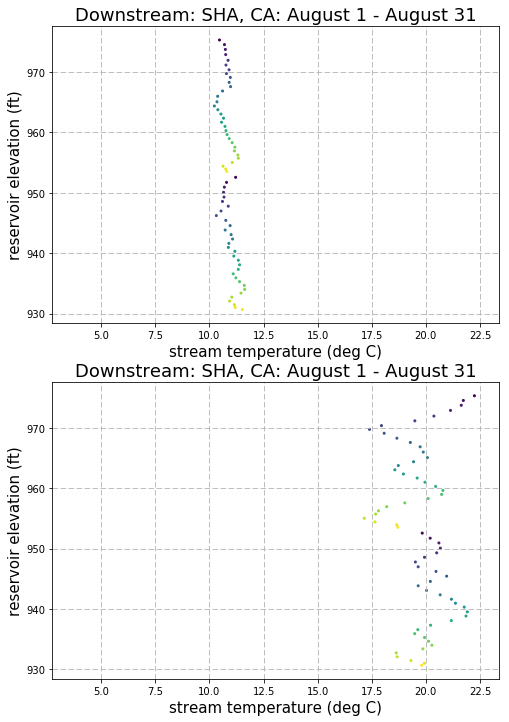

In [46]:
# ============================================================================================
#       Plot California Data - JUST ONE SITE
# ============================================================================================

start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)


i = 4 # 4 = "Shasta"

#  -------  read in Bureau of Rec water surface elevation  --------: 
station_id = CA_reservoir_info['site_code'].ix[i]
data_res =  read_CA_reservoir_data(station_id,6,'daily')

#  -------  read in temperature from USGS/NorWest --------: 
usgs_id_1down = CA_reservoir_info['upstream1_NW'].ix[i]
usgs_id_1up = CA_reservoir_info['downstream1_NW'].ix[i]
if usgs_id_1down > 0 and usgs_id_1up > 0:
    data_T = read_NorWest_data(int(usgs_id_1down))
    data_T_up = read_NorWest_data(int(usgs_id_1up))

    if len(data_T) > 1 and len(data_T_up) > 1:
        data_merge=pd.merge(data_res,pd.DataFrame((data_T*(9/5)+32)), how='inner', left_index=True, right_index=True)
        data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
        data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
        data_merge['res_level'] = data_merge['value']
        if len(data_merge) > 1:

            # ------------------- plot ------------------
            day1 = 212 # September 30
            day2 = 243 # August 31
            plt.figure(figsize=[8,12])
            plt.subplot(211)
            plt.grid(linestyle='--')
            #plt.scatter( (data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )]-32)*(5/9), 
            plt.scatter( data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                    data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                    s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Downstream: ' +   CA_reservoir_info['site_code'].ix[i] + ", " + "CA" + ': August 1 - August 31', fontsize=18)
            plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])



            plt.subplot(212)            
            plt.grid(linestyle='--')
            plt.scatter( data_merge.DAILYMEAN_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Downstream: ' +   CA_reservoir_info['site_code'].ix[i] + ", " + "CA" + ': August 1 - August 31', fontsize=18)
            plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])


            plt.show()

#print(station_id, data_T.head())
#data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


In [92]:
data_merge.head()

value  DAILYMEAN_x  DAILYMEAN_y
2008-05-13  1003.50    10.507292     8.945833
2008-05-14  1003.24    11.983333     9.004167
2008-05-15  1002.84    11.968750     9.295833
2008-05-16  1002.76    12.105208     9.175000
2008-05-17  1002.69    12.343750     9.170833

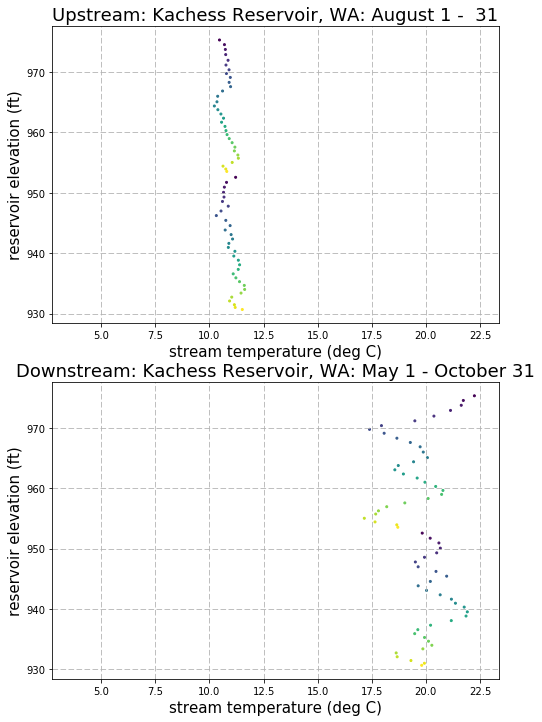

In [88]:
# ------------------- plot ------------------
day1 = 212 # September 30
day2 = 243 # August 31
plt.figure(figsize=[8,12])
plt.subplot(211)
plt.grid(linestyle='--')
#plt.scatter( (data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )]-32)*(5/9), 
plt.scatter( data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
        data_merge.value[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Upstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)
plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])



plt.subplot(212)            
plt.grid(linestyle='--')
plt.scatter( data_merge.DAILYMEAN_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
            data_merge.value[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
            s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Downstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': May 1 - October 31', fontsize=18)
plt.xlim([np.min([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])-1, np.max([data_merge.DAILYMEAN_x,data_merge.DAILYMEAN_y])+1])


plt.show()


In [46]:
int(CA_reservoir_info['upstream1_NW'].ix[i])

32079

In [43]:
#  -------  read in Bureau of Rec water surface elevation  --------: 
station_id = CA_reservoir_info['site_code'].ix[i]
data_res =  read_CA_reservoir_data(station_id,6,'daily')

#  -------  read in temperature from USGS/NorWest --------: 
usgs_id_1down = CA_reservoir_info['upstream1_NW'].ix[i]
usgs_id_1up = CA_reservoir_info['downstream1_NW'].ix[i]

if usgs_id_1down > 0 and usgs_id_1up > 0:
    data_T = read_NorWest_data(int(usgs_id_1down))
    data_T_up = read_NorWest_data(int(usgs_id_1up))


KeyError: 'DAILYMEAN'

In [63]:
data_xB = data_x

In [70]:
site_row

code     region  year1  year2  year3  year4  year5  year6  year7  \
8458  32079  CentralCA      2   26.0   52.0   77.0   99.0  116.0  138.0   

      year8   ...    year12  year13  year14  year15  year16  year17  year18  \
8458    NaN   ...       NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      year19  year20  year21  
8458     NaN     NaN     NaN  

[1 rows x 23 columns]

In [93]:
data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)

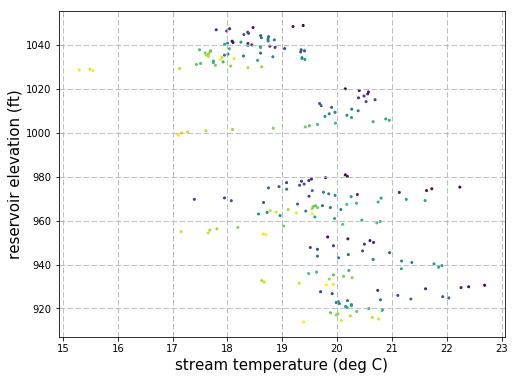

In [98]:
day1 = 212 # September 30
day2 = 243 # August 31
plt.figure(figsize=[8,6])
plt.grid(linestyle='--')
#plt.scatter( (data_merge.DAILYMEAN_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )]-32)*(5/9), 
plt.scatter( data_merge.DAILYMEAN[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
        data_merge.value[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])

#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)


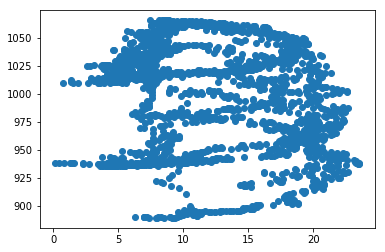

In [97]:
plt.scatter(data_merge.DAILYMEAN, data_merge.value,)

In [69]:
data_x.tail()

OBSPRED_ID             NorWeST_ID SampleDate  DailyMax  DailyMin  \
Date                                                                           
2005-12-26         338  CentralCalifornia_338 2005-12-26      1.91      0.60   
2005-12-27         338  CentralCalifornia_338 2005-12-27      2.04      1.56   
2005-12-28         338  CentralCalifornia_338 2005-12-28      2.20      1.37   
2005-12-29         338  CentralCalifornia_338 2005-12-29      2.07      1.28   
2005-12-30         338  CentralCalifornia_338 2005-12-30      2.15      0.88   

            DailyMean   DailySD  Nobs  DailyRange       DATE       Date  \
Date                                                                      
2005-12-26   1.345000  0.398061  24.0        1.31 2005-12-26 2005-12-26   
2005-12-27   1.895833  0.137142  24.0        0.48 2005-12-27 2005-12-27   
2005-12-28   1.806250  0.287157  24.0        0.83 2005-12-28 2005-12-28   
2005-12-29   1.638333  0.312071  24.0        0.79 2005-12-29 2005-12-29   
2005-12-30   1.476667  0.440530  24.0        1.27 2005-12-30 2005-12-30   

            DAILYMEAN  
Date                   
2005-12-26   1.345000  
2005-12-27   1.895833  
2005-12-28   1.806250  
2005-12-29   1.638333  
2005-12-30   1.476667

In [66]:
if 'SampleDate' in data_x.columns:
    data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
    data_x = data_x.set_index(data_x['DATE'])

if 'DATE' in data_x.columns:
    data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
    data_x = data_x.set_index(data_x['DATE'])

if 'DailyMean' in data_x.columns:
    if 'DATE' in data_x.columns:
        data_x['Date'] = data_x['DATE']
    data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
    data_x = data_x.set_index(data_x['Date'])
    data_x['DATE'] = data_x['Date']
    data_x['DAILYMEAN'] = data_x['DailyMean']

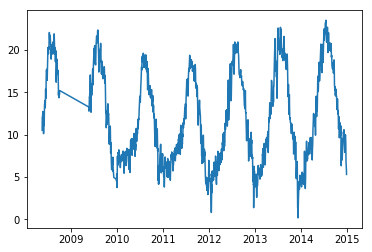

In [83]:
plt.plot(data_x3)

In [79]:
listx = site_row[0:1].values
listx = listx[0,2:len(listx[0,:])] #get just the site/year values (w/ NaN)
list_len = sum(i > 0 for i in listx) #get just the site/year values - remove NaN
site_list_x = listx[0:list_len] #get just the site/year values
data_x3 = pd.DataFrame()
for i in range(len(site_list_x)):
    site_i = int(float(str(site_list_x[i])))
    data_x2 = data_x[data_x['OBSPRED_ID']==site_i]
    data_x2 = pd.DataFrame(data_x2['DAILYMEAN'])
    data_x3 = data_x3.append(data_x2)

In [48]:

station_id = int(usgs_id_1down)

# -------------- get the Norwest ID row and site code --------------
site_row = NorWest_ID_list[NorWest_ID_list.code==station_id]
stringx = str(site_row.region.values)
stringx = ''.join(e for e in stringx if e.isalnum())

# ------------------ read in NorWest data files -----------------
filex = all_NorWest_files[ID_match_ups[site_name.index(str(stringx))][1]]
pathx = stream_temp_NorWest_path + '/' + filex
#print(pathx)

#  ------- Oregon is .txt (12 position) -----------
if i == 12:
    data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])  

    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'Date' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']

#  ------- all other files (excel) -----------       
else:
    data_x = pd.read_excel(pathx)

    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'DATE' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'DailyMean' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']

# ---------------- get specific data ---------------
siteyearx = str(site_row.year15.values)
siteyearx = int(''.join(e for e in siteyearx if e.isalnum()))
data_x2 = data_x[data_x['OBSPRED_ID']==siteyearx]
data_x3 = data_x2['DAILYMEAN']

return data_x3


ValueError: invalid literal for int() with base 10: 'nan'

In [54]:
site_row

code     region  year1  year2  year3  year4  year5  year6  year7  \
8458  32079  CentralCA      2   26.0   52.0   77.0   99.0  116.0  138.0   

      year8   ...    year12  year13  year14  year15  year16  year17  year18  \
8458    NaN   ...       NaN     NaN     NaN     NaN     NaN     NaN     NaN   

      year19  year20  year21  
8458     NaN     NaN     NaN  

[1 rows x 23 columns]

# ============================================================================================
#       Practice with NorWest uplaod
# ============================================================================================

In [73]:
station_id = reservoirs_temp_norwest['downstream1'][10]

# -------------- get the Norwest ID row and site code --------------
site_row = NorWest_ID_list[NorWest_ID_list.code==station_id]
stringx = str(site_row.region.values)
stringx = ''.join(e for e in stringx if e.isalnum())

# ------------------ read in NorWest data files -----------------
filex = all_NorWest_files[ID_match_ups[site_name.index(str(stringx))][1]]
pathx = stream_temp_NorWest_path + '/' + filex
#print(pathx)

#  ------- Oregon is .txt (12 position) -----------
if i == 12:
    data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])  

    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])
        if 'DailyMean' in data_x.columns:
            data_x['DAILYMEAN'] = data_x['DailyMean']

    if 'Date' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']

#  ------- all other files (excel) -----------       
else:
    data_x = pd.read_excel(pathx)

    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'DATE' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'Date' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']

listx = site_row[0:1].values
listx = listx[0,2:len(listx[0,:])] #get just the site/year values (w/ NaN)
list_len = sum(i > 0 for i in listx) #get just the site/year values - remove NaN
site_list_x = listx[0:list_len] #get just the site/year values
data_x3 = pd.DataFrame()
for i in range(len(site_list_x)):
    site_i = int(float(str(site_list_x[i])))
    data_x2 = data_x[data_x['OBSPRED_ID']==site_i]
    data_x2 = pd.DataFrame(data_x2['DAILYMEAN'])
    data_x3 = data_x3.append(data_x2)

In [9]:
uploads_TF =   ['False'] * len(ID_match_ups)

In [12]:
uploads_TF[ID_match_ups[site_name.index(str(stringx))][1]]

'False'

In [13]:
station_id = reservoirs_temp_norwest['downstream1'][10]

# -------------- get the Norwest ID row and site code --------------
site_row = NorWest_ID_list[NorWest_ID_list.code==station_id]
stringx = str(site_row.region.values)
stringx = ''.join(e for e in stringx if e.isalnum())
region_number = ID_match_ups[site_name.index(str(stringx))][1]
print(stringx)

# ------------------ read in NorWest data files -----------------
filex = all_NorWest_files[ID_match_ups[site_name.index(str(stringx))][1]]
pathx = stream_temp_NorWest_path + '/' + filex
#print(pathx)


MidSnake


In [80]:
ID_match_ups[site_name.index(str(stringx))][0] + '_data_x'

'UppColumbiaYakima_data_x'

In [14]:
ID_match_ups

[['WACoast', 13],
 ['CentralCA', 0],
 ['Clearwater', 1],
 ['CoastalCA', 2],
 ['KlamathNorthernCA', 3],
 ['Lahontan', 'NaN'],
 ['MidColumbia', 4],
 ['MidSnake', 5],
 ['MissouriHW', 6],
 ['ORCoast', 12],
 ['ORSouthCentral', 7],
 ['Salmon', 8],
 ['SnakeBear', 9],
 ['Spokoot', 10],
 ['UppColumbiaYakima', 11]]

In [86]:
myDict = {}

In [90]:
def WACoast_data(data_x):
    return data_x
myDict["WACoast"] = WACoast_data

In [93]:
myDict["WACoast"]

<function __main__.WACoast_data>

In [89]:
x.head()

AttributeError: 'function' object has no attribute 'head'

In [65]:
ID_match_ups[site_name.index(str(stringx))][1]

11

In [66]:
exec("data_x%d = %s" % (ID_match_ups[site_name.index(str(stringx))][1], repr(data_x)))

SyntaxError: invalid syntax (<string>, line 1)

In [15]:

#  ------- Oregon is .txt (12 position) -----------
if uploads_TF[ID_match_ups[site_name.index(str(stringx))][1]]=='False':
    if region_number == 12:
        data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])
            if 'DailyMean' in data_x.columns:
                data_x['DAILYMEAN'] = data_x['DailyMean']

        if 'Date' in data_x.columns:
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']

    #  ------- all other files (excel) -----------       
    else:
        data_x = pd.read_excel(pathx)

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'DATE' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'Date' in data_x.columns:
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']

    # --------- set True/False to "True" - so you don't have to upload again -------
    #uploads_TF[ID_match_ups[site_name.index(str(stringx))][1]] = 'True'
else:
    if region_number == 12:
        data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])
        

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'Date' in data_x.columns:
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']

    #  ------- all other files (excel) -----------       
    else:
        data_x = pd.read_excel(pathx)

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'DATE' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'Date' in data_x.columns:
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']



    

In [16]:
siteyearx = str(site_row.year1.values)
siteyearx = int(''.join(e for e in siteyearx if e.isalnum()))

In [27]:
listx = site_row[0:1].values
listx = listx[0,2:len(listx[0,:])] #get just the site/year values (w/ NaN)
list_len = sum(i > 0 for i in listx) #get just the site/year values - remove NaN
site_list_x = listx[0:list_len] #get just the site/year values
data_x3 = []
for i in range(len(site_list_x)):
    site_i = str(site_list_x[i])
    site_i = int(''.join(e for e in site_i if e.isalnum()))
    print(site_i)
    data_x2 = data_x[data_x['OBSPRED_ID']==int(site_i)]
    data_x2 = pd.DataFrame(data_x2['DAILYMEAN'])
    print(data_x2.index)
    data_x3.append(data_x2)

503
DatetimeIndex(['2002-08-01', '2002-08-02', '2002-08-03', '2002-08-04',
               '2002-08-05', '2002-08-06', '2002-08-07', '2002-08-08',
               '2002-08-09', '2002-08-10', '2002-08-11', '2002-08-12',
               '2002-08-13', '2002-08-14', '2002-08-15', '2002-08-16',
               '2002-08-17', '2002-08-18', '2002-08-19', '2002-08-20',
               '2002-08-21', '2002-08-22', '2002-08-23', '2002-08-24',
               '2002-08-25', '2002-08-26', '2002-08-27', '2002-08-28',
               '2002-08-29', '2002-08-30', '2002-08-31'],
              dtype='datetime64[ns]', name='DATE', freq=None)
5070
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)
5100
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)
5130
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)
5160
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)


In [32]:
data_x[data_x['OBSPRED_ID']==int(5160)]

Empty DataFrame
Columns: [OBSPRED_ID, DATE, DAILYMINIMUM, DAILYMEAN, DAILYMAXIMUM, NOBS, STATUS, MEAN_FLAG]
Index: []

In [21]:
for i in range(len(site_list_x)):
    site_i = str(site_list_x[i])
    site_i = int(''.join(e for e in site_i if e.isalnum()))
    print(site_i)

503
5070
5100
5130
5160


In [203]:
data_x[data_x['OBSPRED_ID']==6880]

Empty DataFrame
Columns: [OBSPRED_ID, DATE, DAILYMINIMUM, DAILYMEAN, DAILYMAXIMUM, NOBS, STATUS, MEANFLAG]
Index: []

In [232]:
# ---------------- get specific data ---------------
listx = site_row[0:1].values
listx = listx[0,2:len(listx[0,:])] #get just the site/year values (w/ NaN)
list_len = sum(i > 0 for i in listx) #get just the site/year values - remove NaN
site_list_x = listx[0:list_len] #get just the site/year values

data_x3 = pd.DataFrame()
for i in range(0,len(site_list_x)):
    site_i = str(site_list_x[i])
    siteyearx = int(''.join(e for e in site_i if e.isalnum()))
    data_x2 = data_x[data_x['OBSPRED_ID']==int(siteyearx)]
    data_x2 = pd.DataFrame(data_x2['DAILYMEAN'])
    print(data_x2.index)
    data_x3 = data_x3.append(data_x2)

DatetimeIndex(['2002-08-01', '2002-08-02', '2002-08-03', '2002-08-04',
               '2002-08-05', '2002-08-06', '2002-08-07', '2002-08-08',
               '2002-08-09', '2002-08-10', '2002-08-11', '2002-08-12',
               '2002-08-13', '2002-08-14', '2002-08-15', '2002-08-16',
               '2002-08-17', '2002-08-18', '2002-08-19', '2002-08-20',
               '2002-08-21', '2002-08-22', '2002-08-23', '2002-08-24',
               '2002-08-25', '2002-08-26', '2002-08-27', '2002-08-28',
               '2002-08-29', '2002-08-30', '2002-08-31'],
              dtype='datetime64[ns]', name='DATE', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)
DatetimeIndex([], dtype='datetime64[ns]', name='DATE', freq=None)


In [225]:
data_x3.head()

DAILYMEAN
DATE                 
2004-08-01  20.485380
2004-08-02  20.827485
2004-08-03  20.744639
2004-08-04  20.124756
2004-08-05  20.060429

In [228]:
data_x3.index

DatetimeIndex(['2004-08-01', '2004-08-02', '2004-08-03', '2004-08-04',
               '2004-08-05', '2004-08-06', '2004-08-07', '2004-08-08',
               '2004-08-09', '2004-08-10', '2004-08-11', '2004-08-12',
               '2004-08-13', '2004-08-14', '2004-08-15', '2004-08-16',
               '2004-08-17', '2004-08-18', '2004-08-19', '2004-08-20',
               '2004-08-21', '2004-08-22', '2004-08-23', '2004-08-24',
               '2004-08-25', '2004-08-26', '2004-08-27', '2004-08-28',
               '2004-08-29', '2004-08-30', '2004-08-31'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [51]:
ID_match_ups[site_name.index(str(stringx))][0] + '_data_x' = data_x

SyntaxError: can't assign to operator (<ipython-input-51-bf7d54f447f6>, line 1)

In [43]:
uploads_TF[ID_match_ups[site_name.index(str(stringx))][1]]

'True'

In [171]:
#region = 
station_id = reservoirs_temp_norwest['downstream1'][4]

# -------------- get the Norwest ID row and site code --------------
site_row = NorWest_ID_list[NorWest_ID_list.code==station_id]
stringx = str(site_row.region.values)
stringx = ''.join(e for e in stringx if e.isalnum())

# ------------------ read in NorWest data files -----------------
filex = all_NorWest_files[ID_match_ups[site_name.index(str(stringx))][1]]
pathx = stream_temp_NorWest_path + '/' + filex

#pathx = stream_temp_NorWest_path + '/' + all_NorWest_files[i]

print(pathx)

#  ------- Oregon is .txt (12 position) -----------
if i == 12:
    data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])  
    
    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'Date' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']

#  ------- all other files (excel) -----------       
else:
    data_x = pd.read_excel(pathx)

    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'DATE' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'Date' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']
        
# ---------------- get specific data ---------------
siteyearx = str(site_row.year1.values)
siteyearx = int(''.join(e for e in siteyearx if e.isalnum()))
data_x2 = data_x[data_x['OBSPRED_ID']==siteyearx]
data_x3 = data_x2['DailyMean']


/raid3/rniemeyr/reservoir_stream_temp_empirical_project/data/NorWest/stream_temps/NorWeST_ObservedStreamTempDailySummaries_UppColYak.xlsx


In [202]:
siteyearx = str(site_row.year1.values)
siteyearx = int(''.join(e for e in siteyearx if e.isalnum()))
data_x2 = data_x[data_x['OBSPRED_ID']==siteyearx]
data_x3 = pd.DataFrame([data_x2['DATE'],data_x2['DailyMean']])

In [ ]:
data_norwest_upstream = data_norwest.loc[data_norwest['OBSPRED_ID'].isin(site_ID_and_year_ID[1497])]   
data_norwest_upstream['year'] = data_norwest_upstream.DATE.dt.year

In [9]:
len(data_norwest)

76914

In [9]:
station_id = "JCK" #SCO was here before 
usgs_id = 13013650
start_datetime = dt.datetime(1990,5,1)
end_datetime = dt.datetime(2015,12,31)
parameterx = 'fb'  # bureau of reclamation parameter 

In [10]:
usgs_id =12362500
station_id = "HGH" #SCO was here before 
start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

In [96]:
usgs_id =12493005
station_id = "RIM" #SCO was here before 
start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

In [117]:
usgs_id = 12510500
station_id = 'CLE'

In [124]:
usgs_id =13069500
station_id = 'AMF'

In [154]:
usgs_id = 13251000
usgs_id_up = 13238000
station_id = 'EMM'

In [11]:
usgs_id = 14202980
station_id = 'SCO'

In [215]:


start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_usgs)):
    
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_usgs['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_usgs['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_usgs['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = read_NorWest_data(int(usgs_id_1down))
        data_T_up = read_NorWest_data(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)

        
            # ------------------- plot ------------------
            day1 = 120
            day2 = 304
            plt.figure(figsize=[8,12])
            plt.subplot(211)
            plt.grid(linestyle='--')
            plt.scatter( data_merge.temperature_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Upstream: ' +   reservoirs_temp_usgs['name'].ix[i] + ", " + reservoirs_temp_usgs['state'].ix[i] + ': May 1 - October 31', fontsize=18)
            plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

            plt.subplot(212)
            plt.grid(linestyle='--')
            plt.scatter( data_merge.temperature_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Downstream: ' +  reservoirs_temp_usgs['name'].ix[i] + ", " + reservoirs_temp_usgs['state'].ix[i] + ': May 1 - October 31', fontsize=18)
            plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

            plt.legend()
            
            plt.show()
    
    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


Unnamed: 0                       name state code  upstream1  upstream2  \
0            0               Hungry Horse    MT  HGH    13923.0        NaN   
1            1               Grand Coulee    WA  GCL        NaN        NaN   
2            2               Rimrock Lake    WA  RIM        NaN        NaN   
3            3       Keechelus REsservoir    WA  KEE        NaN        NaN   
4            4          Kachess Reservoir    WA  KAC        NaN        NaN   
5            5         Cle Elum Reservoir    WA  CLE    23792.0        NaN   
6            6               Bumping Lake    WA  BUM    15827.0        NaN   
7            7          Prosser Reservoir    WA  PRO     5082.0     1523.0   
8            8            McKay Reservoir    OR  MCK     3307.0     3193.0   
9            9   American Falls Reservoir    ID  AMF     4794.0     4792.0   
10          10         Anderson Ranch Dam    ID  AND    10245.0    19081.0   
11          11              Arrowrock Dam    ID  ARK    19079.0    10231.0   
12          12       Lucky Peak Reservoir    ID  LUC        NaN        NaN   
13          13     Crane Praire Reservoir    OR  CRA     7414.0        NaN   
14          14              Crescent Lake    OR  CRE        NaN        NaN   
15          15          Cascade Reservoir    ID  CSC     4853.0        NaN   
16          16               Deadwood Dam    ID  DED    12473.0    19083.0   
17          17                  Elwah Dam    WA  ELD    19998.0    25965.0   
18          18              Emigrant Lake    OR  EMI    15828.0     8135.0   
19          19           Black Canyon Dam    ID  EMM        NaN        NaN   
20          20          Glines Canyon Dam    WA  GLI    25966.0        NaN   
21          21                Island Park    ID  ISL    17572.0        NaN   
22          22               Jackson Lake    WY  JCK    17533.0        NaN   
23          23                Milner Lake    ID  MIL     4800.0        NaN   
24          24               Lake Walcott    ID  MIN     2684.0        NaN   
25          25           Ochoco Reservoir    OR  OCH    20110.0     1480.0   
26          26                Lake Owyhee    OR  OWY     5099.0     1495.0   
27          27        Palisades Reservoir    ID  PAL        NaN        NaN   
28          28               Payette Lake    ID  PAY      278.0     8903.0   
29          29              Phillips Lake    OR  PHL     1488.0     1933.0   
30          30         Potholes Reservoir    WA  POT        NaN        NaN   
31          31                 Ririe Lake    ID  RIR    16965.0    16928.0   
32          32               Scoggins Dam    OR  SCO     1497.0     5616.0   
33          33  Soliders Meadow Reservoir    ID  SOL        NaN        NaN   
34          34           Thief Valley Dam    OR  THF        NaN        NaN   
35          35         Thompson Reservoir    OR  THM    23572.0        NaN   
36          36     Warm Springs Reservoir    OR  WAR    18167.0    17843.0   
37          37          Wickiup Reservoir    OR  WIC    20874.0    20828.0   
38          38        Wildhorse Reservoir    NV  WLD        NaN        NaN   

    upstream3  downstream1  downstream2  downstream3  
0         NaN          NaN          NaN          NaN  
1         NaN          NaN          NaN          NaN  
2         NaN          NaN          NaN          NaN  
3         NaN      16073.0      23796.0      16069.0  
4         NaN      15840.0      16070.0          NaN  
5         NaN      15840.0      16070.0          NaN  
6         NaN       1423.0      23773.0          NaN  
7         NaN      15823.0       1525.0       5083.0  
8      3209.0       3203.0       3204.0          NaN  
9      4786.0       2684.0          NaN          NaN  
10    18493.0      19080.0      12535.0          NaN  
11        NaN          NaN          NaN          NaN  
12        NaN       4844.0       4846.0       4847.0  
13        NaN      20828.0      20874.0          NaN  
14        NaN       5347.0      20582.0      20621.0  
15 

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


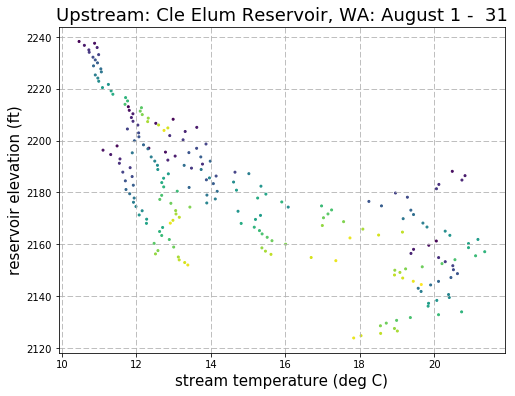

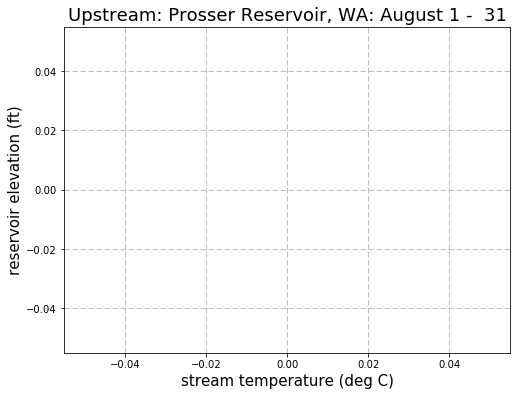

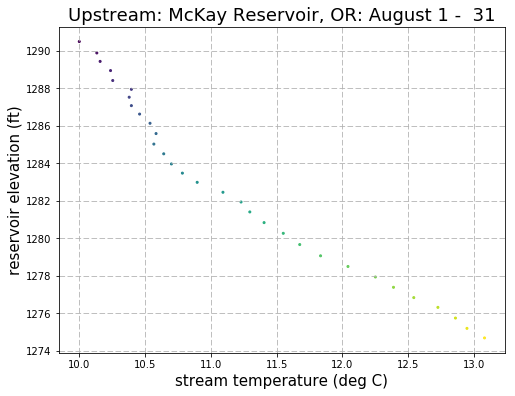

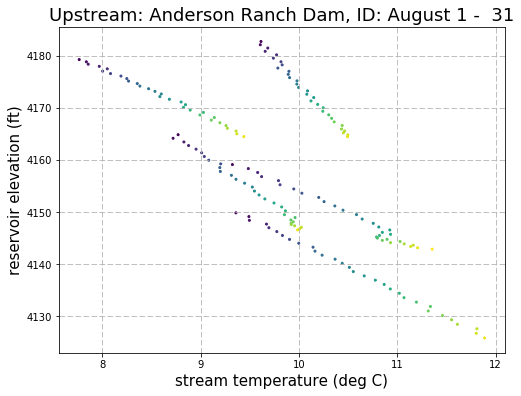

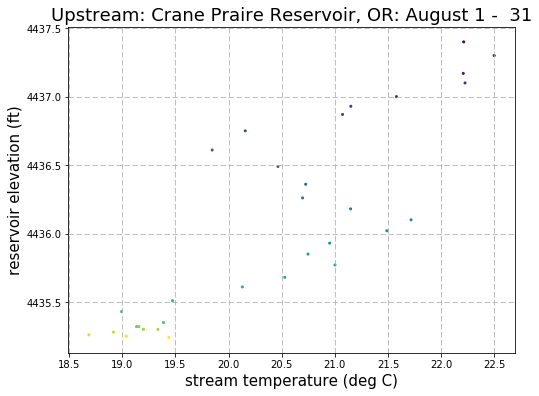

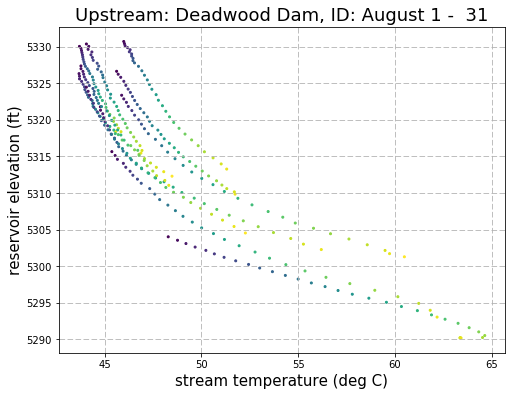

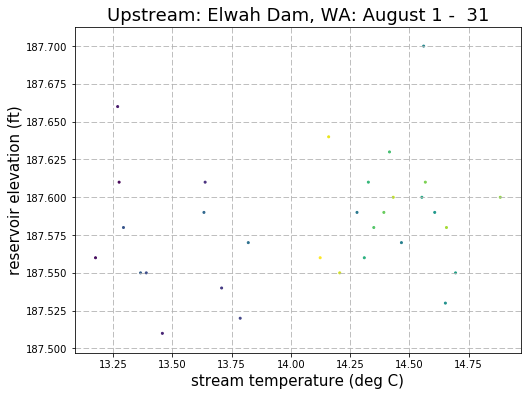

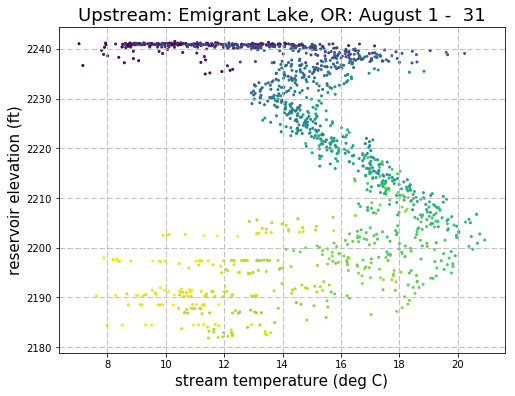

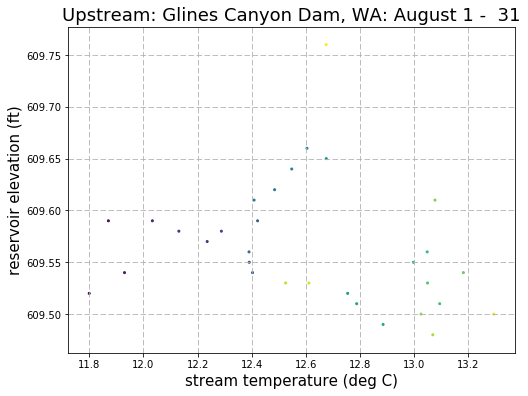

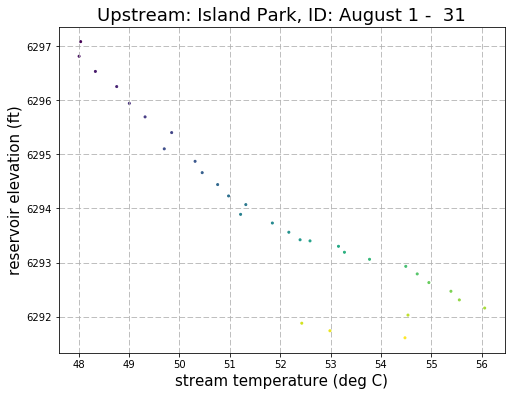

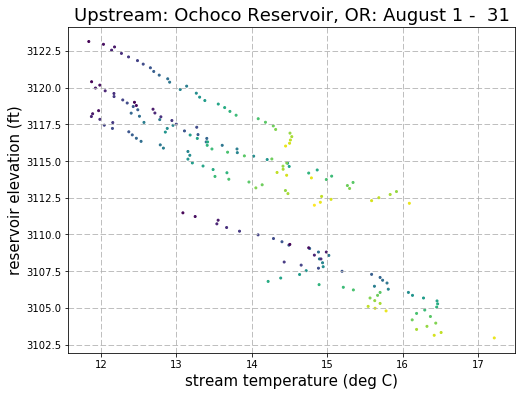

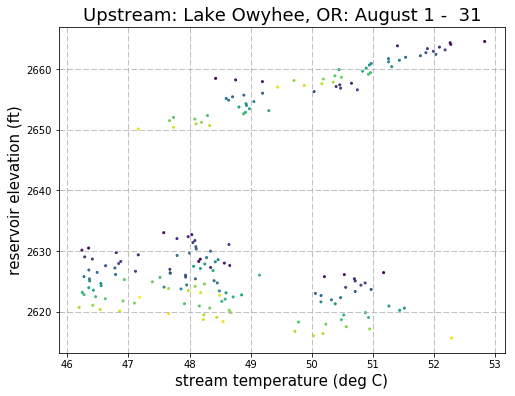

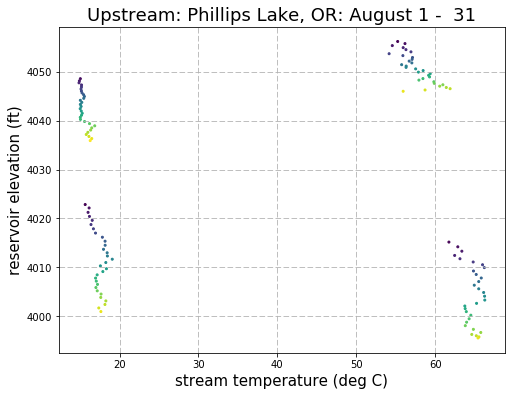

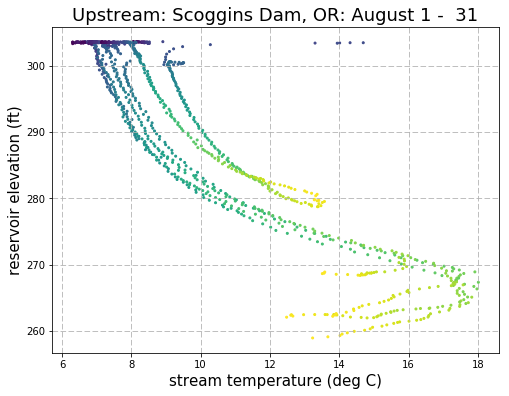

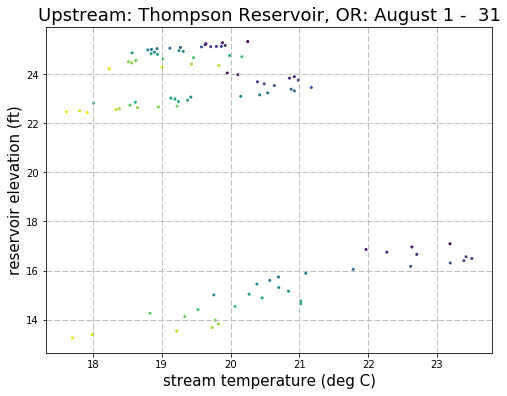

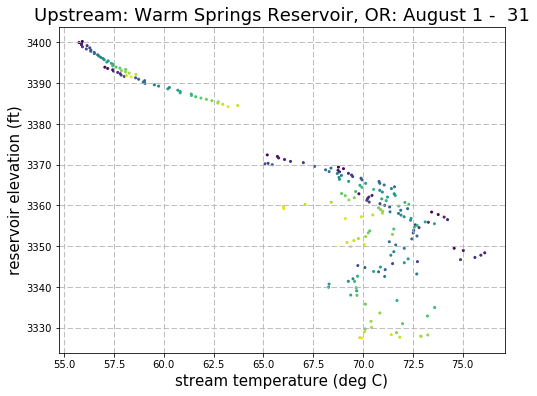

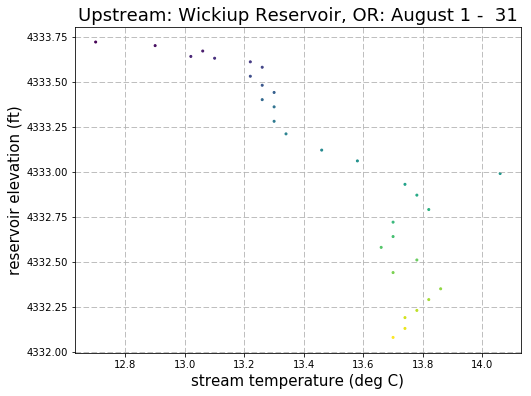

In [122]:
start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_norwest)):
    
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_norwest['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_norwest['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_norwest['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = read_NorWest_data(int(usgs_id_1down))
        data_T_up = read_NorWest_data(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
            
            # ------------------- plot ------------------
            day1 = 120
            day2 = 304
            plt.figure(figsize=[8,6])
            plt.grid(linestyle='--')
            plt.scatter( data_merge.DAILYMEAN[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Upstream: ' +   reservoirs_temp_norwest['name'].ix[i] + ", " + reservoirs_temp_norwest['state'].ix[i] + ': August 1 -  31', fontsize=18)
            #plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

            
            plt.show()
    
    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


In [112]:
reservoirs_temp_norwest.ix[18]

Unnamed: 0                18
name           Emigrant Lake
state                     OR
code                     EMI
upstream1              15828
upstream2               8135
upstream3                NaN
downstream1             1413
downstream2             1404
downstream3             1412
Name: 18, dtype: object

In [119]:
station_id = reservoirs_temp_norwest['downstream1'].ix[18]
#data_T = read_NorWest_data(int(usgs_id_1down))
site_row = NorWest_ID_list[NorWest_ID_list.code==station_id]
stringx = str(site_row.region.values)
stringx = ''.join(e for e in stringx if e.isalnum())

# ------------------ read in NorWest data files -----------------

filex = all_NorWest_files[ID_match_ups[site_name.index(str(stringx))][1]]
pathx = stream_temp_NorWest_path + '/' + filex

site_id_x = ID_match_ups[site_name.index(str(stringx))][1]
#  ------- Oregon is .txt (12 position) -----------
if site_id_x == 12:
    data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])  

    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])
        if 'DailyMean' in data_x.columns:
            data_x['DAILYMEAN'] = data_x['DailyMean']

    if 'Date' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']

#  ------- all other files (excel) -----------       
else:
    data_x = pd.read_excel(pathx)

    if 'SampleDate' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'DATE' in data_x.columns:
        data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
        data_x = data_x.set_index(data_x['DATE'])

    if 'Date' in data_x.columns:
        data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
        data_x = data_x.set_index(data_x['Date'])
        data_x['DATE'] = data_x['Date']
        data_x['DAILYMEAN'] = data_x['DailyMean']

listx = site_row[0:1].values
listx = listx[0,2:len(listx[0,:])] #get just the site/year values (w/ NaN)
list_len = sum(i > 0 for i in listx) #get just the site/year values - remove NaN
site_list_x = listx[0:list_len] #get just the site/year values
data_x3 = pd.DataFrame()
for i in range(len(site_list_x)):
    site_i = int(float(str(site_list_x[i])))
    data_x2 = data_x[data_x['OBSPRED_ID']==site_i]
    data_x2 = pd.DataFrame(data_x2['DAILYMEAN'])
    data_x3 = data_x3.append(data_x2)


In [120]:
data_x3

DAILYMEAN
DATE                 
2005-01-01       3.95
2005-01-02       3.46
2005-01-03       3.22
2005-01-04       2.29
2005-01-05       2.14
2005-01-06       2.88
2005-01-07       3.34
2005-01-08       2.73
2005-01-09       3.11
2005-01-10       3.58
2005-01-11       3.37
2005-01-12       1.85
2005-01-13       1.18
2005-01-14       2.43
2005-01-15       3.69
2005-01-16       4.20
2005-01-17       4.79
2005-01-18       5.20
2005-01-19       4.76
2005-01-20       4.87
2005-01-21       4.11
2005-01-22       4.23
2005-01-23       5.61
2005-01-24       5.80
2005-01-25       7.33
2005-01-26       7.19
2005-01-27       5.76
2005-01-28       6.07
2005-01-29       5.13
2005-01-30       3.86
...               ...
2011-12-01       4.78
2011-12-02       3.82
2011-12-03       3.02
2011-12-04       2.42
2011-12-05       2.66
2011-12-06       2.43
2011-12-07       2.67
2011-12-08       2.70
2011-12-09       3.72
2011-12-10       2.86
2011-12-11       2.51
2011-12-12       3.51
2011-12-13       2.83
2011-12-14       2.27
2011-12-15       3.95
2011-12-16       3.21
2011-12-17       4.07
2011-12-18       3.86
2011-12-19       4.08
2011-12-20       2.53
2011-12-21       2.70
2011-12-22       2.31
2011-12-23       2.02
2011-12-24       1.60
2011-12-25       3.23
2011-12-26       3.63
2011-12-27       4.14
2011-12-28       6.47
2011-12-29       7.45
2011-12-30       7.46

[2543 rows x 1 columns]

In [118]:
if 'SampleDate' in data_x.columns:
    print('True')
    #data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
    #data_x = data_x.set_index(data_x['DATE'])



In [ ]:
if 'Date' in data_x.columns:
    data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
    data_x = data_x.set_index(data_x['Date'])
    data_x['DATE'] = data_x['Date']
    data_x['DAILYMEAN'] = data_x['DailyMean']

In [116]:
site_id_x

12

In [115]:
data_x2

OBSPRED_ID        NorWeST_ID  SampleYear          SampleDate  \
DATE                                                                       
2005-01-01      4920.0  OregonCoast_4920      2005.0    1/1/2005 0:00:00   
2005-01-02      4920.0  OregonCoast_4920      2005.0    1/2/2005 0:00:00   
2005-01-03      4920.0  OregonCoast_4920      2005.0    1/3/2005 0:00:00   
2005-01-04      4920.0  OregonCoast_4920      2005.0    1/4/2005 0:00:00   
2005-01-05      4920.0  OregonCoast_4920      2005.0    1/5/2005 0:00:00   
2005-01-06      4920.0  OregonCoast_4920      2005.0    1/6/2005 0:00:00   
2005-01-07      4920.0  OregonCoast_4920      2005.0    1/7/2005 0:00:00   
2005-01-08      4920.0  OregonCoast_4920      2005.0    1/8/2005 0:00:00   
2005-01-09      4920.0  OregonCoast_4920      2005.0    1/9/2005 0:00:00   
2005-01-10      4920.0  OregonCoast_4920      2005.0   1/10/2005 0:00:00   
2005-01-11      4920.0  OregonCoast_4920      2005.0   1/11/2005 0:00:00   
2005-01-12      4920.0  OregonCoast_4920      2005.0   1/12/2005 0:00:00   
2005-01-13      4920.0  OregonCoast_4920      2005.0   1/13/2005 0:00:00   
2005-01-14      4920.0  OregonCoast_4920      2005.0   1/14/2005 0:00:00   
2005-01-15      4920.0  OregonCoast_4920      2005.0   1/15/2005 0:00:00   
2005-01-16      4920.0  OregonCoast_4920      2005.0   1/16/2005 0:00:00   
2005-01-17      4920.0  OregonCoast_4920      2005.0   1/17/2005 0:00:00   
2005-01-18      4920.0  OregonCoast_4920      2005.0   1/18/2005 0:00:00   
2005-01-19      4920.0  OregonCoast_4920      2005.0   1/19/2005 0:00:00   
2005-01-20      4920.0  OregonCoast_4920      2005.0   1/20/2005 0:00:00   
2005-01-21      4920.0  OregonCoast_4920      2005.0   1/21/2005 0:00:00   
2005-01-22      4920.0  OregonCoast_4920      2005.0   1/22/2005 0:00:00   
2005-01-23      4920.0  OregonCoast_4920      2005.0   1/23/2005 0:00:00   
2005-01-24      4920.0  OregonCoast_4920      2005.0   1/24/2005 0:00:00   
2005-01-25      4920.0  OregonCoast_4920      2005.0   1/25/2005 0:00:00   
2005-01-26      4920.0  OregonCoast_4920      2005.0   1/26/2005 0:00:00   
2005-01-27      4920.0  OregonCoast_4920      2005.0   1/27/2005 0:00:00   
2005-01-28      4920.0  OregonCoast_4920      2005.0   1/28/2005 0:00:00   
2005-01-29      4920.0  OregonCoast_4920      2005.0   1/29/2005 0:00:00   
2005-01-30      4920.0  OregonCoast_4920      2005.0   1/30/2005 0:00:00   
...                ...               ...         ...                 ...   
2005-12-01      4920.0  OregonCoast_4920      2005.0   12/1/2005 0:00:00   
2005-12-02      4920.0  OregonCoast_4920      2005.0   12/2/2005 0:00:00   
2005-12-03      4920.0  OregonCoast_4920      2005.0   12/3/2005 0:00:00   
2005-12-04      4920.0  OregonCoast_4920      2005.0   12/4/2005 0:00:00   
2005-12-05      4920.0  OregonCoast_4920      2005.0   12/5/2005 0:00:00   
2005-12-06      4920.0  OregonCoast_4920      2005.0   12/6/2005 0:00:00   
2005-12-07      4920.0  OregonCoast_4920      2005.0   12/7/2005 0:00:00   
2005-12-08      4920.0  OregonCoast_4920      2005.0   12/8/2005 0:00:00   
2005-12-09      4920.0  OregonCoast_4920      2005.0   12/9/2005 0:00:00   
2005-12-10      4920.0  OregonCoast_4920      2005.0  12/10/2005 0:00:00   
2005-12-11      4920.0  OregonCoast_4920      2005.0  12/11/2005 0:00:00   
2005-12-12      4920.0  OregonCoast_4920      2005.0  12/12/2005 0:00:00   
2005-12-13      4920.0  OregonCoast_4920      2005.0  12/13/2005 0:00:00   
2005-12-14      4920.0  OregonCoast_4920      2005.0  12/14/2005 0:00:00   
2005-12-15      4920.0  OregonCoast_4920      2005.0  12/15/2005 0:00:00   
2005-12-16      4920.0  OregonCoast_4920      2005.0  12/16/2005 0:00:00   
2005-12-17      4920.0  OregonCoast_4920      2005.0  12/17/2005 0:00:00   
2005-12-18      4920.0  OregonCoast_4920      2005.0  12/18/2005 0:00:00   
2005-12-19      4920.0  OregonCoast_4920      2005.0  12/19/2005 0:00:00   
2005-12-20      4920.0  OregonCoast_4920      2005.0  12/20/

In [231]:
data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,pd.DataFrame(data_T_up)

Empty DataFrame
Columns: [res_level, DAILYMEAN_x, DAILYMEAN_y]
Index: []

In [229]:
data_merge=pd.merge(data_res,pd.DataFrame(data_T), how='inner', left_index=True, right_index=True)

In [220]:
data_x2['DailyMean']

DATE
1999-06-04     9.40
1999-06-05     9.96
1999-06-06     8.83
1999-06-07     8.08
1999-06-08     8.07
1999-06-09     8.16
1999-06-10     8.86
1999-06-11    10.00
1999-06-12    11.17
1999-06-13    12.18
1999-06-14    12.79
1999-06-15    12.62
1999-06-16    12.30
1999-06-17    12.40
1999-06-18    12.56
1999-06-19    12.17
1999-06-20    11.63
1999-06-21    11.85
1999-06-22    12.39
1999-06-23    12.65
1999-06-24    12.77
1999-06-25    11.37
1999-06-26    11.07
1999-06-27    10.53
1999-06-28    11.20
1999-06-29    12.33
1999-06-30    12.99
1999-07-01    13.03
1999-07-02    11.62
1999-07-03    10.62
              ...  
1999-09-04    11.93
1999-09-05    12.43
1999-09-06    12.80
1999-09-07    11.85
1999-09-08    12.24
1999-09-09    12.72
1999-09-10    12.19
1999-09-11    11.76
1999-09-12    12.20
1999-09-13    12.84
1999-09-14    13.03
1999-09-15    13.01
1999-09-16    12.59
1999-09-17    11.95
1999-09-18    12.28
1999-09-19    12.82
1999-09-20    12.98
1999-09-21    13.00
1999-09-22    1

In [ ]:


start_datetime = dt.datetime(1970,5,1)
end_datetime = dt.datetime(2015,12,31)

for i in range(len(reservoirs_temp_usgs)):
    
    #  -------  read in Bureau of Rec water surface elevation  --------: 
    station_id = reservoirs_temp_usgs['code'].ix[i]
    data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, 'fb')
    
    #  -------  read in Bureau of Rec water surface elevation --------: 
    usgs_id_1down = reservoirs_temp_usgs['downstream1'].ix[i]
    usgs_id_1up = reservoirs_temp_usgs['upstream1'].ix[i]
    if usgs_id_1down > 0 and usgs_id_1up > 0:
        data_T = read_NorWest_data(int(usgs_id_1down))
        data_T_up = read_NorWest_data(int(usgs_id_1up))
        
        if len(data_T) > 1 and len(data_T_up) > 1:
            data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)
            data_merge=pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)

        
            # ------------------- plot ------------------
            day1 = 120
            day2 = 304
            plt.figure(figsize=[8,12])
            plt.subplot(211)
            plt.grid(linestyle='--')
            plt.scatter( data_merge.temperature_x[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Upstream: ' +   reservoirs_temp_usgs['name'].ix[i] + ", " + reservoirs_temp_usgs['state'].ix[i] + ': May 1 - October 31', fontsize=18)
            plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

            plt.subplot(212)
            plt.grid(linestyle='--')
            plt.scatter( data_merge.temperature_y[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
                        s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
            #plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
            plt.xlabel('stream temperature (deg C)', fontsize=15)
            plt.ylabel('reservoir elevation (ft)', fontsize=15)
            plt.title('Downstream: ' +  reservoirs_temp_usgs['name'].ix[i] + ", " + reservoirs_temp_usgs['state'].ix[i] + ': May 1 - October 31', fontsize=18)
            plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

            plt.legend()
            
            plt.show()
    
    #print(station_id, data_T.head())
    #data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)


(16.199999999999999, 24.0)

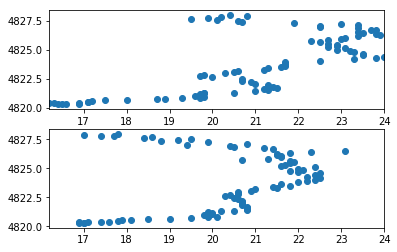

In [78]:

#fig, axs = plt.subplots(1,2)

plt.subplot(212)
plt.scatter(data_merge.temperature_x, data_merge.res_level )
plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])

plt.subplot(211)
plt.scatter(data_merge.temperature_y, data_merge.res_level )
plt.xlim([np.min([data_merge.temperature_x,data_merge.temperature_y]), np.max([data_merge.temperature_x,data_merge.temperature_y])])


In [44]:
len(data_T)

1

In [12]:
data_T = importusgssite_meantemperature(usgs_id)
#data_T_up = importusgssite_meantemperature(usgs_id_up)
data_res = read_bureau_of_rec_data(start_datetime, end_datetime, station_id, parameterx)

/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ulmo/usgs/nwis/core.py:252: FutureWarning: to_datetime is deprecated. Use self.to_pydatetime()
  start_datetime = util.convert_datetime(start)
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=14202980&parameterCd=00010&startDT=1851-01-01&statCd=00003
processing data from request: https://waterservices.usgs.gov/nwis/dv/?format=waterml&site=14202980&parameterCd=00011&startDT=1851-01-01&statCd=00003
/home/rniemeyr/anaconda/envs/my_env/lib/python3.4/site-packages/ipykernel/__main__.py:41: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [13]:
data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)
#data_6 = data_merge[data_merge.index.month == 6]
#data_7 = data_merge[data_merge.index.month == 7]
#data_8 = data_merge[data_merge.index.month == 8]
#data_9 = data_merge[data_merge.index.month == 9]

In [157]:
# ------ IF you have an upstream ------
data_merge=pd.merge(data_res,data_T, how='inner', left_index=True, right_index=True)
data_merge2 = pd.merge(data_merge,data_T_up, how='inner', left_index=True, right_index=True)
data_6 = data_merge2[data_merge2.index.month == 6]
data_7 = data_merge2[data_merge2.index.month == 7]
data_8 = data_merge2[data_merge2.index.month == 8]
data_9 = data_merge2[data_merge2.index.month == 9]

AttributeError: 'Index' object has no attribute 'month'

In [14]:
data_merge.head(3)

res_level  temperature data_quality
2002-05-01     303.53          7.0            A
2002-05-02     303.55          7.1            A
2002-05-03     303.53          7.0            A

In [15]:
data_merge.tail(3)

res_level  temperature data_quality
2015-12-29     293.49          7.4            A
2015-12-30     292.45          7.3            A
2015-12-31     291.30          7.1            A

In [22]:
type(data_merge)

pandas.core.frame.DataFrame

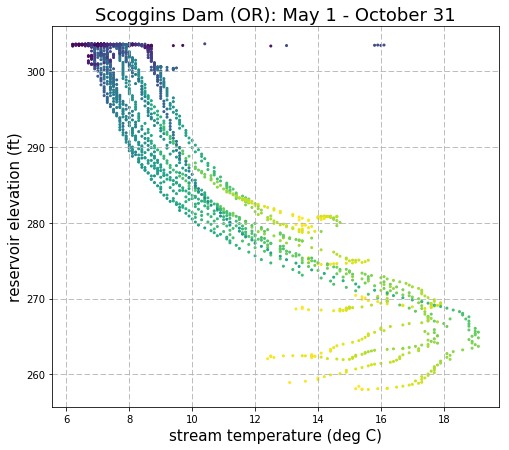

In [30]:
day1 = 120
day2 = 304
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter( data_merge.temperature[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
            data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
            s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Scoggins Dam (OR): May 1 - October 31', fontsize=18)

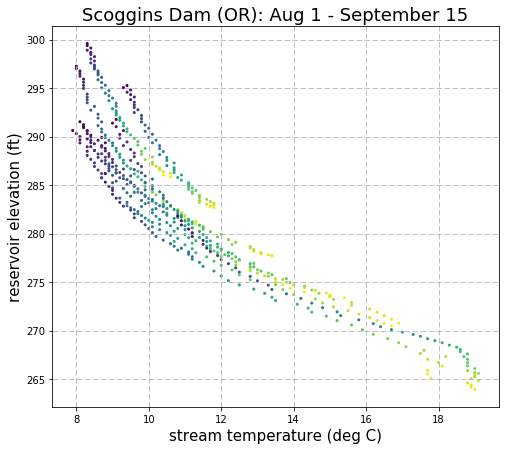

In [37]:
day1 = 213
day2 = 268
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter( data_merge.temperature[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
            data_merge.res_level[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )], 
            s=4, c=data_merge.index.dayofyear[(data_merge.index.dayofyear >= day1) & (data_merge.index.dayofyear <=day2 )])
#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Scoggins Dam (OR): Aug 1 - September 15', fontsize=18)

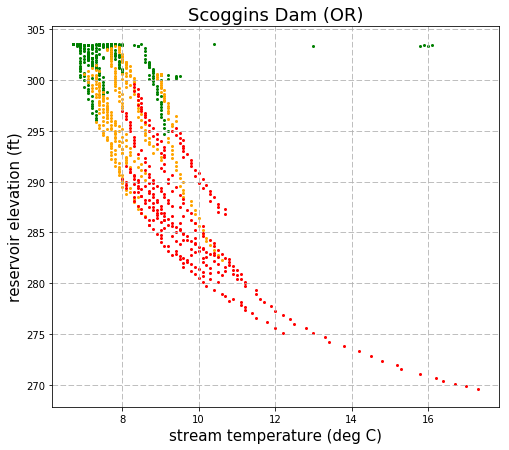

In [168]:
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter( data_6.temperature, data_6.res_level, s=4, color='green')
plt.scatter( data_7.temperature, data_7.res_level, s=4, color='orange')
plt.scatter( data_8.temperature, data_8.res_level, s=4, color='red')
#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Scoggins Dam (OR)', fontsize=18)

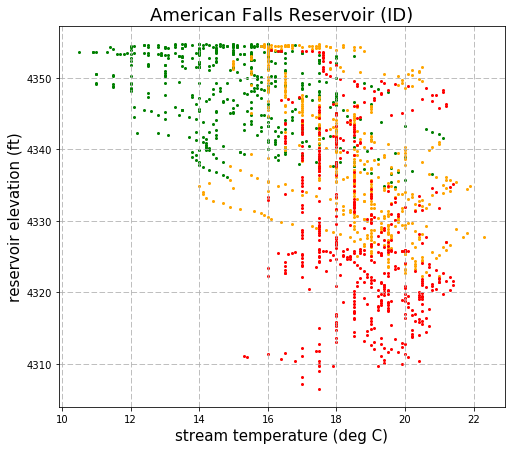

In [129]:
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter( data_6.temperature, data_6.res_level, s=4, color='green')
plt.scatter( data_7.temperature, data_7.res_level, s=4, color='orange')
plt.scatter( data_8.temperature, data_8.res_level, s=4, color='red')
#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('American Falls Reservoir (ID)', fontsize=18)

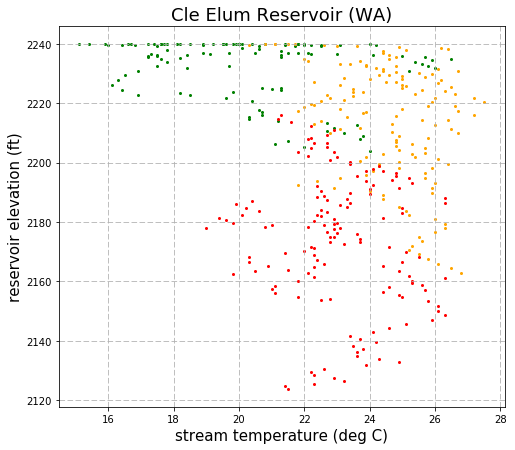

In [123]:
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter( data_6.temperature, data_6.res_level, s=4, color='green')
plt.scatter( data_7.temperature, data_7.res_level, s=4, color='orange')
plt.scatter( data_8.temperature, data_8.res_level, s=4, color='red')
#plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Cle Elum Reservoir (WA)', fontsize=18)

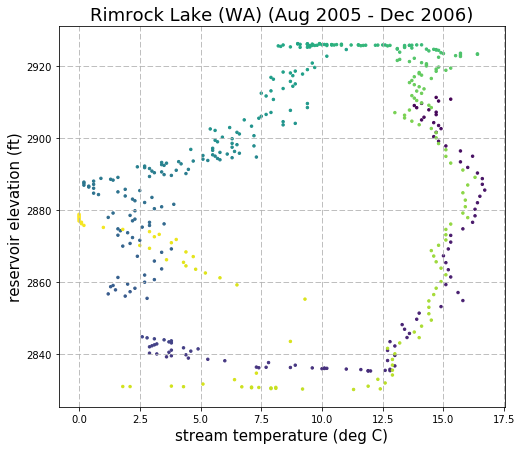

In [116]:
datex = data_merge.index
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter(data_merge.temperature, data_merge.res_level,c=data_merge.index, s=6)
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Rimrock Lake (WA) (Aug 2005 - Dec 2006)', fontsize=18)

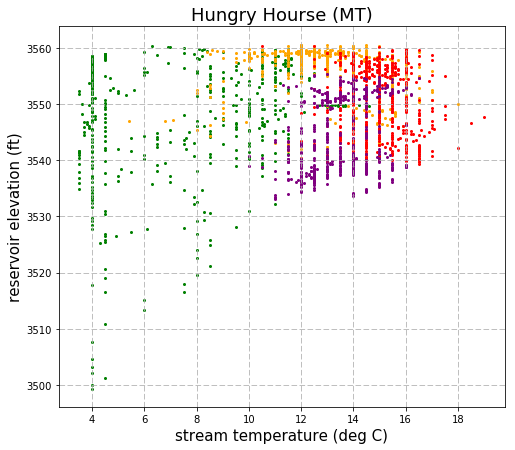

In [95]:
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter( data_6.temperature, data_6.res_level, s=4, color='green')
plt.scatter( data_7.temperature, data_7.res_level, s=4, color='orange')
plt.scatter( data_8.temperature, data_8.res_level, s=4, color='red')
plt.scatter( data_9.temperature, data_9.res_level, s=4, color='purple')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Hungry Hourse (MT)', fontsize=18)

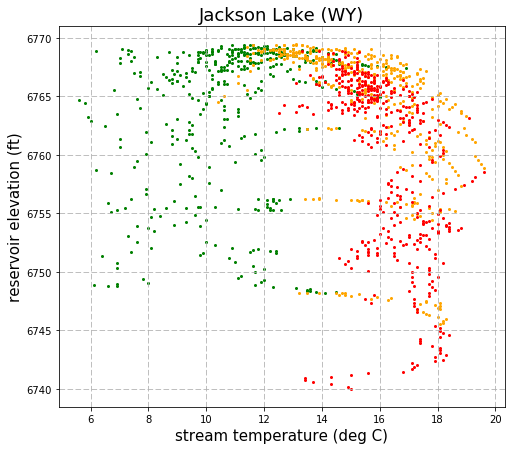

In [76]:
plt.figure(figsize=[8,7])
plt.grid(linestyle='--')
plt.scatter( data_6.temperature, data_6.res_level, s=4, color='green')
plt.scatter( data_7.temperature, data_7.res_level, s=4, color='orange')
plt.scatter( data_8.temperature, data_8.res_level, s=4, color='red')
plt.xlabel('stream temperature (deg C)', fontsize=15)
plt.ylabel('reservoir elevation (ft)', fontsize=15)
plt.title('Jackson Lake (WY)', fontsize=18)

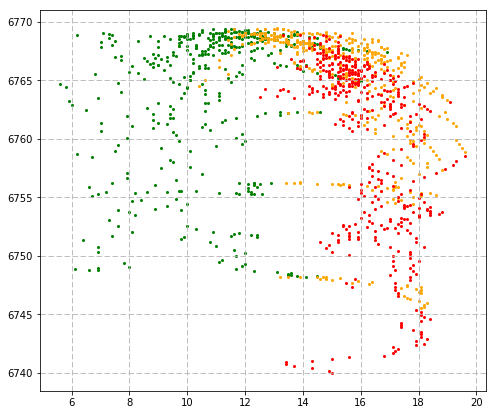

In [8]:
station_id = "EMI" #SCO was here before  
start_datetime = dt.datetime(1990,5,1)
end_datetime = dt.datetime(2015,12,31)
parameterx = 'fb'   # fb = surface elevatoin (ft), qd - daily average stream discharge (cfs), pc = precip (inches), 
                   # mm = average air temp (deg F), wy = average water temperature (celsius)

    
data = MultiStationDailyIO(
start_date=start_datetime,
end_date=end_datetime,
station=station_id,
parameter=parameterx)

In [11]:
data

# =============================================================================
#   Practice Code/Old Code
# ==============================================================================

In [ ]:
# =============================================================================
#          Function to read in USGS data
# ==============================================================================

def importusgssite_meantemperature(siteno):
    sitename = {}
    # ------ temperature with Celsius ------
    sitename = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00003',period="all", methods='all')
    # ------ temperature with Celsius - minimum temperature ------
    sitename_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00002',period="all", methods='all')
    # ------ temperature with Celsius - maximum temperature ------
    sitename_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00010',statistic_code='00001',period="all", methods='all')

    # ------ temperature with Fahrenheit ------
    sitename2 = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00003',period="all", methods='all')
    # ------ temperature with Fahrenheit ------
    sitename2_min = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00002',period="all", methods='all')
    # ------ temperature with Fahrenheit ------
    sitename2_max = ulmo.usgs.nwis.get_site_data(siteno, service="daily", parameter_code='00011',statistic_code='00001',period="all", methods='all')

    #  ----------- loop to see if it is a F or C data, and if there are multipe measurements at one site ------------
    if len(sitename) > 0 or len(sitename2) > 0 :
        if len(sitename) == 1:
            sitenameb = pd.DataFrame(sitename['00010:00003']['values'])  # temperature in celsius
            unitsx = 'C'
        if len(sitename) > 1:
            unitsx = 'C'
            for k in sitename:
                sitenameb = pd.DataFrame(sitename[str(k)]['values'])  # temperature in celsius

        if len(sitename2) == 1:
            sitenameb = pd.DataFrame(sitename2['00011:00003']['values'])  # temperature in fahrenheit
            unitsx = 'F'
        if len(sitename2) > 1:
            unitsx = 'F'
            for k in sitename2:
                sitenameb = pd.DataFrame(sitename2[str(k)]['values'])  # temperature in fahrenheit


        # -------- index, clean the data -------
        sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
        sitenameb.set_index(['dates'], inplace=True)
        sitenameb[siteno] = sitenameb['value'].astype(float)
        sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
        sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
        sitenameb = sitenameb.replace('-999999', np.NAN)
        sitenameb = sitenameb.dropna()
        sitenameb.columns = ['temperature', 'data_quality']
        
        # IF units in Fahrenheit - convert to Celsius
        if unitsx == 'F':
            sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)
            
        return sitenameb
    
    #  -------------- loop to see if it is a F or C data, and if there are multipe measurements at one site
    elif len(sitename_min) > 0 and len(sitename_max) > 0 :
        if len(sitename_max) == 1:
            sitenameb_max = pd.DataFrame(sitename_max['00010:00002']['values'])  # max temperature in celsius
            unitsx = 'C'
        if len(sitename_max) > 1:
            unitsx = 'C'
            for k in sitename_max:
                sitenameb_max = pd.DataFrame(sitename_max[str(k)]['values'])  # max temperature in celsius

        if len(sitename_min) == 1:
            sitenameb_min = pd.DataFrame(sitename_min['00010:00001']['values'])  # min temperature in celsius
            unitsx = 'F'
        if len(sitename_min) > 1:
            unitsx = 'F'
            for k in sitename_min:
                sitenameb_min = pd.DataFrame(sitename_min[str(k)]['values'])  # min temperature in celsius
                
        #if len(sitenameb_max) > 1 and len(sitenameb_min) > 1:
            


        # -------- index, clean the data -------
        sitenameb['dates'] = pd.to_datetime(pd.Series(sitenameb['datetime']))
        sitenameb.set_index(['dates'], inplace=True)
        sitenameb[siteno] = sitenameb['value'].astype(float)
        sitenameb[str(siteno)+'qual'] = sitenameb['qualifiers']
        sitenameb = sitenameb.drop(['datetime', 'qualifiers', 'value'], axis=1)
        sitenameb = sitenameb.replace('-999999', np.NAN)
        sitenameb = sitenameb.dropna()
        sitenameb.columns = ['temperature', 'data_quality']
        
        # IF units in Fahrenheit - convert to Celsius
        if unitsx == 'F':
            sitenameb.temperature = (sitenameb.temperature - 32) * (5/9)
            
        return sitenameb
    
    # ------------ if no data present or not able to read ---------
    if len(sitename) == 0:
        sitenameb = pd.DataFrame(np.nan, index=[0], columns=['A'])
        return sitenameb

In [ ]:
# =============================================================================
#          Function to read in NorWest data
# ==============================================================================

def read_NorWest_data(station_id):
    ''' This function reads in NorWest stream temperature data

    Input:
        station_id: [float] USGS site ID

    Return:
        Selected data (pandas Series)
    '''

    #station_id = reservoirs_temp_norwest['downstream1'][4]

    # -------------- get the Norwest ID row and site code --------------
    site_row = NorWest_ID_list[NorWest_ID_list.code==station_id]
    stringx = str(site_row.region.values)
    stringx = ''.join(e for e in stringx if e.isalnum())

    # ------------------ read in NorWest data files -----------------
    filex = all_NorWest_files[ID_match_ups[site_name.index(str(stringx))][1]]
    pathx = stream_temp_NorWest_path + '/' + filex
    #print(pathx)

    #  ------- Oregon is .txt (12 position) -----------
    if i == 12:
        data_x = pd.read_csv(stream_temp_NorWest_path + '/' + all_NorWest_files[12])  

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%m/%d/%Y %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'Date' in data_x.columns:
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']

    #  ------- all other files (excel) -----------       
    else:
        data_x = pd.read_excel(pathx)

        if 'SampleDate' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['SampleDate'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'DATE' in data_x.columns:
            data_x['DATE'] =  pd.to_datetime(data_x['DATE'], format='%Y-%m-%d %H:%M:%S')
            data_x = data_x.set_index(data_x['DATE'])

        if 'Date' in data_x.columns:
            data_x['Date'] =  pd.to_datetime(data_x['Date'], format='%Y-%m-%d')
            data_x = data_x.set_index(data_x['Date'])
            data_x['DATE'] = data_x['Date']
            data_x['DAILYMEAN'] = data_x['DailyMean']

    # ---------------- get specific data ---------------
    siteyearx = str(site_row.year15.values)
    siteyearx = int(''.join(e for e in siteyearx if e.isalnum()))
    data_x2 = data_x[data_x['OBSPRED_ID']==siteyearx]
    data_x3 = data_x2['DAILYMEAN']

    return data_x3
    